## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


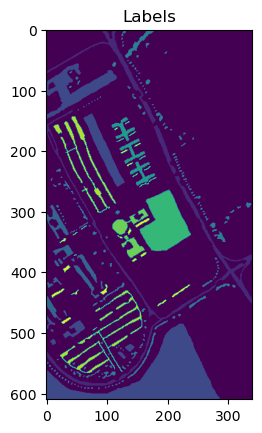

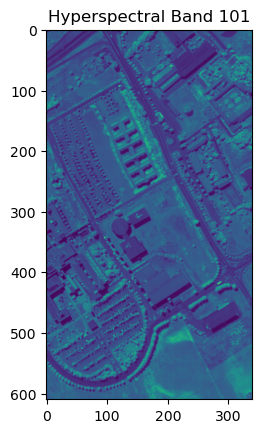

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 5 training sam


All datasets saved to the 'indices' folder.
(45, 5, 5, 103)
(45, 5, 5, 103)
(42686, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 45
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1208, PSNR: 7.3677


	 Training Batch [200/535], Loss: 0.0653, PSNR: 10.0181


	 Training Batch [400/535], Loss: 0.0303, PSNR: 13.3863


Epoch [1/50] Training Loss: 0.0559, PSNR: 11.1925
	[Val]   Batch [1/134] Loss: 0.0188, PSNR: 15.4517
	[Val]   Batch [10/134] Loss: 0.0166, PSNR: 17.7991
	[Val]   Batch [20/134] Loss: 0.0177, PSNR: 15.6280
	[Val]   Batch [30/134] Loss: 0.0192, PSNR: 15.0869
	[Val]   Batch [40/134] Loss: 0.0174, PSNR: 14.1250
	[Val]   Batch [50/134] Loss: 0.0186, PSNR: 15.2647
	[Val]   Batch [60/134] Loss: 0.0168, PSNR: 15.9537


	[Val]   Batch [70/134] Loss: 0.0160, PSNR: 16.1412
	[Val]   Batch [80/134] Loss: 0.0157, PSNR: 16.1197
	[Val]   Batch [90/134] Loss: 0.0164, PSNR: 16.1126
	[Val]   Batch [100/134] Loss: 0.0186, PSNR: 15.5104
	[Val]   Batch [110/134] Loss: 0.0189, PSNR: 14.0343
	[Val]   Batch [120/134] Loss: 0.0154, PSNR: 15.2126
	[Val]   Batch [130/134] Loss: 0.0170, PSNR: 13.2409
Epoch [1/50] Validation Loss: 0.0178, PSNR: 15.4790

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0166, PSNR: 15.9192


	 Training Batch [200/535], Loss: 0.0118, PSNR: 17.2487


	 Training Batch [400/535], Loss: 0.0093, PSNR: 18.3833


Epoch [2/50] Training Loss: 0.0116, PSNR: 17.4571
	[Val]   Batch [1/134] Loss: 0.0086, PSNR: 18.8372
	[Val]   Batch [10/134] Loss: 0.0069, PSNR: 21.6210
	[Val]   Batch [20/134] Loss: 0.0075, PSNR: 19.3669
	[Val]   Batch [30/134] Loss: 0.0085, PSNR: 18.6125
	[Val]   Batch [40/134] Loss: 0.0076, PSNR: 17.7082
	[Val]   Batch [50/134] Loss: 0.0079, PSNR: 18.9704
	[Val]   Batch [60/134] Loss: 0.0069, PSNR: 19.8064
	[Val]   Batch [70/134] Loss: 0.0067, PSNR: 19.9109


	[Val]   Batch [80/134] Loss: 0.0064, PSNR: 19.9854
	[Val]   Batch [90/134] Loss: 0.0068, PSNR: 19.9296
	[Val]   Batch [100/134] Loss: 0.0082, PSNR: 19.0686
	[Val]   Batch [110/134] Loss: 0.0078, PSNR: 17.8963
	[Val]   Batch [120/134] Loss: 0.0058, PSNR: 19.5008
	[Val]   Batch [130/134] Loss: 0.0070, PSNR: 17.1095
Epoch [2/50] Validation Loss: 0.0078, PSNR: 19.0985

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0083, PSNR: 19.0063


	 Training Batch [200/535], Loss: 0.0059, PSNR: 20.5602


	 Training Batch [400/535], Loss: 0.0057, PSNR: 20.6294


Epoch [3/50] Training Loss: 0.0067, PSNR: 19.7265
	[Val]   Batch [1/134] Loss: 0.0059, PSNR: 20.4890
	[Val]   Batch [10/134] Loss: 0.0046, PSNR: 23.3277
	[Val]   Batch [20/134] Loss: 0.0050, PSNR: 21.1353
	[Val]   Batch [30/134] Loss: 0.0057, PSNR: 20.3880
	[Val]   Batch [40/134] Loss: 0.0052, PSNR: 19.4094
	[Val]   Batch [50/134] Loss: 0.0052, PSNR: 20.7902
	[Val]   Batch [60/134] Loss: 0.0046, PSNR: 21.5917


	[Val]   Batch [70/134] Loss: 0.0045, PSNR: 21.6201
	[Val]   Batch [80/134] Loss: 0.0043, PSNR: 21.7258
	[Val]   Batch [90/134] Loss: 0.0046, PSNR: 21.6876
	[Val]   Batch [100/134] Loss: 0.0056, PSNR: 20.7613
	[Val]   Batch [110/134] Loss: 0.0050, PSNR: 19.8000
	[Val]   Batch [120/134] Loss: 0.0036, PSNR: 21.5227
	[Val]   Batch [130/134] Loss: 0.0045, PSNR: 19.0109
Epoch [3/50] Validation Loss: 0.0053, PSNR: 20.7975

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0065, PSNR: 20.0520


	 Training Batch [200/535], Loss: 0.0055, PSNR: 20.8286


	 Training Batch [400/535], Loss: 0.0043, PSNR: 21.8544


Epoch [4/50] Training Loss: 0.0047, PSNR: 21.3138
	[Val]   Batch [1/134] Loss: 0.0040, PSNR: 22.2015
	[Val]   Batch [10/134] Loss: 0.0032, PSNR: 24.9314
	[Val]   Batch [20/134] Loss: 0.0032, PSNR: 23.0011
	[Val]   Batch [30/134] Loss: 0.0037, PSNR: 22.2744
	[Val]   Batch [40/134] Loss: 0.0034, PSNR: 21.2789
	[Val]   Batch [50/134] Loss: 0.0033, PSNR: 22.8022
	[Val]   Batch [60/134] Loss: 0.0032, PSNR: 23.0939


	[Val]   Batch [70/134] Loss: 0.0031, PSNR: 23.2208
	[Val]   Batch [80/134] Loss: 0.0030, PSNR: 23.3620
	[Val]   Batch [90/134] Loss: 0.0031, PSNR: 23.3405
	[Val]   Batch [100/134] Loss: 0.0037, PSNR: 22.4963
	[Val]   Batch [110/134] Loss: 0.0031, PSNR: 21.8260
	[Val]   Batch [120/134] Loss: 0.0024, PSNR: 23.3432
	[Val]   Batch [130/134] Loss: 0.0029, PSNR: 20.9722


Epoch [4/50] Validation Loss: 0.0036, PSNR: 22.5088

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0036, PSNR: 22.2659


	 Training Batch [200/535], Loss: 0.0030, PSNR: 23.3390


	 Training Batch [400/535], Loss: 0.0025, PSNR: 21.9793


Epoch [5/50] Training Loss: 0.0034, PSNR: 22.6835
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.3201
	[Val]   Batch [10/134] Loss: 0.0024, PSNR: 26.1122
	[Val]   Batch [20/134] Loss: 0.0024, PSNR: 24.3914
	[Val]   Batch [30/134] Loss: 0.0027, PSNR: 23.6490
	[Val]   Batch [40/134] Loss: 0.0024, PSNR: 22.6761
	[Val]   Batch [50/134] Loss: 0.0023, PSNR: 24.2999


	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.1339
	[Val]   Batch [70/134] Loss: 0.0024, PSNR: 24.3545
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.4877
	[Val]   Batch [90/134] Loss: 0.0024, PSNR: 24.4562
	[Val]   Batch [100/134] Loss: 0.0028, PSNR: 23.7828
	[Val]   Batch [110/134] Loss: 0.0022, PSNR: 23.4278
	[Val]   Batch [120/134] Loss: 0.0017, PSNR: 24.7399
	[Val]   Batch [130/134] Loss: 0.0021, PSNR: 22.3143


Epoch [5/50] Validation Loss: 0.0027, PSNR: 23.7341

LOG: Epoch [6/50]
	 Training Batch [1/535], Loss: 0.0030, PSNR: 23.5260


	 Training Batch [200/535], Loss: 0.0034, PSNR: 22.6252


	 Training Batch [400/535], Loss: 0.0028, PSNR: 25.5763


Epoch [6/50] Training Loss: 0.0028, PSNR: 23.5781
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.1200
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.9909
	[Val]   Batch [20/134] Loss: 0.0018, PSNR: 25.4889
	[Val]   Batch [30/134] Loss: 0.0021, PSNR: 24.6799
	[Val]   Batch [40/134] Loss: 0.0019, PSNR: 23.7551
	[Val]   Batch [50/134] Loss: 0.0018, PSNR: 25.3966
	[Val]   Batch [60/134] Loss: 0.0021, PSNR: 24.9907


	[Val]   Batch [70/134] Loss: 0.0020, PSNR: 25.2257
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.3912
	[Val]   Batch [90/134] Loss: 0.0020, PSNR: 25.2913
	[Val]   Batch [100/134] Loss: 0.0022, PSNR: 24.7426
	[Val]   Batch [110/134] Loss: 0.0016, PSNR: 24.6663
	[Val]   Batch [120/134] Loss: 0.0013, PSNR: 25.8804
	[Val]   Batch [130/134] Loss: 0.0016, PSNR: 23.3796
Epoch [6/50] Validation Loss: 0.0022, PSNR: 24.6764

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0035, PSNR: 22.8496


	 Training Batch [200/535], Loss: 0.0019, PSNR: 23.4449


	 Training Batch [400/535], Loss: 0.0034, PSNR: 23.0143


Epoch [7/50] Training Loss: 0.0024, PSNR: 24.1910
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.6117
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.5265
	[Val]   Batch [20/134] Loss: 0.0015, PSNR: 26.2119
	[Val]   Batch [30/134] Loss: 0.0018, PSNR: 25.3465
	[Val]   Batch [40/134] Loss: 0.0016, PSNR: 24.4515
	[Val]   Batch [50/134] Loss: 0.0015, PSNR: 26.0739


	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.5176
	[Val]   Batch [70/134] Loss: 0.0017, PSNR: 25.7715
	[Val]   Batch [80/134] Loss: 0.0016, PSNR: 25.9855
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.7970
	[Val]   Batch [100/134] Loss: 0.0019, PSNR: 25.3349
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.4435
	[Val]   Batch [120/134] Loss: 0.0011, PSNR: 26.6374


	[Val]   Batch [130/134] Loss: 0.0014, PSNR: 24.0054
Epoch [7/50] Validation Loss: 0.0019, PSNR: 25.2763

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 23.6064


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.4085


	 Training Batch [400/535], Loss: 0.0024, PSNR: 24.3983


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.6218
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 24.9268
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.8486
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.7239
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.7245
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.9168
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4398
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.8609


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.1235
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3744
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.1267
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.7084
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9012
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0855
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.4015
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.6634

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0021, PSNR: 24.7064


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.0040


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.2484


Epoch [9/50] Training Loss: 0.0020, PSNR: 24.9840
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.3247
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.2709
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.2601
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.2605
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.4608
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.9843
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.2775


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.5165
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.8380
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.5291
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1804
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.5473
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.6694
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.9157
Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.1359

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.4032


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.3530


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.3471


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.2307
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.5582
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.5236
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.6142
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.5718
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.8055
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.2689
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.5268


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.7769
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.1226
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.7800
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.4488
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.9133
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.0175
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.2183
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.4246

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.9590


	 Training Batch [200/535], Loss: 0.0019, PSNR: 25.3064


	 Training Batch [400/535], Loss: 0.0021, PSNR: 24.8294


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4577
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.7418
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.7094
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.8684
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.7977
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.0662
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4845
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.7225


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9755
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.3418
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 26.9767
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6589
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.1775
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2439
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.4507
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.6456

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0022, PSNR: 25.0391


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.0824


	 Training Batch [400/535], Loss: 0.0012, PSNR: 25.0547


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.6381
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9021
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8802
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.0929
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 26.9957
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.2759
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.6757
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9111


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1418
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5607
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.1740
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.8381
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.3810
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.4742
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.6491
Epoch [12/50] Validation Loss: 0.0014, PSNR: 26.8447

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2012


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.6140


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.2812


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8126
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0830
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.0510
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.3484
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.1931
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.5216
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.8953
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.0835


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3306
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7715
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3793
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.0272
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.6050
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6929
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.9040
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0467

LOG: Epoch [14/50]


	 Training Batch [1/535], Loss: 0.0012, PSNR: 26.1466


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.0596


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.0709


Epoch [14/50] Training Loss: 0.0016, PSNR: 25.9787
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.2987
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2614
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6603
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4596
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8386
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1581


	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.3149
	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.5418
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0346
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.6032
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.2562
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9589
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 28.9842


	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1666
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3092

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 26.3655


	 Training Batch [200/535], Loss: 0.0016, PSNR: 25.9810


	 Training Batch [400/535], Loss: 0.0012, PSNR: 25.6140


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1199
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4769
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4112
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.9125
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6514
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0339
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3530


	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5142
	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7055
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2437
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7907
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4294
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.1862
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.1819
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3523
Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.5012

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.4305


	 Training Batch [200/535], Loss: 0.0012, PSNR: 26.4800


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.8402


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.2511
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.5861
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5358
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.0542
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7889
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.2236
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.4869
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6605


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8458
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.3896
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.9318
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5772
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3492
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3106
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.5413
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.6478

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 25.4970


	 Training Batch [200/535], Loss: 0.0020, PSNR: 25.0706


	 Training Batch [400/535], Loss: 0.0013, PSNR: 26.9766


Epoch [17/50] Training Loss: 0.0015, PSNR: 26.3894
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.7852
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7204
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.3196
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.9779
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.4549
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.6996
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8551


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0492
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6299
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1471
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7421
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5840
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5969
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7660
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.8598

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.1613


	 Training Batch [200/535], Loss: 0.0009, PSNR: 26.3951


	 Training Batch [400/535], Loss: 0.0009, PSNR: 27.1283


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.5477
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.8200
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7319
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.3633
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0639
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5222
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7429
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8936


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0929
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6294
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.1692
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8129
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.6303
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5343
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8248
Epoch [18/50] Validation Loss: 0.0011, PSNR: 27.9065

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.1311


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.4729


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.3999


Epoch [19/50] Training Loss: 0.0014, PSNR: 26.6597
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0163
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9180
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.6554
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.2706
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7419
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9312
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1435


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2961
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9172
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.3939
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.9973
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8265
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7642
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.9873
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.1221

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.9938


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.7130


	 Training Batch [400/535], Loss: 0.0010, PSNR: 26.8554


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.7980
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0602
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9111
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.6491
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.2440
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7056
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.8780
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.1936


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3278
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8924
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4158
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.9873
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.6844
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.6499
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.9512
Epoch [20/50] Validation Loss: 0.0010, PSNR: 28.1092

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.5397


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.8568


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.1905


Epoch [21/50] Training Loss: 0.0013, PSNR: 26.9346
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3395
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1518
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0593
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.5661
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0555
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.2073
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.5184


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5954
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2151
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.7203
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2758
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0471
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9973
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.3039
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.4153

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.6107


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.8241


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.4537


Epoch [22/50] Training Loss: 0.0013, PSNR: 27.0496
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.5354
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2964
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.3641
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.8394
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.3485
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4674
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.7754


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.8581
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.4583
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.9268
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.5298
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2650
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.1740
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.5736
Epoch [22/50] Validation Loss: 0.0009, PSNR: 28.6551

LOG: Epoch [23/50]


	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.5901


	 Training Batch [200/535], Loss: 0.0018, PSNR: 27.0295


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.0201


Epoch [23/50] Training Loss: 0.0012, PSNR: 27.1972
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.7863
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4974
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7125
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.1444
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6244
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.7127
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.0718


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1117
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7235
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.2185
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7899
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.5001
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3561
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.8787
Epoch [23/50] Validation Loss: 0.0008, PSNR: 28.9124

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.5656


	 Training Batch [200/535], Loss: 0.0007, PSNR: 27.4869


	 Training Batch [400/535], Loss: 0.0009, PSNR: 26.3254


Epoch [24/50] Training Loss: 0.0012, PSNR: 27.3332
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.9438
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.5795
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7898
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.2941
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.7405
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.8181
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.2582


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.3105
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.8897
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.4059
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 28.9613
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4868
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3664
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0080
Epoch [24/50] Validation Loss: 0.0008, PSNR: 29.0453

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.7894


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.4727


	 Training Batch [400/535], Loss: 0.0011, PSNR: 28.7587


Epoch [25/50] Training Loss: 0.0011, PSNR: 27.5509
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.2284
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.8217
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.2003
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.6783
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.0941
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.1532


	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.5840
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.6257
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2140
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.7582
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.2937
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7911


	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6051
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.3390
Epoch [25/50] Validation Loss: 0.0008, PSNR: 29.3708

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.0415


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6596


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.5203


Epoch [26/50] Training Loss: 0.0011, PSNR: 27.6772
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.4891
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.0027
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.4358
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.9635
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2959
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.4216


	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.8272
	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.9071
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.4460
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.0691
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.5432
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9002
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7229


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5516
Epoch [26/50] Validation Loss: 0.0007, PSNR: 29.6009

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 28.7008


	 Training Batch [200/535], Loss: 0.0007, PSNR: 29.2305


	 Training Batch [400/535], Loss: 0.0010, PSNR: 28.0805


Epoch [27/50] Training Loss: 0.0010, PSNR: 27.8214
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.7032
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.1693
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5155
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.1543
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.3507
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.5570
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9964


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.1074
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.5587
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.2609
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.7838
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8837
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7156


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6290
Epoch [27/50] Validation Loss: 0.0007, PSNR: 29.7545

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 27.4608


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.4664


	 Training Batch [400/535], Loss: 0.0011, PSNR: 26.0675


Epoch [28/50] Training Loss: 0.0010, PSNR: 28.0068
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9647
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3909
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7075
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.4514
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5929
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8123
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2841


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4444
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8183
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5891
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1116
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.0498
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.8911
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8105
Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.0159

LOG: Epoch [29/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.4852


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.6356


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.3827


Epoch [29/50] Training Loss: 0.0010, PSNR: 28.2222
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3012
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6052
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.8818
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.7358
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.6933
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.0456
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.4831


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6885
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.9781
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.8322
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3575
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.1172
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.9475
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.9581
Epoch [29/50] Validation Loss: 0.0006, PSNR: 30.2423

LOG: Epoch [30/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.6334


	 Training Batch [200/535], Loss: 0.0013, PSNR: 27.9399


	 Training Batch [400/535], Loss: 0.0008, PSNR: 29.1188


Epoch [30/50] Training Loss: 0.0009, PSNR: 28.3646
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.6605
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 31.8876
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.1793
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.1113
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.9553
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 31.4199


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.7190
	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.0185
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.2308
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.1400
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.7233
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3955
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.1467


	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.2067
Epoch [30/50] Validation Loss: 0.0006, PSNR: 30.5607

LOG: Epoch [31/50]
	 Training Batch [1/535], Loss: 0.0008, PSNR: 29.1513


	 Training Batch [200/535], Loss: 0.0008, PSNR: 28.9247


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.8016


Epoch [31/50] Training Loss: 0.0009, PSNR: 28.5261
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.8588
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 32.0121
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.2840
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.2833
	[Val]   Batch [40/134] Loss: 0.0004, PSNR: 30.0638
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.5830
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.9124


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.1821
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.3394
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.3243
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.8950
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.4821
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.2403
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.2777
Epoch [31/50] Validation Loss: 0.0005, PSNR: 30.7172

LOG: Epoch [32/50]


	 Training Batch [1/535], Loss: 0.0007, PSNR: 29.5698


	 Training Batch [200/535], Loss: 0.0007, PSNR: 28.1485


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.1100


Epoch [32/50] Training Loss: 0.0009, PSNR: 28.6357
	[Val]   Batch [1/134] Loss: 0.0007, PSNR: 29.9516
	[Val]   Batch [10/134] Loss: 0.0006, PSNR: 32.0527
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 32.2244
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 31.2904
	[Val]   Batch [40/134] Loss: 0.0004, PSNR: 30.0141
	[Val]   Batch [50/134] Loss: 0.0004, PSNR: 31.4899
	[Val]   Batch [60/134] Loss: 0.0005, PSNR: 30.8561


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 31.2202
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 31.3549
	[Val]   Batch [90/134] Loss: 0.0005, PSNR: 31.3714
	[Val]   Batch [100/134] Loss: 0.0005, PSNR: 30.9560
	[Val]   Batch [110/134] Loss: 0.0004, PSNR: 30.3328
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 31.1683
	[Val]   Batch [130/134] Loss: 0.0004, PSNR: 29.2421
Epoch [32/50] Validation Loss: 0.0005, PSNR: 30.7336
Early stopping triggered at epoch 32. No improvement for 3 epochs.


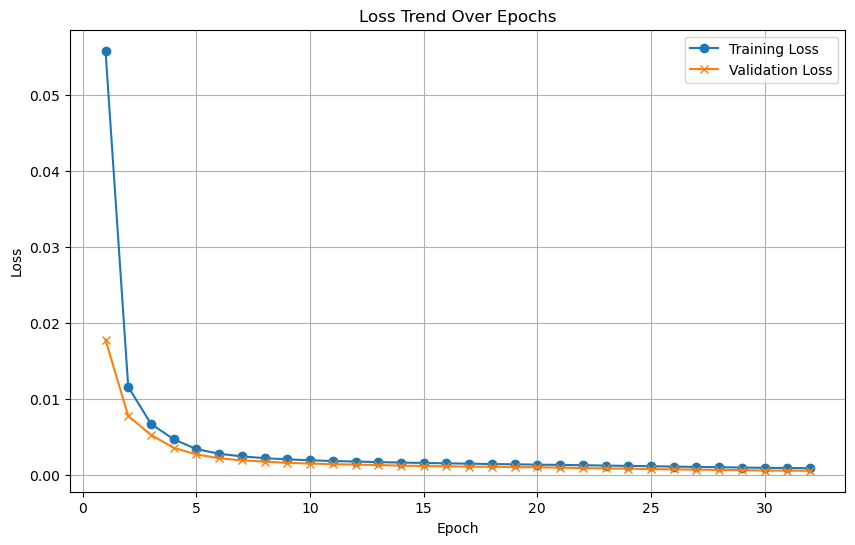

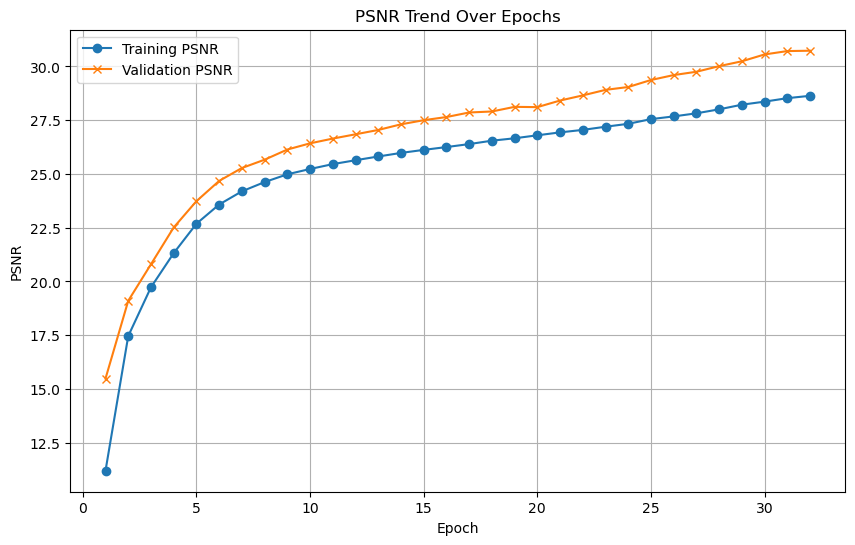

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2091
    Validation Batch [1/1], Loss: 2.2054
Validation Loss: 2.2054, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2054. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1609
    Validation Batch [1/1], Loss: 2.2054
Validation Loss: 2.2054, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1264
    Validation Batch [1/1], Loss: 2.2055
Validation Loss: 2.2055, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0990
    Validation Batch [1/1], Loss: 2.2055
Validation Loss: 2.2055, Validation Accuracy: 11.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Averag

Epoch [24/1000] completed, Average Training Loss: 1.8086
    Validation Batch [1/1], Loss: 2.1994
Validation Loss: 2.1994, Validation Accuracy: 11.11%
Validation loss improved from 2.2016 to 2.1994. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 1.7766
    Validation Batch [1/1], Loss: 2.1969
Validation Loss: 2.1969, Validation Accuracy: 11.11%
Validation loss improved from 2.1994 to 2.1969. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 1.8068
    Validation Batch [1/1], Loss: 2.1941
Validation Loss: 2.1941, Validation Accuracy: 11.11%
Validation loss improved from 2.1969 to 2.1941. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 1.7683
    Validation Batch [1/1], Loss: 2.1909
Validation Loss: 2.1909, Validation Accuracy: 11.11%
Validation loss improved from 2.1941 to 2.1909. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [2

    Validation Batch [1/1], Loss: 1.8359
Validation Loss: 1.8359, Validation Accuracy: 35.56%
Validation loss improved from 1.8525 to 1.8359. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.5020
    Validation Batch [1/1], Loss: 1.8177
Validation Loss: 1.8177, Validation Accuracy: 37.78%
Validation loss improved from 1.8359 to 1.8177. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.4946
    Validation Batch [1/1], Loss: 1.8023
Validation Loss: 1.8023, Validation Accuracy: 37.78%
Validation loss improved from 1.8177 to 1.8023. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.5289
    Validation Batch [1/1], Loss: 1.7881
Validation Loss: 1.7881, Validation Accuracy: 37.78%
Validation loss improved from 1.8023 to 1.7881. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [59/1000] completed, Average Training Loss: 1.5122
    Vali

Epoch [87/1000] completed, Average Training Loss: 1.2917
    Validation Batch [1/1], Loss: 1.6052
Validation Loss: 1.6052, Validation Accuracy: 44.44%
Validation loss improved from 1.6118 to 1.6052. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.2418
    Validation Batch [1/1], Loss: 1.6008
Validation Loss: 1.6008, Validation Accuracy: 44.44%
Validation loss improved from 1.6052 to 1.6008. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.2990
    Validation Batch [1/1], Loss: 1.6008
Validation Loss: 1.6008, Validation Accuracy: 46.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 1.2421
    Validation Batch [1/1], Loss: 1.5987
Validation Loss: 1.5987, Validation Accuracy: 44.44%
Validation loss improved from 1.6008 to 1.5987. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] complet

Epoch [120/1000] completed, Average Training Loss: 1.1015
    Validation Batch [1/1], Loss: 1.4705
Validation Loss: 1.4705, Validation Accuracy: 51.11%
Validation loss improved from 1.4741 to 1.4705. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.0362
    Validation Batch [1/1], Loss: 1.4659
Validation Loss: 1.4659, Validation Accuracy: 53.33%
Validation loss improved from 1.4705 to 1.4659. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.0621
    Validation Batch [1/1], Loss: 1.4580
Validation Loss: 1.4580, Validation Accuracy: 62.22%
Validation loss improved from 1.4659 to 1.4580. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.0684
    Validation Batch [1/1], Loss: 1.4566
Validation Loss: 1.4566, Validation Accuracy: 66.67%
Validation loss improved from 1.4580 to 1.4566. Saving model...

LOG: Epoch [124/1000] - Training


    Validation Batch [1/1], Loss: 1.3378
Validation Loss: 1.3378, Validation Accuracy: 68.89%
Validation loss improved from 1.3461 to 1.3378. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.8835
    Validation Batch [1/1], Loss: 1.3329
Validation Loss: 1.3329, Validation Accuracy: 64.44%
Validation loss improved from 1.3378 to 1.3329. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 0.8657
    Validation Batch [1/1], Loss: 1.3310
Validation Loss: 1.3310, Validation Accuracy: 64.44%
Validation loss improved from 1.3329 to 1.3310. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 0.8638
    Validation Batch [1/1], Loss: 1.3310
Validation Loss: 1.3310, Validation Accuracy: 64.44%
Validation loss improved from 1.3310 to 1.3310. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 0.8263


    Validation Batch [1/1], Loss: 1.2181
Validation Loss: 1.2181, Validation Accuracy: 73.33%
Validation loss improved from 1.2256 to 1.2181. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.6085
    Validation Batch [1/1], Loss: 1.2137
Validation Loss: 1.2137, Validation Accuracy: 73.33%
Validation loss improved from 1.2181 to 1.2137. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.6279
    Validation Batch [1/1], Loss: 1.2074
Validation Loss: 1.2074, Validation Accuracy: 73.33%
Validation loss improved from 1.2137 to 1.2074. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.6954
    Validation Batch [1/1], Loss: 1.2068
Validation Loss: 1.2068, Validation Accuracy: 71.11%
Validation loss improved from 1.2074 to 1.2068. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.6402


    Validation Batch [1/1], Loss: 1.1219
Validation Loss: 1.1219, Validation Accuracy: 73.33%
Validation loss improved from 1.1249 to 1.1219. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.4569
    Validation Batch [1/1], Loss: 1.1179
Validation Loss: 1.1179, Validation Accuracy: 73.33%
Validation loss improved from 1.1219 to 1.1179. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.4821
    Validation Batch [1/1], Loss: 1.1248
Validation Loss: 1.1248, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.4815
    Validation Batch [1/1], Loss: 1.1235
Validation Loss: 1.1235, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.5252
    Validation Batch [1/1], Lo

Epoch [249/1000] completed, Average Training Loss: 0.3331
    Validation Batch [1/1], Loss: 1.0985
Validation Loss: 1.0985, Validation Accuracy: 68.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.3308
    Validation Batch [1/1], Loss: 1.0605
Validation Loss: 1.0605, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.3729
    Validation Batch [1/1], Loss: 1.0317
Validation Loss: 1.0317, Validation Accuracy: 71.11%
Validation loss improved from 1.0371 to 1.0317. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.3705
    Validation Batch [1/1], Loss: 1.0250
Validation Loss: 1.0250, Validation Accuracy: 73.33%
Validation loss improved from 1.0317 to 1.0250. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Av

    Validation Batch [1/1], Loss: 0.9967
Validation Loss: 0.9967, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.2983
    Validation Batch [1/1], Loss: 1.0175
Validation Loss: 1.0175, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.2902
    Validation Batch [1/1], Loss: 1.0221
Validation Loss: 1.0221, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.2630
    Validation Batch [1/1], Loss: 1.0165
Validation Loss: 1.0165, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.3361
    Validation Batch [1/1], Loss: 0.9915
Validation Loss: 0.

Epoch [317/1000] completed, Average Training Loss: 0.1874
    Validation Batch [1/1], Loss: 0.9393
Validation Loss: 0.9393, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.1869
    Validation Batch [1/1], Loss: 0.9518
Validation Loss: 0.9518, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.1444
    Validation Batch [1/1], Loss: 0.9553
Validation Loss: 0.9553, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.1747
    Validation Batch [1/1], Loss: 0.9382
Validation Loss: 0.9382, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.1390
  

    Validation Batch [1/1], Loss: 0.9354
Validation Loss: 0.9354, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.1464
    Validation Batch [1/1], Loss: 0.9254
Validation Loss: 0.9254, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.1401
    Validation Batch [1/1], Loss: 0.9116
Validation Loss: 0.9116, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.1260
    Validation Batch [1/1], Loss: 0.9089
Validation Loss: 0.9089, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.1128
    Validation Batch [1/1], Loss: 0.8998
Validation Loss

Epoch [384/1000] completed, Average Training Loss: 0.1077
    Validation Batch [1/1], Loss: 0.9091
Validation Loss: 0.9091, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.1073
    Validation Batch [1/1], Loss: 0.9012
Validation Loss: 0.9012, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.1000
    Validation Batch [1/1], Loss: 0.9032
Validation Loss: 0.9032, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.0935
    Validation Batch [1/1], Loss: 0.9143
Validation Loss: 0.9143, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.116

Epoch [419/1000] completed, Average Training Loss: 0.0829
    Validation Batch [1/1], Loss: 0.8815
Validation Loss: 0.8815, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.0762
    Validation Batch [1/1], Loss: 0.8950
Validation Loss: 0.8950, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.0768
    Validation Batch [1/1], Loss: 0.9122
Validation Loss: 0.9122, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.0972
    Validation Batch [1/1], Loss: 0.9320
Validation Loss: 0.9320, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.075

Epoch [452/1000] completed, Average Training Loss: 0.0796
    Validation Batch [1/1], Loss: 0.8826
Validation Loss: 0.8826, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0900
    Validation Batch [1/1], Loss: 0.9019
Validation Loss: 0.9019, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0715
    Validation Batch [1/1], Loss: 0.9107
Validation Loss: 0.9107, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.0868
    Validation Batch [1/1], Loss: 0.9009
Validation Loss: 0.9009, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.081

Epoch [486/1000] completed, Average Training Loss: 0.0471
    Validation Batch [1/1], Loss: 0.8594
Validation Loss: 0.8594, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.0588
    Validation Batch [1/1], Loss: 0.8501
Validation Loss: 0.8501, Validation Accuracy: 77.78%
Validation loss improved from 0.8531 to 0.8501. Saving model...

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.0565
    Validation Batch [1/1], Loss: 0.8541
Validation Loss: 0.8541, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [489/1000] - Training
Epoch [489/1000] completed, Average Training Loss: 0.0720
    Validation Batch [1/1], Loss: 0.8719
Validation Loss: 0.8719, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training

Epoch [522/1000] completed, Average Training Loss: 0.0461
    Validation Batch [1/1], Loss: 0.8729
Validation Loss: 0.8729, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0483
    Validation Batch [1/1], Loss: 0.8931
Validation Loss: 0.8931, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0454
    Validation Batch [1/1], Loss: 0.9200
Validation Loss: 0.9200, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0603
    Validation Batch [1/1], Loss: 0.9233
Validation Loss: 0.9233, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0521
  

Epoch [555/1000] completed, Average Training Loss: 0.0404
    Validation Batch [1/1], Loss: 0.9522
Validation Loss: 0.9522, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0477
    Validation Batch [1/1], Loss: 0.9074
Validation Loss: 0.9074, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.9555
Validation Loss: 0.9555, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 1.0447
Validation Loss: 1.0447, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.043

    Validation Batch [1/1], Loss: 0.9363
Validation Loss: 0.9363, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0378
    Validation Batch [1/1], Loss: 0.9070
Validation Loss: 0.9070, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0483
    Validation Batch [1/1], Loss: 0.8980
Validation Loss: 0.8980, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.8920
Validation Loss: 0.8920, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0461
    Validation Batch [1/1], Loss: 0.8567
Validation Loss

    Validation Batch [1/1], Loss: 0.9485
Validation Loss: 0.9485, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [621/1000] - Training
Epoch [621/1000] completed, Average Training Loss: 0.0256
    Validation Batch [1/1], Loss: 0.9371
Validation Loss: 0.9371, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0261
    Validation Batch [1/1], Loss: 0.9323
Validation Loss: 0.9323, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.9185
Validation Loss: 0.9185, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.9220
Validation Loss

Epoch [655/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.9097
Validation Loss: 0.9097, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0261
    Validation Batch [1/1], Loss: 0.9031
Validation Loss: 0.9031, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.9078
Validation Loss: 0.9078, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.9092
Validation Loss: 0.9092, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0.040

Epoch [687/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.9307
Validation Loss: 0.9307, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [688/1000] - Training
Epoch [688/1000] completed, Average Training Loss: 0.0344
    Validation Batch [1/1], Loss: 0.9445
Validation Loss: 0.9445, Validation Accuracy: 75.56%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [689/1000] - Training
Epoch [689/1000] completed, Average Training Loss: 0.0247
    Validation Batch [1/1], Loss: 0.9705
Validation Loss: 0.9705, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [690/1000] - Training
Epoch [690/1000] completed, Average Training Loss: 0.0241
    Validation Batch [1/1], Loss: 0.9995
Validation Loss: 0.9995, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [691/1000] - Training
Epoch [691/1000] completed, Average Training Loss: 0.026

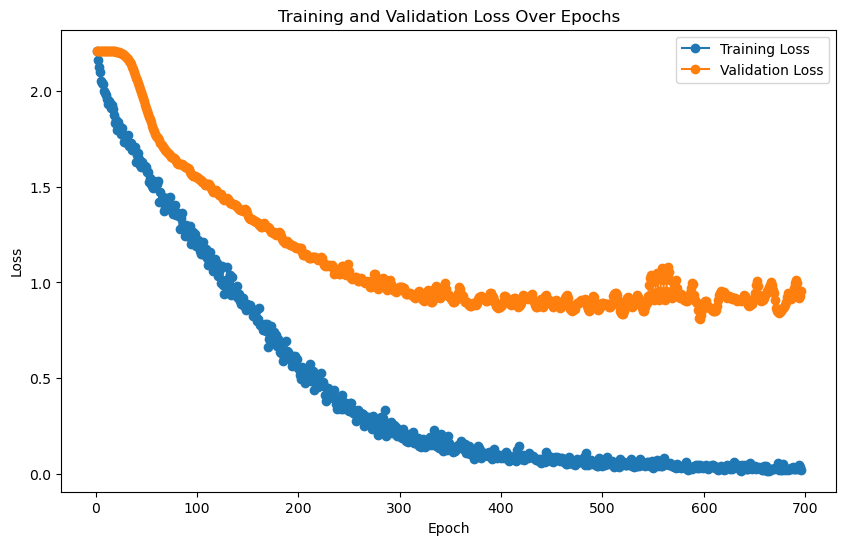

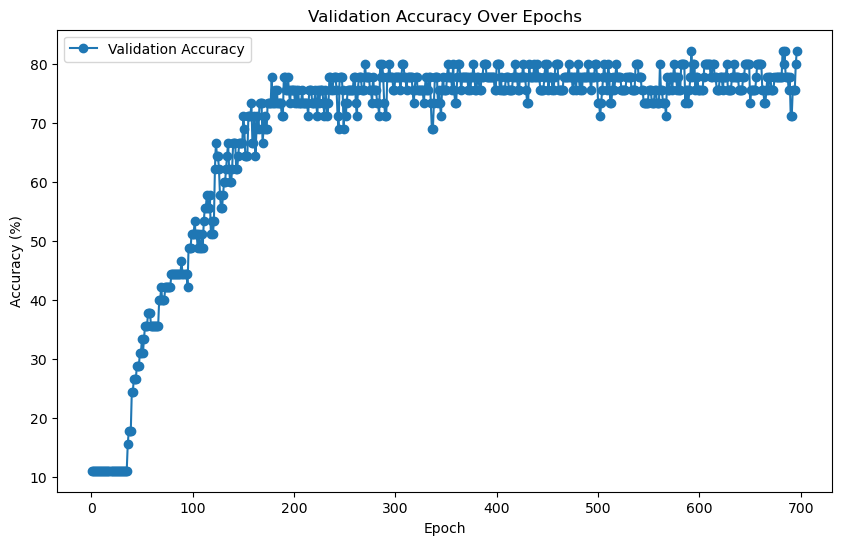


Evaluating on the test set...
    Test Batch [1/167], Loss: 1.1737



Final Test Loss: 1.1603, Test Accuracy: 67.31%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.


  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.


  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)

LOG: Training features shape: (45, 64), Training labels shape: (45,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42686, 64), Test labels shape: (42686,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 68.89%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.75      0.60      0.67         5
           2       0.43      0.60      0.50         5
           3       1.00      0.80      0.89         5
           4       1.00      0.60      0.75         5
           5       0.33      0.20      0.25         5
           6       0.75      0.60      0.67         5
           7       0.50      0.80      0.62         5
           8       1.00      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)
Train reps shape: (45, 64)
Train labels shape: (45,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42686, 64)
Test labels shape: (42686,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8407  |  Val Loss: 2.6760
Validation loss improved from inf to 2.6760.
[Epoch 2/1000] Train Loss: 2.6501  |  Val Loss: 2.5288
Validation loss improved from 2.6760 to 2.5288.
[Epoch 3/1000] Train Loss: 2.4833  |  Val Loss: 2.4076
Validation loss improved from 2.5288 to 2.4076.
[Epoch 4/1000] Train Loss: 2.3470  |  Val Loss: 2.3027
Validation loss improved from 2.4076 to 2.3027.
[Epoch 5/1000] Train Loss: 2.2310  |  Val Loss: 2.2200
Validation loss improved from 2.3027 to 2.2200.
[Epoch 6/1000] Train Loss: 2.1357  |  Val Loss: 2.1480
Validation loss improved from 2.2200 to 2.1480.
[Epoch 7/1000] Train Loss: 2.0530  |  Val Loss: 2.0878
Validation loss improved from 2.1480 to 2.0878.
[Epoch 8/1000] Train Loss: 1.9887  |  Val Loss: 2.0379
Validation loss improved from 2.0878 to 2.0379.
[Epoch 9/1000] Train Loss: 1.9313  |  Val Loss: 1.9959
Validation loss improved from 2.0379 to 1.9959.
[Epoch 10/1000] Train Loss: 1.8836  |  Val Loss: 1.9619
Validation loss impr

[Epoch 20/1000] Train Loss: 1.5187  |  Val Loss: 1.6616
Validation loss improved from 1.6886 to 1.6616.
[Epoch 21/1000] Train Loss: 1.4810  |  Val Loss: 1.6363
Validation loss improved from 1.6616 to 1.6363.
[Epoch 22/1000] Train Loss: 1.4433  |  Val Loss: 1.6106
Validation loss improved from 1.6363 to 1.6106.
[Epoch 23/1000] Train Loss: 1.4072  |  Val Loss: 1.5851
Validation loss improved from 1.6106 to 1.5851.
[Epoch 24/1000] Train Loss: 1.3715  |  Val Loss: 1.5602
Validation loss improved from 1.5851 to 1.5602.
[Epoch 25/1000] Train Loss: 1.3366  |  Val Loss: 1.5352
Validation loss improved from 1.5602 to 1.5352.
[Epoch 26/1000] Train Loss: 1.3018  |  Val Loss: 1.5110
Validation loss improved from 1.5352 to 1.5110.
[Epoch 27/1000] Train Loss: 1.2662  |  Val Loss: 1.4862
Validation loss improved from 1.5110 to 1.4862.
[Epoch 28/1000] Train Loss: 1.2303  |  Val Loss: 1.4602
Validation loss improved from 1.4862 to 1.4602.
[Epoch 29/1000] Train Loss: 1.1936  |  Val Loss: 1.4337
Validati

[Epoch 52/1000] Train Loss: 0.5296  |  Val Loss: 0.9994
Validation loss improved from 1.0074 to 0.9994.
[Epoch 53/1000] Train Loss: 0.5115  |  Val Loss: 0.9924
Validation loss improved from 0.9994 to 0.9924.
[Epoch 54/1000] Train Loss: 0.4945  |  Val Loss: 0.9853
Validation loss improved from 0.9924 to 0.9853.
[Epoch 55/1000] Train Loss: 0.4785  |  Val Loss: 0.9781
Validation loss improved from 0.9853 to 0.9781.
[Epoch 56/1000] Train Loss: 0.4630  |  Val Loss: 0.9707
Validation loss improved from 0.9781 to 0.9707.
[Epoch 57/1000] Train Loss: 0.4480  |  Val Loss: 0.9629
Validation loss improved from 0.9707 to 0.9629.
[Epoch 58/1000] Train Loss: 0.4336  |  Val Loss: 0.9552
Validation loss improved from 0.9629 to 0.9552.
[Epoch 59/1000] Train Loss: 0.4197  |  Val Loss: 0.9483
Validation loss improved from 0.9552 to 0.9483.
[Epoch 60/1000] Train Loss: 0.4062  |  Val Loss: 0.9426
Validation loss improved from 0.9483 to 0.9426.
[Epoch 61/1000] Train Loss: 0.3930  |  Val Loss: 0.9386
Validati

[Epoch 75/1000] Train Loss: 0.2609  |  Val Loss: 0.9282
Validation loss improved from 0.9292 to 0.9282.
[Epoch 76/1000] Train Loss: 0.2536  |  Val Loss: 0.9272
Validation loss improved from 0.9282 to 0.9272.
[Epoch 77/1000] Train Loss: 0.2465  |  Val Loss: 0.9281
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] Train Loss: 0.2399  |  Val Loss: 0.9312
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 79/1000] Train Loss: 0.2338  |  Val Loss: 0.9367
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 80/1000] Train Loss: 0.2277  |  Val Loss: 0.9439
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 81/1000] Train Loss: 0.2217  |  Val Loss: 0.9514
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 82/1000] Train Loss: 0.2158  |  Val Loss: 0.9586
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 83/1000] Train Loss: 0.2101  |  Val Loss: 0.9654
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 84/1000] Train 

[Epoch 99/1000] Train Loss: 0.1369  |  Val Loss: 1.0402
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 100/1000] Train Loss: 0.1332  |  Val Loss: 1.0455
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 101/1000] Train Loss: 0.1296  |  Val Loss: 1.0512
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 102/1000] Train Loss: 0.1262  |  Val Loss: 1.0561
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 103/1000] Train Loss: 0.1228  |  Val Loss: 1.0601
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 104/1000] Train Loss: 0.1195  |  Val Loss: 1.0646
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 105/1000] Train Loss: 0.1163  |  Val Loss: 1.0703
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 106/1000] Train Loss: 0.1131  |  Val Loss: 1.0774
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 107/1000] Train Loss: 0.1100  |  Val Loss: 1.0837
!! Validation loss did NOT improve !! Patience: 

[Epoch 129/1000] Train Loss: 0.0603  |  Val Loss: 1.2051
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 130/1000] Train Loss: 0.0587  |  Val Loss: 1.2130
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 131/1000] Train Loss: 0.0571  |  Val Loss: 1.2207
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 132/1000] Train Loss: 0.0556  |  Val Loss: 1.2275
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 133/1000] Train Loss: 0.0542  |  Val Loss: 1.2333
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 134/1000] Train Loss: 0.0527  |  Val Loss: 1.2380
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 135/1000] Train Loss: 0.0514  |  Val Loss: 1.2444
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 136/1000] Train Loss: 0.0500  |  Val Loss: 1.2521
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 137/1000] Train Loss: 0.0488  |  Val Loss: 1.2588
!! Validation loss did NOT improve !! Patience:

[Epoch 156/1000] Train Loss: 0.0304  |  Val Loss: 1.3735
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 157/1000] Train Loss: 0.0297  |  Val Loss: 1.3767
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 158/1000] Train Loss: 0.0290  |  Val Loss: 1.3805
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 159/1000] Train Loss: 0.0284  |  Val Loss: 1.3855
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 160/1000] Train Loss: 0.0277  |  Val Loss: 1.3914
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 161/1000] Train Loss: 0.0271  |  Val Loss: 1.3988
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 162/1000] Train Loss: 0.0264  |  Val Loss: 1.4053
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 163/1000] Train Loss: 0.0259  |  Val Loss: 1.4106
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 164/1000] Train Loss: 0.0253  |  Val Loss: 1.4146
!! Validation loss did NOT improve !! Patience:

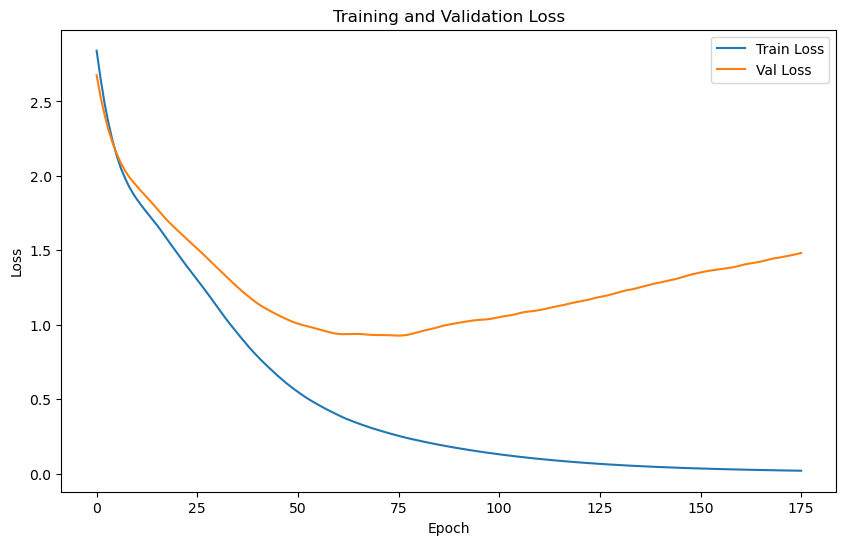

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.5685 | Test Accuracy: 51.31%


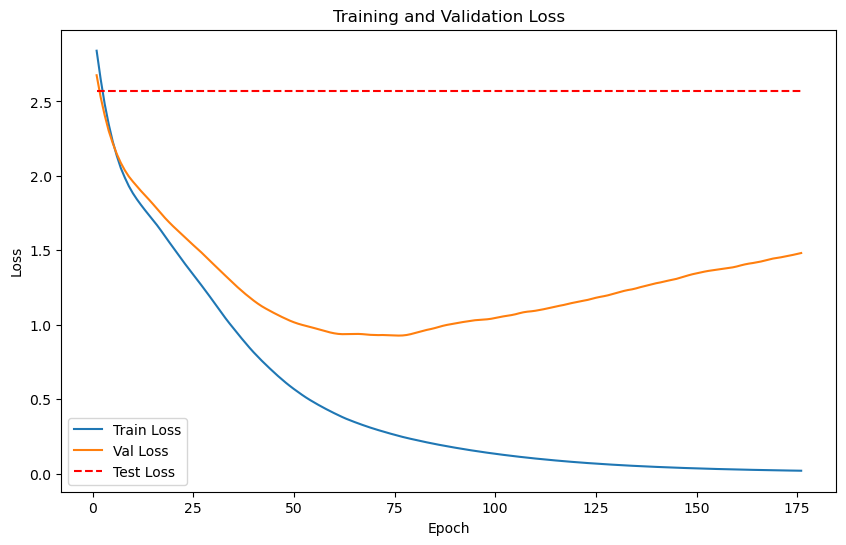

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.2484
Epoch [1/2000], Avg Train Loss: 8.2484
Epoch [1/2000], Avg Val Loss: 4.3437
Validation loss improved from inf to 4.3437. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.6142
Epoch [2/2000], Avg Train Loss: 8.6142
Epoch [2/2000], Avg Val Loss: 4.3104
Validation loss improved from 4.3437 to 4.3104. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.3252
Epoch [3/2000], Avg Train Loss: 8.3252
Epoch [3/2000], Avg Val Loss: 4.2774
Validation loss improved from 4.3104 to 4.2774. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9555
Epoch [4/2000], Avg Train Loss: 7.9555
Epoch [4/2000], Avg Val Loss: 4.2446
Validation loss improved from 4.2774 to 4.2446. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2894
Epoch [5/2000], Avg Train Loss: 8.2894
Epoch [5/2000], Avg Val Loss: 4.2126
Validation loss improved fr

    Batch [1/1], Train Loss: 7.2356
Epoch [11/2000], Avg Train Loss: 7.2356
Epoch [11/2000], Avg Val Loss: 4.0321
Validation loss improved from 4.0608 to 4.0321. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.6162
Epoch [12/2000], Avg Train Loss: 7.6162
Epoch [12/2000], Avg Val Loss: 4.0043
Validation loss improved from 4.0321 to 4.0043. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 7.4309
Epoch [13/2000], Avg Train Loss: 7.4309
Epoch [13/2000], Avg Val Loss: 3.9769
Validation loss improved from 4.0043 to 3.9769. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.9084
Epoch [14/2000], Avg Train Loss: 7.9084
Epoch [14/2000], Avg Val Loss: 3.9501
Validation loss improved from 3.9769 to 3.9501. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.7036
Epoch [15/2000], Avg Train Loss: 7.7036
Epoch [15/2000], Avg Val Loss: 3.9239
Validation loss improved from 3.9501 to 3.

    Batch [1/1], Train Loss: 6.4566
Epoch [29/2000], Avg Train Loss: 6.4566
Epoch [29/2000], Avg Val Loss: 3.6165
Validation loss improved from 3.6351 to 3.6165. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.7632
Epoch [30/2000], Avg Train Loss: 6.7632
Epoch [30/2000], Avg Val Loss: 3.5984
Validation loss improved from 3.6165 to 3.5984. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.4597
Epoch [31/2000], Avg Train Loss: 6.4597
Epoch [31/2000], Avg Val Loss: 3.5809
Validation loss improved from 3.5984 to 3.5809. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.2288
Epoch [32/2000], Avg Train Loss: 6.2288
Epoch [32/2000], Avg Val Loss: 3.5638
Validation loss improved from 3.5809 to 3.5638. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.4661
Epoch [33/2000], Avg Train Loss: 6.4661
Epoch [33/2000], Avg Val Loss: 3.5470
Validation loss improved from 3.5638 to 3.

    Batch [1/1], Train Loss: 5.7492
Epoch [56/2000], Avg Train Loss: 5.7492
Epoch [56/2000], Avg Val Loss: 3.2676
Validation loss improved from 3.2763 to 3.2676. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.2516
Epoch [57/2000], Avg Train Loss: 5.2516
Epoch [57/2000], Avg Val Loss: 3.2591
Validation loss improved from 3.2676 to 3.2591. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.0527
Epoch [58/2000], Avg Train Loss: 5.0527
Epoch [58/2000], Avg Val Loss: 3.2509
Validation loss improved from 3.2591 to 3.2509. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.3390
Epoch [59/2000], Avg Train Loss: 5.3390
Epoch [59/2000], Avg Val Loss: 3.2430
Validation loss improved from 3.2509 to 3.2430. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.0797
Epoch [60/2000], Avg Train Loss: 5.0797
Epoch [60/2000], Avg Val Loss: 3.2354
Validation loss improved from 3.2430 to 3.

    Batch [1/1], Train Loss: 5.1057
Epoch [75/2000], Avg Train Loss: 5.1057
Epoch [75/2000], Avg Val Loss: 3.1441
Validation loss improved from 3.1490 to 3.1441. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 4.5531
Epoch [76/2000], Avg Train Loss: 4.5531
Epoch [76/2000], Avg Val Loss: 3.1394
Validation loss improved from 3.1441 to 3.1394. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.1222
Epoch [77/2000], Avg Train Loss: 5.1222
Epoch [77/2000], Avg Val Loss: 3.1349
Validation loss improved from 3.1394 to 3.1349. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 4.7694
Epoch [78/2000], Avg Train Loss: 4.7694
Epoch [78/2000], Avg Val Loss: 3.1305
Validation loss improved from 3.1349 to 3.1305. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 4.8585
Epoch [79/2000], Avg Train Loss: 4.8585
Epoch [79/2000], Avg Val Loss: 3.1261
Validation loss improved from 3.1305 to 3.

    Batch [1/1], Train Loss: 4.0868
Epoch [105/2000], Avg Train Loss: 4.0868
Epoch [105/2000], Avg Val Loss: 3.0496
Validation loss improved from 3.0516 to 3.0496. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 4.0209
Epoch [106/2000], Avg Train Loss: 4.0209
Epoch [106/2000], Avg Val Loss: 3.0476
Validation loss improved from 3.0496 to 3.0476. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 4.2429
Epoch [107/2000], Avg Train Loss: 4.2429
Epoch [107/2000], Avg Val Loss: 3.0457
Validation loss improved from 3.0476 to 3.0457. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 3.9700
Epoch [108/2000], Avg Train Loss: 3.9700
Epoch [108/2000], Avg Val Loss: 3.0439
Validation loss improved from 3.0457 to 3.0439. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.0119
Epoch [109/2000], Avg Train Loss: 4.0119
Epoch [109/2000], Avg Val Loss: 3.0420
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8967
Epoch [125/2000], Avg Train Loss: 3.8967
Epoch [125/2000], Avg Val Loss: 3.0178
Validation loss improved from 3.0191 to 3.0178. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 3.9490
Epoch [126/2000], Avg Train Loss: 3.9490
Epoch [126/2000], Avg Val Loss: 3.0166
Validation loss improved from 3.0178 to 3.0166. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 3.7887
Epoch [127/2000], Avg Train Loss: 3.7887
Epoch [127/2000], Avg Val Loss: 3.0154
Validation loss improved from 3.0166 to 3.0154. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 3.9921
Epoch [128/2000], Avg Train Loss: 3.9921
Epoch [128/2000], Avg Val Loss: 3.0142
Validation loss improved from 3.0154 to 3.0142. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 3.8806
Epoch [129/2000], Avg Train Loss: 3.8806
Epoch [129/2000], Avg Val Loss: 3.0130
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7838
Epoch [157/2000], Avg Train Loss: 3.7838
Epoch [157/2000], Avg Val Loss: 2.9883
Validation loss improved from 2.9890 to 2.9883. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 3.6641
Epoch [158/2000], Avg Train Loss: 3.6641
Epoch [158/2000], Avg Val Loss: 2.9876
Validation loss improved from 2.9883 to 2.9876. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 3.7415
Epoch [159/2000], Avg Train Loss: 3.7415
Epoch [159/2000], Avg Val Loss: 2.9869
Validation loss improved from 2.9876 to 2.9869. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 3.6570
Epoch [160/2000], Avg Train Loss: 3.6570
Epoch [160/2000], Avg Val Loss: 2.9861
Validation loss improved from 2.9869 to 2.9861. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 3.6600
Epoch [161/2000], Avg Train Loss: 3.6600
Epoch [161/2000], Avg Val Loss: 2.9855
Validation loss improved fro

Epoch [176/2000], Avg Val Loss: 2.9750
Validation loss improved from 2.9757 to 2.9750. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 3.5456
Epoch [177/2000], Avg Train Loss: 3.5456
Epoch [177/2000], Avg Val Loss: 2.9743
Validation loss improved from 2.9750 to 2.9743. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 3.6185
Epoch [178/2000], Avg Train Loss: 3.6185
Epoch [178/2000], Avg Val Loss: 2.9736
Validation loss improved from 2.9743 to 2.9736. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 3.7640
Epoch [179/2000], Avg Train Loss: 3.7640
Epoch [179/2000], Avg Val Loss: 2.9729
Validation loss improved from 2.9736 to 2.9729. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 3.5856
Epoch [180/2000], Avg Train Loss: 3.5856
Epoch [180/2000], Avg Val Loss: 2.9722
Validation loss improved from 2.9729 to 2.9722. Saving model...

LOG: Epoch [181/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4487
Epoch [207/2000], Avg Train Loss: 3.4487
Epoch [207/2000], Avg Val Loss: 2.9541
Validation loss improved from 2.9548 to 2.9541. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 3.5473
Epoch [208/2000], Avg Train Loss: 3.5473
Epoch [208/2000], Avg Val Loss: 2.9535
Validation loss improved from 2.9541 to 2.9535. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 3.3917
Epoch [209/2000], Avg Train Loss: 3.3917
Epoch [209/2000], Avg Val Loss: 2.9529
Validation loss improved from 2.9535 to 2.9529. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 3.4494
Epoch [210/2000], Avg Train Loss: 3.4494
Epoch [210/2000], Avg Val Loss: 2.9523
Validation loss improved from 2.9529 to 2.9523. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 3.3643
Epoch [211/2000], Avg Train Loss: 3.3643
Epoch [211/2000], Avg Val Loss: 2.9516
Validation loss improved fro

Epoch [228/2000], Avg Val Loss: 2.9403
Validation loss improved from 2.9410 to 2.9403. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 3.3829
Epoch [229/2000], Avg Train Loss: 3.3829
Epoch [229/2000], Avg Val Loss: 2.9396
Validation loss improved from 2.9403 to 2.9396. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 3.4095
Epoch [230/2000], Avg Train Loss: 3.4095
Epoch [230/2000], Avg Val Loss: 2.9390
Validation loss improved from 2.9396 to 2.9390. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 3.4501
Epoch [231/2000], Avg Train Loss: 3.4501
Epoch [231/2000], Avg Val Loss: 2.9383
Validation loss improved from 2.9390 to 2.9383. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 3.5335
Epoch [232/2000], Avg Train Loss: 3.5335
Epoch [232/2000], Avg Val Loss: 2.9377
Validation loss improved from 2.9383 to 2.9377. Saving model...

LOG: Epoch [233/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3779
Epoch [258/2000], Avg Train Loss: 3.3779
Epoch [258/2000], Avg Val Loss: 2.9174
Validation loss improved from 2.9182 to 2.9174. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 3.1994
Epoch [259/2000], Avg Train Loss: 3.1994
Epoch [259/2000], Avg Val Loss: 2.9166
Validation loss improved from 2.9174 to 2.9166. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 3.3132
Epoch [260/2000], Avg Train Loss: 3.3132
Epoch [260/2000], Avg Val Loss: 2.9158
Validation loss improved from 2.9166 to 2.9158. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 3.3403
Epoch [261/2000], Avg Train Loss: 3.3403
Epoch [261/2000], Avg Val Loss: 2.9150
Validation loss improved from 2.9158 to 2.9150. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 3.1911
Epoch [262/2000], Avg Train Loss: 3.1911
Epoch [262/2000], Avg Val Loss: 2.9142
Validation loss improved fro

Epoch [278/2000], Avg Val Loss: 2.9025
Validation loss improved from 2.9033 to 2.9025. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 3.1848
Epoch [279/2000], Avg Train Loss: 3.1848
Epoch [279/2000], Avg Val Loss: 2.9017
Validation loss improved from 2.9025 to 2.9017. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.1941
Epoch [280/2000], Avg Train Loss: 3.1941
Epoch [280/2000], Avg Val Loss: 2.9010
Validation loss improved from 2.9017 to 2.9010. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.1809
Epoch [281/2000], Avg Train Loss: 3.1809
Epoch [281/2000], Avg Val Loss: 2.9002
Validation loss improved from 2.9010 to 2.9002. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.1666
Epoch [282/2000], Avg Train Loss: 3.1666
Epoch [282/2000], Avg Val Loss: 2.8995
Validation loss improved from 2.9002 to 2.8995. Saving model...

LOG: Epoch [283/2000] - Training
    Bat

Epoch [305/2000], Avg Val Loss: 2.8811
Validation loss improved from 2.8819 to 2.8811. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 2.9633
Epoch [306/2000], Avg Train Loss: 2.9633
Epoch [306/2000], Avg Val Loss: 2.8803
Validation loss improved from 2.8811 to 2.8803. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 3.1992
Epoch [307/2000], Avg Train Loss: 3.1992
Epoch [307/2000], Avg Val Loss: 2.8795
Validation loss improved from 2.8803 to 2.8795. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 3.0621
Epoch [308/2000], Avg Train Loss: 3.0621
Epoch [308/2000], Avg Val Loss: 2.8787
Validation loss improved from 2.8795 to 2.8787. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 3.1011
Epoch [309/2000], Avg Train Loss: 3.1011
Epoch [309/2000], Avg Val Loss: 2.8780
Validation loss improved from 2.8787 to 2.8780. Saving model...

LOG: Epoch [310/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1364
Epoch [325/2000], Avg Train Loss: 3.1364
Epoch [325/2000], Avg Val Loss: 2.8652
Validation loss improved from 2.8660 to 2.8652. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 3.0881
Epoch [326/2000], Avg Train Loss: 3.0881
Epoch [326/2000], Avg Val Loss: 2.8644
Validation loss improved from 2.8652 to 2.8644. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 3.1006
Epoch [327/2000], Avg Train Loss: 3.1006
Epoch [327/2000], Avg Val Loss: 2.8636
Validation loss improved from 2.8644 to 2.8636. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 2.9493
Epoch [328/2000], Avg Train Loss: 2.9493
Epoch [328/2000], Avg Val Loss: 2.8628
Validation loss improved from 2.8636 to 2.8628. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 3.0470
Epoch [329/2000], Avg Train Loss: 3.0470
Epoch [329/2000], Avg Val Loss: 2.8619
Validation loss improved fro

Epoch [354/2000], Avg Val Loss: 2.8424
Validation loss improved from 2.8432 to 2.8424. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 3.1021
Epoch [355/2000], Avg Train Loss: 3.1021
Epoch [355/2000], Avg Val Loss: 2.8417
Validation loss improved from 2.8424 to 2.8417. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.1259
Epoch [356/2000], Avg Train Loss: 3.1259
Epoch [356/2000], Avg Val Loss: 2.8410
Validation loss improved from 2.8417 to 2.8410. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 2.9867
Epoch [357/2000], Avg Train Loss: 2.9867
Epoch [357/2000], Avg Val Loss: 2.8403
Validation loss improved from 2.8410 to 2.8403. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 3.0595
Epoch [358/2000], Avg Train Loss: 3.0595
Epoch [358/2000], Avg Val Loss: 2.8395
Validation loss improved from 2.8403 to 2.8395. Saving model...

LOG: Epoch [359/2000] - Training
    Bat

Epoch [380/2000], Avg Val Loss: 2.8222
Validation loss improved from 2.8230 to 2.8222. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.0152
Epoch [381/2000], Avg Train Loss: 3.0152
Epoch [381/2000], Avg Val Loss: 2.8214
Validation loss improved from 2.8222 to 2.8214. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 2.9670
Epoch [382/2000], Avg Train Loss: 2.9670
Epoch [382/2000], Avg Val Loss: 2.8206
Validation loss improved from 2.8214 to 2.8206. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 2.9842
Epoch [383/2000], Avg Train Loss: 2.9842
Epoch [383/2000], Avg Val Loss: 2.8198
Validation loss improved from 2.8206 to 2.8198. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 2.9720
Epoch [384/2000], Avg Train Loss: 2.9720
Epoch [384/2000], Avg Val Loss: 2.8191
Validation loss improved from 2.8198 to 2.8191. Saving model...

LOG: Epoch [385/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.9478
Epoch [403/2000], Avg Train Loss: 2.9478
Epoch [403/2000], Avg Val Loss: 2.8045
Validation loss improved from 2.8053 to 2.8045. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 2.7901
Epoch [404/2000], Avg Train Loss: 2.7901
Epoch [404/2000], Avg Val Loss: 2.8037
Validation loss improved from 2.8045 to 2.8037. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 2.9870
Epoch [405/2000], Avg Train Loss: 2.9870
Epoch [405/2000], Avg Val Loss: 2.8030
Validation loss improved from 2.8037 to 2.8030. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 2.8745
Epoch [406/2000], Avg Train Loss: 2.8745
Epoch [406/2000], Avg Val Loss: 2.8022
Validation loss improved from 2.8030 to 2.8022. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 2.9841
Epoch [407/2000], Avg Train Loss: 2.9841
Epoch [407/2000], Avg Val Loss: 2.8015
Validation loss improved fro

Epoch [425/2000], Avg Val Loss: 2.7888
Validation loss improved from 2.7896 to 2.7888. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 2.8342
Epoch [426/2000], Avg Train Loss: 2.8342
Epoch [426/2000], Avg Val Loss: 2.7881
Validation loss improved from 2.7888 to 2.7881. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 2.8519
Epoch [427/2000], Avg Train Loss: 2.8519
Epoch [427/2000], Avg Val Loss: 2.7874
Validation loss improved from 2.7881 to 2.7874. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 2.8869
Epoch [428/2000], Avg Train Loss: 2.8869
Epoch [428/2000], Avg Val Loss: 2.7867
Validation loss improved from 2.7874 to 2.7867. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 2.7608
Epoch [429/2000], Avg Train Loss: 2.7608
Epoch [429/2000], Avg Val Loss: 2.7859
Validation loss improved from 2.7867 to 2.7859. Saving model...

LOG: Epoch [430/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8295
Epoch [451/2000], Avg Train Loss: 2.8295
Epoch [451/2000], Avg Val Loss: 2.7714
Validation loss improved from 2.7719 to 2.7714. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 2.9003
Epoch [452/2000], Avg Train Loss: 2.9003
Epoch [452/2000], Avg Val Loss: 2.7708
Validation loss improved from 2.7714 to 2.7708. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 2.8127
Epoch [453/2000], Avg Train Loss: 2.8127
Epoch [453/2000], Avg Val Loss: 2.7702
Validation loss improved from 2.7708 to 2.7702. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 2.8284
Epoch [454/2000], Avg Train Loss: 2.8284
Epoch [454/2000], Avg Val Loss: 2.7697
Validation loss improved from 2.7702 to 2.7697. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 2.8645
Epoch [455/2000], Avg Train Loss: 2.8645
Epoch [455/2000], Avg Val Loss: 2.7691
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7600
Epoch [476/2000], Avg Train Loss: 2.7600
Epoch [476/2000], Avg Val Loss: 2.7576
Validation loss improved from 2.7581 to 2.7576. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 2.8389
Epoch [477/2000], Avg Train Loss: 2.8389
Epoch [477/2000], Avg Val Loss: 2.7570
Validation loss improved from 2.7576 to 2.7570. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 2.8002
Epoch [478/2000], Avg Train Loss: 2.8002
Epoch [478/2000], Avg Val Loss: 2.7565
Validation loss improved from 2.7570 to 2.7565. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 2.7831
Epoch [479/2000], Avg Train Loss: 2.7831
Epoch [479/2000], Avg Val Loss: 2.7560
Validation loss improved from 2.7565 to 2.7560. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 2.8179
Epoch [480/2000], Avg Train Loss: 2.8179
Epoch [480/2000], Avg Val Loss: 2.7555
Validation loss improved fro

Epoch [500/2000], Avg Val Loss: 2.7463
Validation loss improved from 2.7468 to 2.7463. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 2.7872
Epoch [501/2000], Avg Train Loss: 2.7872
Epoch [501/2000], Avg Val Loss: 2.7459
Validation loss improved from 2.7463 to 2.7459. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 2.7674
Epoch [502/2000], Avg Train Loss: 2.7674
Epoch [502/2000], Avg Val Loss: 2.7454
Validation loss improved from 2.7459 to 2.7454. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 2.8174
Epoch [503/2000], Avg Train Loss: 2.8174
Epoch [503/2000], Avg Val Loss: 2.7450
Validation loss improved from 2.7454 to 2.7450. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 2.7451
Epoch [504/2000], Avg Train Loss: 2.7451
Epoch [504/2000], Avg Val Loss: 2.7445
Validation loss improved from 2.7450 to 2.7445. Saving model...

LOG: Epoch [505/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6937
Epoch [522/2000], Avg Train Loss: 2.6937
Epoch [522/2000], Avg Val Loss: 2.7373
Validation loss improved from 2.7377 to 2.7373. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 2.7319
Epoch [523/2000], Avg Train Loss: 2.7319
Epoch [523/2000], Avg Val Loss: 2.7368
Validation loss improved from 2.7373 to 2.7368. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 2.7360
Epoch [524/2000], Avg Train Loss: 2.7360
Epoch [524/2000], Avg Val Loss: 2.7364
Validation loss improved from 2.7368 to 2.7364. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 2.7847
Epoch [525/2000], Avg Train Loss: 2.7847
Epoch [525/2000], Avg Val Loss: 2.7359
Validation loss improved from 2.7364 to 2.7359. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 2.7021
Epoch [526/2000], Avg Train Loss: 2.7021
Epoch [526/2000], Avg Val Loss: 2.7354
Validation loss improved fro

Epoch [549/2000], Avg Val Loss: 2.7250
Validation loss improved from 2.7254 to 2.7250. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 2.7429
Epoch [550/2000], Avg Train Loss: 2.7429
Epoch [550/2000], Avg Val Loss: 2.7245
Validation loss improved from 2.7250 to 2.7245. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 2.7523
Epoch [551/2000], Avg Train Loss: 2.7523
Epoch [551/2000], Avg Val Loss: 2.7241
Validation loss improved from 2.7245 to 2.7241. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 2.6901
Epoch [552/2000], Avg Train Loss: 2.6901
Epoch [552/2000], Avg Val Loss: 2.7237
Validation loss improved from 2.7241 to 2.7237. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 2.7653
Epoch [553/2000], Avg Train Loss: 2.7653
Epoch [553/2000], Avg Val Loss: 2.7233
Validation loss improved from 2.7237 to 2.7233. Saving model...

LOG: Epoch [554/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.7057
Epoch [572/2000], Avg Train Loss: 2.7057
Epoch [572/2000], Avg Val Loss: 2.7163
Validation loss improved from 2.7166 to 2.7163. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 2.6686
Epoch [573/2000], Avg Train Loss: 2.6686
Epoch [573/2000], Avg Val Loss: 2.7160
Validation loss improved from 2.7163 to 2.7160. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 2.6971
Epoch [574/2000], Avg Train Loss: 2.6971
Epoch [574/2000], Avg Val Loss: 2.7156
Validation loss improved from 2.7160 to 2.7156. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 2.5966
Epoch [575/2000], Avg Train Loss: 2.5966
Epoch [575/2000], Avg Val Loss: 2.7152
Validation loss improved from 2.7156 to 2.7152. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 2.6204
Epoch [576/2000], Avg Train Loss: 2.6204
Epoch [576/2000], Avg Val Loss: 2.7148
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6484
Epoch [598/2000], Avg Train Loss: 2.6484
Epoch [598/2000], Avg Val Loss: 2.7075
Validation loss improved from 2.7078 to 2.7075. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 2.6748
Epoch [599/2000], Avg Train Loss: 2.6748
Epoch [599/2000], Avg Val Loss: 2.7071
Validation loss improved from 2.7075 to 2.7071. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 2.6751
Epoch [600/2000], Avg Train Loss: 2.6751
Epoch [600/2000], Avg Val Loss: 2.7068
Validation loss improved from 2.7071 to 2.7068. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 2.5722
Epoch [601/2000], Avg Train Loss: 2.5722
Epoch [601/2000], Avg Val Loss: 2.7064
Validation loss improved from 2.7068 to 2.7064. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 2.5922
Epoch [602/2000], Avg Train Loss: 2.5922
Epoch [602/2000], Avg Val Loss: 2.7060
Validation loss improved fro

    Batch [1/1], Train Loss: 2.5802
Epoch [622/2000], Avg Train Loss: 2.5802
Epoch [622/2000], Avg Val Loss: 2.6995
Validation loss improved from 2.6998 to 2.6995. Saving model...

LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 2.6245
Epoch [623/2000], Avg Train Loss: 2.6245
Epoch [623/2000], Avg Val Loss: 2.6992
Validation loss improved from 2.6995 to 2.6992. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 2.6095
Epoch [624/2000], Avg Train Loss: 2.6095
Epoch [624/2000], Avg Val Loss: 2.6989
Validation loss improved from 2.6992 to 2.6989. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 2.6780
Epoch [625/2000], Avg Train Loss: 2.6780
Epoch [625/2000], Avg Val Loss: 2.6987
Validation loss improved from 2.6989 to 2.6987. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 2.6901
Epoch [626/2000], Avg Train Loss: 2.6901
Epoch [626/2000], Avg Val Loss: 2.6984
Validation loss improved fro

Epoch [643/2000], Avg Val Loss: 2.6939
Validation loss improved from 2.6942 to 2.6939. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 2.7210
Epoch [644/2000], Avg Train Loss: 2.7210
Epoch [644/2000], Avg Val Loss: 2.6937
Validation loss improved from 2.6939 to 2.6937. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 2.5798
Epoch [645/2000], Avg Train Loss: 2.5798
Epoch [645/2000], Avg Val Loss: 2.6934
Validation loss improved from 2.6937 to 2.6934. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 2.5990
Epoch [646/2000], Avg Train Loss: 2.5990
Epoch [646/2000], Avg Val Loss: 2.6931
Validation loss improved from 2.6934 to 2.6931. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 2.5615
Epoch [647/2000], Avg Train Loss: 2.5615
Epoch [647/2000], Avg Val Loss: 2.6929
Validation loss improved from 2.6931 to 2.6929. Saving model...

LOG: Epoch [648/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5962
Epoch [674/2000], Avg Train Loss: 2.5962
Epoch [674/2000], Avg Val Loss: 2.6869
Validation loss improved from 2.6871 to 2.6869. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 2.5527
Epoch [675/2000], Avg Train Loss: 2.5527
Epoch [675/2000], Avg Val Loss: 2.6867
Validation loss improved from 2.6869 to 2.6867. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 2.5877
Epoch [676/2000], Avg Train Loss: 2.5877
Epoch [676/2000], Avg Val Loss: 2.6866
Validation loss improved from 2.6867 to 2.6866. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 2.5125
Epoch [677/2000], Avg Train Loss: 2.5125
Epoch [677/2000], Avg Val Loss: 2.6864
Validation loss improved from 2.6866 to 2.6864. Saving model...

LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 2.6186
Epoch [678/2000], Avg Train Loss: 2.6186
Epoch [678/2000], Avg Val Loss: 2.6862
Validation loss improved fro

Epoch [696/2000], Avg Val Loss: 2.6822
Validation loss improved from 2.6824 to 2.6822. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 2.5686
Epoch [697/2000], Avg Train Loss: 2.5686
Epoch [697/2000], Avg Val Loss: 2.6820
Validation loss improved from 2.6822 to 2.6820. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 2.5932
Epoch [698/2000], Avg Train Loss: 2.5932
Epoch [698/2000], Avg Val Loss: 2.6817
Validation loss improved from 2.6820 to 2.6817. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 2.5294
Epoch [699/2000], Avg Train Loss: 2.5294
Epoch [699/2000], Avg Val Loss: 2.6815
Validation loss improved from 2.6817 to 2.6815. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 2.5085
Epoch [700/2000], Avg Train Loss: 2.5085
Epoch [700/2000], Avg Val Loss: 2.6813
Validation loss improved from 2.6815 to 2.6813. Saving model...

LOG: Epoch [701/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.5671
Epoch [726/2000], Avg Train Loss: 2.5671
Epoch [726/2000], Avg Val Loss: 2.6787
Validation loss improved from 2.6788 to 2.6787. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 2.4672
Epoch [727/2000], Avg Train Loss: 2.4672
Epoch [727/2000], Avg Val Loss: 2.6786
Validation loss improved from 2.6787 to 2.6786. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 2.5289
Epoch [728/2000], Avg Train Loss: 2.5289
Epoch [728/2000], Avg Val Loss: 2.6786
Validation loss improved from 2.6786 to 2.6786. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 2.4679
Epoch [729/2000], Avg Train Loss: 2.4679
Epoch [729/2000], Avg Val Loss: 2.6785
Validation loss improved from 2.6786 to 2.6785. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 2.5200
Epoch [730/2000], Avg Train Loss: 2.5200
Epoch [730/2000], Avg Val Loss: 2.6785
Validation loss improved fro

Epoch [744/2000], Avg Val Loss: 2.6777
Validation loss improved from 2.6778 to 2.6777. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 2.5154
Epoch [745/2000], Avg Train Loss: 2.5154
Epoch [745/2000], Avg Val Loss: 2.6776
Validation loss improved from 2.6777 to 2.6776. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 2.4260
Epoch [746/2000], Avg Train Loss: 2.4260
Epoch [746/2000], Avg Val Loss: 2.6775
Validation loss improved from 2.6776 to 2.6775. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 2.5732
Epoch [747/2000], Avg Train Loss: 2.5732
Epoch [747/2000], Avg Val Loss: 2.6775
Validation loss improved from 2.6775 to 2.6775. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 2.5766
Epoch [748/2000], Avg Train Loss: 2.5766
Epoch [748/2000], Avg Val Loss: 2.6774
Validation loss improved from 2.6775 to 2.6774. Saving model...

LOG: Epoch [749/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.4509
Epoch [775/2000], Avg Train Loss: 2.4509
Epoch [775/2000], Avg Val Loss: 2.6763
Validation loss improved from 2.6763 to 2.6763. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 2.5284
Epoch [776/2000], Avg Train Loss: 2.5284
Epoch [776/2000], Avg Val Loss: 2.6763
Validation loss improved from 2.6763 to 2.6763. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 2.4646
Epoch [777/2000], Avg Train Loss: 2.4646
Epoch [777/2000], Avg Val Loss: 2.6763
Validation loss improved from 2.6763 to 2.6763. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 2.4993
Epoch [778/2000], Avg Train Loss: 2.4993
Epoch [778/2000], Avg Val Loss: 2.6762
Validation loss improved from 2.6763 to 2.6762. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 2.4268
Epoch [779/2000], Avg Train Loss: 2.4268
Epoch [779/2000], Avg Val Loss: 2.6762
Validation loss improved fro

    Batch [1/1], Train Loss: 2.4376
Epoch [788/2000], Avg Train Loss: 2.4376
Epoch [788/2000], Avg Val Loss: 2.6754
Validation loss improved from 2.6756 to 2.6754. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 2.4159
Epoch [789/2000], Avg Train Loss: 2.4159
Epoch [789/2000], Avg Val Loss: 2.6752
Validation loss improved from 2.6754 to 2.6752. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 2.4814
Epoch [790/2000], Avg Train Loss: 2.4814
Epoch [790/2000], Avg Val Loss: 2.6750
Validation loss improved from 2.6752 to 2.6750. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 2.5237
Epoch [791/2000], Avg Train Loss: 2.5237
Epoch [791/2000], Avg Val Loss: 2.6749
Validation loss improved from 2.6750 to 2.6749. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 2.4458
Epoch [792/2000], Avg Train Loss: 2.4458
Epoch [792/2000], Avg Val Loss: 2.6747
Validation loss improved fro

Epoch [824/2000], Avg Train Loss: 2.3937
Epoch [824/2000], Avg Val Loss: 2.6726
Validation loss improved from 2.6727 to 2.6726. Saving model...

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 2.4307
Epoch [825/2000], Avg Train Loss: 2.4307
Epoch [825/2000], Avg Val Loss: 2.6726
Validation loss improved from 2.6726 to 2.6726. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 2.4850
Epoch [826/2000], Avg Train Loss: 2.4850
Epoch [826/2000], Avg Val Loss: 2.6725
Validation loss improved from 2.6726 to 2.6725. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 2.4267
Epoch [827/2000], Avg Train Loss: 2.4267
Epoch [827/2000], Avg Val Loss: 2.6724
Validation loss improved from 2.6725 to 2.6724. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 2.4132
Epoch [828/2000], Avg Train Loss: 2.4132
Epoch [828/2000], Avg Val Loss: 2.6723
Validation loss improved from 2.6724 to 2.6723. Saving model...


    Batch [1/1], Train Loss: 2.3900
Epoch [835/2000], Avg Train Loss: 2.3900
Epoch [835/2000], Avg Val Loss: 2.6716
Validation loss improved from 2.6717 to 2.6716. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 2.4930
Epoch [836/2000], Avg Train Loss: 2.4930
Epoch [836/2000], Avg Val Loss: 2.6715
Validation loss improved from 2.6716 to 2.6715. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 2.4500
Epoch [837/2000], Avg Train Loss: 2.4500
Epoch [837/2000], Avg Val Loss: 2.6714
Validation loss improved from 2.6715 to 2.6714. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 2.4169
Epoch [838/2000], Avg Train Loss: 2.4169
Epoch [838/2000], Avg Val Loss: 2.6712
Validation loss improved from 2.6714 to 2.6712. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 2.4129
Epoch [839/2000], Avg Train Loss: 2.4129
Epoch [839/2000], Avg Val Loss: 2.6711
Validation loss improved fro

    Batch [1/1], Train Loss: 2.3514
Epoch [873/2000], Avg Train Loss: 2.3514
Epoch [873/2000], Avg Val Loss: 2.6710
Validation loss did not improve. Patience: 22/100

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 2.4073
Epoch [874/2000], Avg Train Loss: 2.4073
Epoch [874/2000], Avg Val Loss: 2.6710
Validation loss did not improve. Patience: 23/100

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 2.4163
Epoch [875/2000], Avg Train Loss: 2.4163
Epoch [875/2000], Avg Val Loss: 2.6709
Validation loss did not improve. Patience: 24/100

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 2.4089
Epoch [876/2000], Avg Train Loss: 2.4089
Epoch [876/2000], Avg Val Loss: 2.6708
Validation loss did not improve. Patience: 25/100

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 2.4119
Epoch [877/2000], Avg Train Loss: 2.4119
Epoch [877/2000], Avg Val Loss: 2.6708
Validation loss did not improve. Patience: 26/100

LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 2.3297
Epoch [883/2000], Avg Train Loss: 2.3297
Epoch [883/2000], Avg Val Loss: 2.6710
Validation loss did not improve. Patience: 32/100

LOG: Epoch [884/2000] - Training
    Batch [1/1], Train Loss: 2.3997
Epoch [884/2000], Avg Train Loss: 2.3997
Epoch [884/2000], Avg Val Loss: 2.6711
Validation loss did not improve. Patience: 33/100

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 2.3866
Epoch [885/2000], Avg Train Loss: 2.3866
Epoch [885/2000], Avg Val Loss: 2.6712
Validation loss did not improve. Patience: 34/100

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 2.4129
Epoch [886/2000], Avg Train Loss: 2.4129
Epoch [886/2000], Avg Val Loss: 2.6712
Validation loss did not improve. Patience: 35/100

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 2.3472
Epoch [887/2000], Avg Train Loss: 2.3472
Epoch [887/2000], Avg Val Loss: 2.6712
Validation loss did not improve. Patience: 36/100

LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 2.3648
Epoch [920/2000], Avg Train Loss: 2.3648
Epoch [920/2000], Avg Val Loss: 2.6739
Validation loss did not improve. Patience: 69/100

LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 2.3747
Epoch [921/2000], Avg Train Loss: 2.3747
Epoch [921/2000], Avg Val Loss: 2.6741
Validation loss did not improve. Patience: 70/100

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 2.3790
Epoch [922/2000], Avg Train Loss: 2.3790
Epoch [922/2000], Avg Val Loss: 2.6743
Validation loss did not improve. Patience: 71/100

LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 2.3388
Epoch [923/2000], Avg Train Loss: 2.3388
Epoch [923/2000], Avg Val Loss: 2.6744
Validation loss did not improve. Patience: 72/100

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 2.3156
Epoch [924/2000], Avg Train Loss: 2.3156
Epoch [924/2000], Avg Val Loss: 2.6745
Validation loss did not improve. Patience: 73/100

LOG: Epoch [925/2000] - Training


Epoch [929/2000], Avg Train Loss: 2.3160
Epoch [929/2000], Avg Val Loss: 2.6745
Validation loss did not improve. Patience: 78/100

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 2.3766
Epoch [930/2000], Avg Train Loss: 2.3766
Epoch [930/2000], Avg Val Loss: 2.6745
Validation loss did not improve. Patience: 79/100

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 2.3433
Epoch [931/2000], Avg Train Loss: 2.3433
Epoch [931/2000], Avg Val Loss: 2.6745
Validation loss did not improve. Patience: 80/100

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 2.2916
Epoch [932/2000], Avg Train Loss: 2.2916
Epoch [932/2000], Avg Val Loss: 2.6745
Validation loss did not improve. Patience: 81/100

LOG: Epoch [933/2000] - Training
    Batch [1/1], Train Loss: 2.4040
Epoch [933/2000], Avg Train Loss: 2.4040
Epoch [933/2000], Avg Val Loss: 2.6745
Validation loss did not improve. Patience: 82/100

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 2.3904


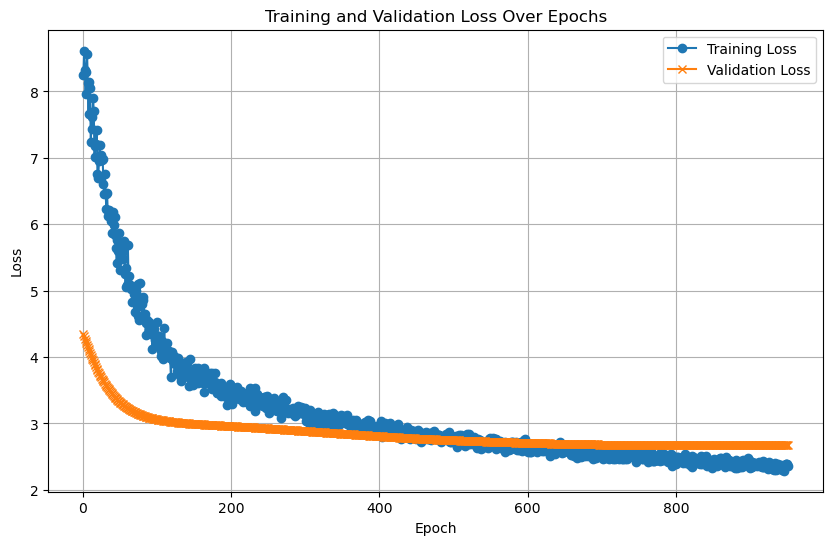

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 4.2275
Test Batch [20/167], Loss: 4.3661
Test Batch [30/167], Loss: 4.4572
Test Batch [40/167], Loss: 4.5026
Test Batch [50/167], Loss: 4.3541
Test Batch [60/167], Loss: 4.0343
Test Batch [70/167], Loss: 4.1385
Test Batch [80/167], Loss: 4.9357
Test Batch [90/167], Loss: 5.0312
Test Batch [100/167], Loss: 5.0533
Test Batch [110/167], Loss: 4.5898
Test Batch [120/167], Loss: 4.5102
Test Batch [130/167], Loss: 4.7671
Test Batch [140/167], Loss: 4.5981
Test Batch [150/167], Loss: 5.1151
Test Batch [160/167], Loss: 5.6165



Test Loss: 4.6403


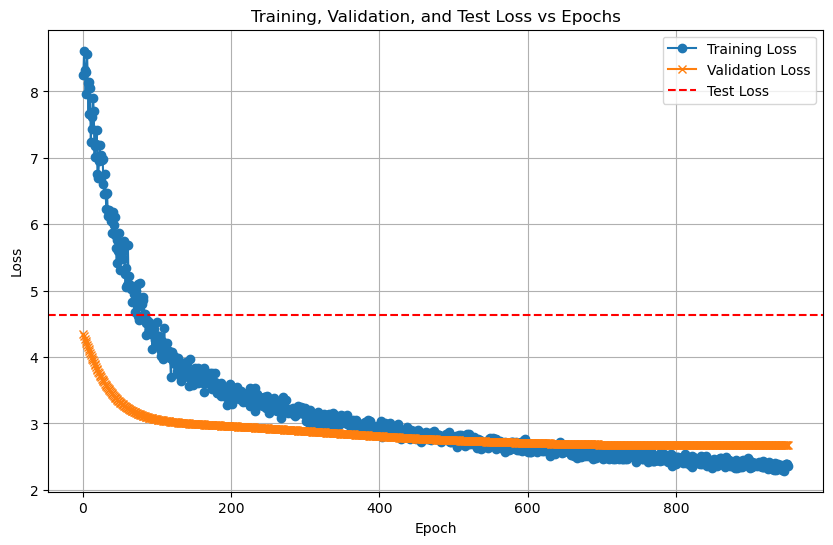

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.


  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.


  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.11%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.60      0.60      0.60         5
           2       0.40      0.40      0.40         5
           3       1.00      0.60      0.75         5
           4       1.00      0.80      0.89         5
           5       0.50      0.60      0.55         5
           6       1.00      0.60      0.75         5
           7       0.57      0.80      0.67         5
           8       0.83      1.00      0.91         5

    accuracy                           0.71        45
   macro avg       0.75      0.71      0.71        45
weighted avg       0.75      0.71      0.71        45


LOG: Evaluating on the test set...
Test Accuracy: 54.63%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5218  |  Val Loss: 2.4688
Validation loss improved from inf to 2.4688.
[Epoch 2/1000] Train Loss: 2.5017  |  Val Loss: 2.4507
Validation loss improved from 2.4688 to 2.4507.
[Epoch 3/1000] Train Loss: 2.4816  |  Val Loss: 2.4327
Validation loss improved from 2.4507 to 2.4327.
[Epoch 4/1000] Train Loss: 2.4615  |  Val Loss: 2.4148
Validation loss improved from 2.4327 to 2.4148.
[Epoch 5/1000] Train Loss: 2.4414  |  Val Loss: 2.3969
Validation loss improved from 2.4148 to 2.3969.
[Epoch 6/1000] Train Loss: 2.4216  |  Val Loss: 2.3792
Validation loss improved from 2.3969 to 2.3792.
[Epoch 7/1000] Train Loss: 2.4022  |  Val Loss: 2.3618
Validation loss improved from 2.3792 to 2.3618.
[Epoch 8/1000] Train Loss: 2.3831  |  Val Loss: 2.3446
Validation loss improved from 2.3618 to 2.3446.
[Epoch 9/1000] Train Loss: 2.3642  |  Val Loss: 2.3279
Validation loss improved from 2.3446 to 2.3279.
[Epoch 10/1000] Train Loss: 2.3455  |  Val Loss: 2.3118
Validation loss impr

[Epoch 14/1000] Train Loss: 2.2775  |  Val Loss: 2.2559
Validation loss improved from 2.2694 to 2.2559.
[Epoch 15/1000] Train Loss: 2.2618  |  Val Loss: 2.2428
Validation loss improved from 2.2559 to 2.2428.
[Epoch 16/1000] Train Loss: 2.2467  |  Val Loss: 2.2300
Validation loss improved from 2.2428 to 2.2300.
[Epoch 17/1000] Train Loss: 2.2320  |  Val Loss: 2.2174
Validation loss improved from 2.2300 to 2.2174.
[Epoch 18/1000] Train Loss: 2.2177  |  Val Loss: 2.2050
Validation loss improved from 2.2174 to 2.2050.
[Epoch 19/1000] Train Loss: 2.2037  |  Val Loss: 2.1930
Validation loss improved from 2.2050 to 2.1930.
[Epoch 20/1000] Train Loss: 2.1900  |  Val Loss: 2.1812
Validation loss improved from 2.1930 to 2.1812.
[Epoch 21/1000] Train Loss: 2.1768  |  Val Loss: 2.1696
Validation loss improved from 2.1812 to 2.1696.
[Epoch 22/1000] Train Loss: 2.1638  |  Val Loss: 2.1583
Validation loss improved from 2.1696 to 2.1583.
[Epoch 23/1000] Train Loss: 2.1511  |  Val Loss: 2.1471
Validati

[Epoch 56/1000] Train Loss: 1.8264  |  Val Loss: 1.8760
Validation loss improved from 1.8825 to 1.8760.
[Epoch 57/1000] Train Loss: 1.8184  |  Val Loss: 1.8695
Validation loss improved from 1.8760 to 1.8695.
[Epoch 58/1000] Train Loss: 1.8103  |  Val Loss: 1.8629
Validation loss improved from 1.8695 to 1.8629.
[Epoch 59/1000] Train Loss: 1.8023  |  Val Loss: 1.8564
Validation loss improved from 1.8629 to 1.8564.
[Epoch 60/1000] Train Loss: 1.7942  |  Val Loss: 1.8499
Validation loss improved from 1.8564 to 1.8499.
[Epoch 61/1000] Train Loss: 1.7862  |  Val Loss: 1.8434
Validation loss improved from 1.8499 to 1.8434.
[Epoch 62/1000] Train Loss: 1.7783  |  Val Loss: 1.8370
Validation loss improved from 1.8434 to 1.8370.
[Epoch 63/1000] Train Loss: 1.7704  |  Val Loss: 1.8305
Validation loss improved from 1.8370 to 1.8305.
[Epoch 64/1000] Train Loss: 1.7625  |  Val Loss: 1.8239
Validation loss improved from 1.8305 to 1.8239.
[Epoch 65/1000] Train Loss: 1.7547  |  Val Loss: 1.8174
Validati

[Epoch 68/1000] Train Loss: 1.7310  |  Val Loss: 1.7976
Validation loss improved from 1.8043 to 1.7976.
[Epoch 69/1000] Train Loss: 1.7230  |  Val Loss: 1.7909
Validation loss improved from 1.7976 to 1.7909.
[Epoch 70/1000] Train Loss: 1.7150  |  Val Loss: 1.7841
Validation loss improved from 1.7909 to 1.7841.
[Epoch 71/1000] Train Loss: 1.7071  |  Val Loss: 1.7774
Validation loss improved from 1.7841 to 1.7774.
[Epoch 72/1000] Train Loss: 1.6991  |  Val Loss: 1.7706
Validation loss improved from 1.7774 to 1.7706.
[Epoch 73/1000] Train Loss: 1.6912  |  Val Loss: 1.7640
Validation loss improved from 1.7706 to 1.7640.
[Epoch 74/1000] Train Loss: 1.6833  |  Val Loss: 1.7574
Validation loss improved from 1.7640 to 1.7574.
[Epoch 75/1000] Train Loss: 1.6754  |  Val Loss: 1.7510
Validation loss improved from 1.7574 to 1.7510.
[Epoch 76/1000] Train Loss: 1.6675  |  Val Loss: 1.7446
Validation loss improved from 1.7510 to 1.7446.
[Epoch 77/1000] Train Loss: 1.6597  |  Val Loss: 1.7382
Validati

[Epoch 92/1000] Train Loss: 1.5461  |  Val Loss: 1.6455
Validation loss improved from 1.6515 to 1.6455.
[Epoch 93/1000] Train Loss: 1.5388  |  Val Loss: 1.6395
Validation loss improved from 1.6455 to 1.6395.
[Epoch 94/1000] Train Loss: 1.5315  |  Val Loss: 1.6336
Validation loss improved from 1.6395 to 1.6336.
[Epoch 95/1000] Train Loss: 1.5242  |  Val Loss: 1.6276
Validation loss improved from 1.6336 to 1.6276.
[Epoch 96/1000] Train Loss: 1.5169  |  Val Loss: 1.6216
Validation loss improved from 1.6276 to 1.6216.
[Epoch 97/1000] Train Loss: 1.5097  |  Val Loss: 1.6156
Validation loss improved from 1.6216 to 1.6156.
[Epoch 98/1000] Train Loss: 1.5024  |  Val Loss: 1.6096
Validation loss improved from 1.6156 to 1.6096.
[Epoch 99/1000] Train Loss: 1.4952  |  Val Loss: 1.6036
Validation loss improved from 1.6096 to 1.6036.
[Epoch 100/1000] Train Loss: 1.4880  |  Val Loss: 1.5975
Validation loss improved from 1.6036 to 1.5975.
[Epoch 101/1000] Train Loss: 1.4809  |  Val Loss: 1.5915
Valida

[Epoch 133/1000] Train Loss: 1.2706  |  Val Loss: 1.4175
Validation loss improved from 1.4225 to 1.4175.


[Epoch 134/1000] Train Loss: 1.2646  |  Val Loss: 1.4126
Validation loss improved from 1.4175 to 1.4126.
[Epoch 135/1000] Train Loss: 1.2586  |  Val Loss: 1.4077
Validation loss improved from 1.4126 to 1.4077.
[Epoch 136/1000] Train Loss: 1.2527  |  Val Loss: 1.4029
Validation loss improved from 1.4077 to 1.4029.
[Epoch 137/1000] Train Loss: 1.2469  |  Val Loss: 1.3981
Validation loss improved from 1.4029 to 1.3981.
[Epoch 138/1000] Train Loss: 1.2410  |  Val Loss: 1.3933
Validation loss improved from 1.3981 to 1.3933.
[Epoch 139/1000] Train Loss: 1.2352  |  Val Loss: 1.3886
Validation loss improved from 1.3933 to 1.3886.
[Epoch 140/1000] Train Loss: 1.2295  |  Val Loss: 1.3840
Validation loss improved from 1.3886 to 1.3840.
[Epoch 141/1000] Train Loss: 1.2237  |  Val Loss: 1.3794
Validation loss improved from 1.3840 to 1.3794.
[Epoch 142/1000] Train Loss: 1.2181  |  Val Loss: 1.3748
Validation loss improved from 1.3794 to 1.3748.
[Epoch 143/1000] Train Loss: 1.2124  |  Val Loss: 1.370

[Epoch 166/1000] Train Loss: 1.0961  |  Val Loss: 1.2755
Validation loss improved from 1.2794 to 1.2755.
[Epoch 167/1000] Train Loss: 1.0914  |  Val Loss: 1.2717
Validation loss improved from 1.2755 to 1.2717.
[Epoch 168/1000] Train Loss: 1.0868  |  Val Loss: 1.2679
Validation loss improved from 1.2717 to 1.2679.
[Epoch 169/1000] Train Loss: 1.0822  |  Val Loss: 1.2642
Validation loss improved from 1.2679 to 1.2642.
[Epoch 170/1000] Train Loss: 1.0776  |  Val Loss: 1.2605
Validation loss improved from 1.2642 to 1.2605.
[Epoch 171/1000] Train Loss: 1.0731  |  Val Loss: 1.2568
Validation loss improved from 1.2605 to 1.2568.
[Epoch 172/1000] Train Loss: 1.0686  |  Val Loss: 1.2531
Validation loss improved from 1.2568 to 1.2531.
[Epoch 173/1000] Train Loss: 1.0641  |  Val Loss: 1.2495
Validation loss improved from 1.2531 to 1.2495.
[Epoch 174/1000] Train Loss: 1.0596  |  Val Loss: 1.2459
Validation loss improved from 1.2495 to 1.2459.
[Epoch 175/1000] Train Loss: 1.0552  |  Val Loss: 1.242

[Epoch 216/1000] Train Loss: 0.8874  |  Val Loss: 1.1109
Validation loss improved from 1.1139 to 1.1109.
[Epoch 217/1000] Train Loss: 0.8836  |  Val Loss: 1.1080
Validation loss improved from 1.1109 to 1.1080.
[Epoch 218/1000] Train Loss: 0.8797  |  Val Loss: 1.1050
Validation loss improved from 1.1080 to 1.1050.
[Epoch 219/1000] Train Loss: 0.8760  |  Val Loss: 1.1021
Validation loss improved from 1.1050 to 1.1021.
[Epoch 220/1000] Train Loss: 0.8722  |  Val Loss: 1.0993
Validation loss improved from 1.1021 to 1.0993.
[Epoch 221/1000] Train Loss: 0.8684  |  Val Loss: 1.0965
Validation loss improved from 1.0993 to 1.0965.
[Epoch 222/1000] Train Loss: 0.8646  |  Val Loss: 1.0937
Validation loss improved from 1.0965 to 1.0937.
[Epoch 223/1000] Train Loss: 0.8608  |  Val Loss: 1.0908
Validation loss improved from 1.0937 to 1.0908.
[Epoch 224/1000] Train Loss: 0.8570  |  Val Loss: 1.0880
Validation loss improved from 1.0908 to 1.0880.
[Epoch 225/1000] Train Loss: 0.8532  |  Val Loss: 1.085

[Epoch 244/1000] Train Loss: 0.7799  |  Val Loss: 1.0292
Validation loss improved from 1.0320 to 1.0292.
[Epoch 245/1000] Train Loss: 0.7762  |  Val Loss: 1.0263
Validation loss improved from 1.0292 to 1.0263.
[Epoch 246/1000] Train Loss: 0.7725  |  Val Loss: 1.0235
Validation loss improved from 1.0263 to 1.0235.
[Epoch 247/1000] Train Loss: 0.7689  |  Val Loss: 1.0207
Validation loss improved from 1.0235 to 1.0207.
[Epoch 248/1000] Train Loss: 0.7653  |  Val Loss: 1.0180
Validation loss improved from 1.0207 to 1.0180.
[Epoch 249/1000] Train Loss: 0.7617  |  Val Loss: 1.0152
Validation loss improved from 1.0180 to 1.0152.
[Epoch 250/1000] Train Loss: 0.7582  |  Val Loss: 1.0125
Validation loss improved from 1.0152 to 1.0125.
[Epoch 251/1000] Train Loss: 0.7546  |  Val Loss: 1.0099
Validation loss improved from 1.0125 to 1.0099.
[Epoch 252/1000] Train Loss: 0.7510  |  Val Loss: 1.0072
Validation loss improved from 1.0099 to 1.0072.
[Epoch 253/1000] Train Loss: 0.7475  |  Val Loss: 1.004

[Epoch 294/1000] Train Loss: 0.6158  |  Val Loss: 0.9110
Validation loss improved from 0.9130 to 0.9110.
[Epoch 295/1000] Train Loss: 0.6129  |  Val Loss: 0.9090
Validation loss improved from 0.9110 to 0.9090.
[Epoch 296/1000] Train Loss: 0.6100  |  Val Loss: 0.9071
Validation loss improved from 0.9090 to 0.9071.
[Epoch 297/1000] Train Loss: 0.6072  |  Val Loss: 0.9051
Validation loss improved from 0.9071 to 0.9051.
[Epoch 298/1000] Train Loss: 0.6044  |  Val Loss: 0.9032
Validation loss improved from 0.9051 to 0.9032.
[Epoch 299/1000] Train Loss: 0.6016  |  Val Loss: 0.9012
Validation loss improved from 0.9032 to 0.9012.
[Epoch 300/1000] Train Loss: 0.5987  |  Val Loss: 0.8993
Validation loss improved from 0.9012 to 0.8993.
[Epoch 301/1000] Train Loss: 0.5959  |  Val Loss: 0.8974
Validation loss improved from 0.8993 to 0.8974.
[Epoch 302/1000] Train Loss: 0.5932  |  Val Loss: 0.8954
Validation loss improved from 0.8974 to 0.8954.
[Epoch 303/1000] Train Loss: 0.5904  |  Val Loss: 0.893

[Epoch 320/1000] Train Loss: 0.5456  |  Val Loss: 0.8633
Validation loss improved from 0.8650 to 0.8633.
[Epoch 321/1000] Train Loss: 0.5431  |  Val Loss: 0.8616
Validation loss improved from 0.8633 to 0.8616.
[Epoch 322/1000] Train Loss: 0.5406  |  Val Loss: 0.8600
Validation loss improved from 0.8616 to 0.8600.
[Epoch 323/1000] Train Loss: 0.5381  |  Val Loss: 0.8584
Validation loss improved from 0.8600 to 0.8584.
[Epoch 324/1000] Train Loss: 0.5356  |  Val Loss: 0.8567
Validation loss improved from 0.8584 to 0.8567.
[Epoch 325/1000] Train Loss: 0.5331  |  Val Loss: 0.8551
Validation loss improved from 0.8567 to 0.8551.
[Epoch 326/1000] Train Loss: 0.5307  |  Val Loss: 0.8535
Validation loss improved from 0.8551 to 0.8535.
[Epoch 327/1000] Train Loss: 0.5282  |  Val Loss: 0.8519
Validation loss improved from 0.8535 to 0.8519.
[Epoch 328/1000] Train Loss: 0.5258  |  Val Loss: 0.8503
Validation loss improved from 0.8519 to 0.8503.
[Epoch 329/1000] Train Loss: 0.5234  |  Val Loss: 0.848

[Epoch 370/1000] Train Loss: 0.4349  |  Val Loss: 0.7953
Validation loss improved from 0.7963 to 0.7953.
[Epoch 371/1000] Train Loss: 0.4330  |  Val Loss: 0.7943
Validation loss improved from 0.7953 to 0.7943.
[Epoch 372/1000] Train Loss: 0.4311  |  Val Loss: 0.7934
Validation loss improved from 0.7943 to 0.7934.
[Epoch 373/1000] Train Loss: 0.4292  |  Val Loss: 0.7924
Validation loss improved from 0.7934 to 0.7924.
[Epoch 374/1000] Train Loss: 0.4273  |  Val Loss: 0.7914
Validation loss improved from 0.7924 to 0.7914.
[Epoch 375/1000] Train Loss: 0.4255  |  Val Loss: 0.7904
Validation loss improved from 0.7914 to 0.7904.
[Epoch 376/1000] Train Loss: 0.4236  |  Val Loss: 0.7895
Validation loss improved from 0.7904 to 0.7895.
[Epoch 377/1000] Train Loss: 0.4218  |  Val Loss: 0.7885
Validation loss improved from 0.7895 to 0.7885.
[Epoch 378/1000] Train Loss: 0.4199  |  Val Loss: 0.7876
Validation loss improved from 0.7885 to 0.7876.
[Epoch 379/1000] Train Loss: 0.4181  |  Val Loss: 0.786

[Epoch 397/1000] Train Loss: 0.3868  |  Val Loss: 0.7709
Validation loss improved from 0.7717 to 0.7709.
[Epoch 398/1000] Train Loss: 0.3851  |  Val Loss: 0.7701
Validation loss improved from 0.7709 to 0.7701.
[Epoch 399/1000] Train Loss: 0.3835  |  Val Loss: 0.7693
Validation loss improved from 0.7701 to 0.7693.
[Epoch 400/1000] Train Loss: 0.3818  |  Val Loss: 0.7686
Validation loss improved from 0.7693 to 0.7686.
[Epoch 401/1000] Train Loss: 0.3802  |  Val Loss: 0.7679
Validation loss improved from 0.7686 to 0.7679.
[Epoch 402/1000] Train Loss: 0.3787  |  Val Loss: 0.7671
Validation loss improved from 0.7679 to 0.7671.
[Epoch 403/1000] Train Loss: 0.3771  |  Val Loss: 0.7664
Validation loss improved from 0.7671 to 0.7664.
[Epoch 404/1000] Train Loss: 0.3755  |  Val Loss: 0.7657
Validation loss improved from 0.7664 to 0.7657.
[Epoch 405/1000] Train Loss: 0.3739  |  Val Loss: 0.7651
Validation loss improved from 0.7657 to 0.7651.
[Epoch 406/1000] Train Loss: 0.3724  |  Val Loss: 0.764

[Epoch 447/1000] Train Loss: 0.3133  |  Val Loss: 0.7438
Validation loss improved from 0.7441 to 0.7438.
[Epoch 448/1000] Train Loss: 0.3120  |  Val Loss: 0.7435
Validation loss improved from 0.7438 to 0.7435.
[Epoch 449/1000] Train Loss: 0.3107  |  Val Loss: 0.7432
Validation loss improved from 0.7435 to 0.7432.
[Epoch 450/1000] Train Loss: 0.3094  |  Val Loss: 0.7429
Validation loss improved from 0.7432 to 0.7429.
[Epoch 451/1000] Train Loss: 0.3082  |  Val Loss: 0.7426
Validation loss improved from 0.7429 to 0.7426.
[Epoch 452/1000] Train Loss: 0.3069  |  Val Loss: 0.7423
Validation loss improved from 0.7426 to 0.7423.
[Epoch 453/1000] Train Loss: 0.3057  |  Val Loss: 0.7421
Validation loss improved from 0.7423 to 0.7421.
[Epoch 454/1000] Train Loss: 0.3044  |  Val Loss: 0.7418
Validation loss improved from 0.7421 to 0.7418.
[Epoch 455/1000] Train Loss: 0.3032  |  Val Loss: 0.7416
Validation loss improved from 0.7418 to 0.7416.
[Epoch 456/1000] Train Loss: 0.3020  |  Val Loss: 0.741

[Epoch 478/1000] Train Loss: 0.2766  |  Val Loss: 0.7369
Validation loss improved from 0.7370 to 0.7369.
[Epoch 479/1000] Train Loss: 0.2755  |  Val Loss: 0.7367
Validation loss improved from 0.7369 to 0.7367.
[Epoch 480/1000] Train Loss: 0.2745  |  Val Loss: 0.7366
Validation loss improved from 0.7367 to 0.7366.
[Epoch 481/1000] Train Loss: 0.2734  |  Val Loss: 0.7365
Validation loss improved from 0.7366 to 0.7365.
[Epoch 482/1000] Train Loss: 0.2723  |  Val Loss: 0.7364
Validation loss improved from 0.7365 to 0.7364.
[Epoch 483/1000] Train Loss: 0.2713  |  Val Loss: 0.7363
Validation loss improved from 0.7364 to 0.7363.
[Epoch 484/1000] Train Loss: 0.2702  |  Val Loss: 0.7362
Validation loss improved from 0.7363 to 0.7362.
[Epoch 485/1000] Train Loss: 0.2692  |  Val Loss: 0.7361
Validation loss improved from 0.7362 to 0.7361.
[Epoch 486/1000] Train Loss: 0.2681  |  Val Loss: 0.7361
Validation loss improved from 0.7361 to 0.7361.
[Epoch 487/1000] Train Loss: 0.2671  |  Val Loss: 0.736

[Epoch 523/1000] Train Loss: 0.2331  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 524/1000] Train Loss: 0.2322  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 525/1000] Train Loss: 0.2314  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 526/1000] Train Loss: 0.2305  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 527/1000] Train Loss: 0.2297  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 528/1000] Train Loss: 0.2288  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 529/1000] Train Loss: 0.2280  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 530/1000] Train Loss: 0.2271  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 531/1000] Train Loss: 0.2263  |  Val Loss: 0.7340
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 553/1000] Train Loss: 0.2088  |  Val Loss: 0.7347
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 554/1000] Train Loss: 0.2080  |  Val Loss: 0.7348
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 555/1000] Train Loss: 0.2073  |  Val Loss: 0.7349
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 556/1000] Train Loss: 0.2065  |  Val Loss: 0.7350
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 557/1000] Train Loss: 0.2058  |  Val Loss: 0.7350
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 558/1000] Train Loss: 0.2050  |  Val Loss: 0.7351
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 559/1000] Train Loss: 0.2043  |  Val Loss: 0.7351
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 560/1000] Train Loss: 0.2035  |  Val Loss: 0.7351
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 561/1000] Train Loss: 0.2028  |  Val Loss: 0.7352
!! Validation loss did NOT improve !! Patience:

[Epoch 604/1000] Train Loss: 0.1740  |  Val Loss: 0.7420
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 605/1000] Train Loss: 0.1734  |  Val Loss: 0.7422
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 606/1000] Train Loss: 0.1728  |  Val Loss: 0.7423
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 607/1000] Train Loss: 0.1722  |  Val Loss: 0.7425
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 608/1000] Train Loss: 0.1716  |  Val Loss: 0.7427
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 609/1000] Train Loss: 0.1710  |  Val Loss: 0.7429
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 610/1000] Train Loss: 0.1704  |  Val Loss: 0.7432
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 611/1000] Train Loss: 0.1698  |  Val Loss: 0.7435
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 612/1000] Train Loss: 0.1692  |  Val Loss: 0.7437
!! Validation loss did NOT improve !! Patience:

[Epoch 626/1000] Train Loss: 0.1612  |  Val Loss: 0.7468
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 627/1000] Train Loss: 0.1606  |  Val Loss: 0.7470
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 628/1000] Train Loss: 0.1601  |  Val Loss: 0.7473
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 629/1000] Train Loss: 0.1595  |  Val Loss: 0.7475
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 630/1000] Train Loss: 0.1589  |  Val Loss: 0.7478
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 631/1000] Train Loss: 0.1584  |  Val Loss: 0.7480
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 632/1000] Train Loss: 0.1579  |  Val Loss: 0.7483
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 633/1000] Train Loss: 0.1573  |  Val Loss: 0.7487
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 634/1000] Train Loss: 0.1568  |  Val Loss: 0.7490
!! Validation loss did NOT improve !! Patience:

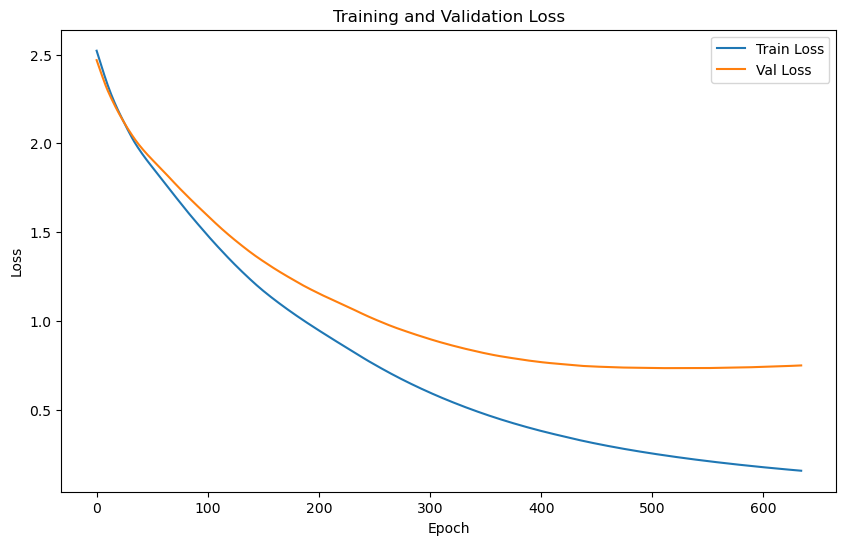

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.0905 | Test Accuracy: 56.85%


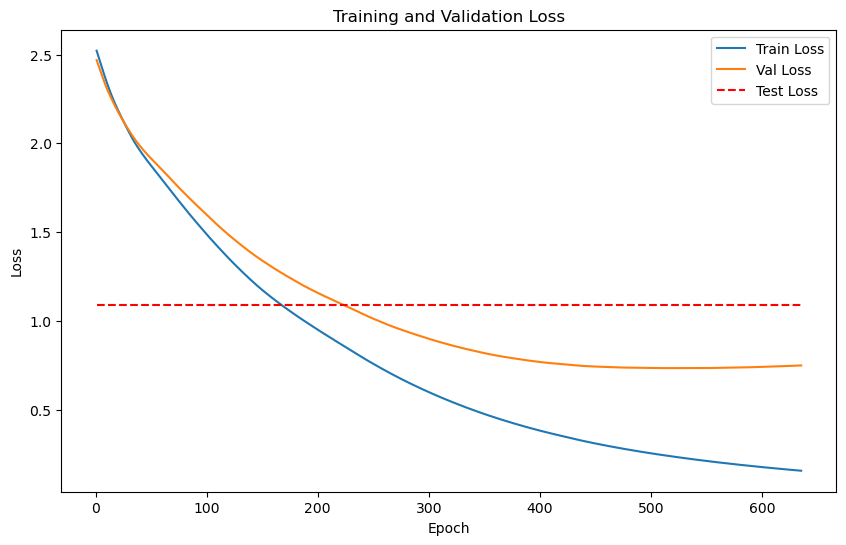

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42686 samples with 64 features each
LOG: Labels shape: (42686,)


Train embeddings shape: (45, 64), 
Train labels shape: (45,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42686, 64), 
Test labels shape: (42686,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Training batch size: 45


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [1/2000] - Validation


    Batch [1/1], Val Loss: 0.4498
Epoch [1/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.4498

Validation loss improved from inf to 0.4498. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4489
Epoch [2/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.4489

Validation loss improved from 0.4498 to 0.4489. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4475
Epoch [3/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4475

Validation loss improved from 0.4489 to 0.4475. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.4457
Epoch [4/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4457

Validation loss improved from 0.4475 to 0.4457. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.4436
Epoch [5/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.4436

Validation loss improved from 0.4457 to 0.4436. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4414
Epoch [6/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.4414

Validation loss improved from 0.4436 to 0.4414. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.4390
Epoch [7/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4390

Validation loss improved from 0.4414 to 0.4390. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4366
Epoch [8/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4366

Validation loss improved from 0.4390 to 0.4366. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4346
Epoch [9/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4346

Validation loss improved from 0.4366 to 0.4346. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4335
Epoch [10/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4335

Validation loss improved from 0.4346 to 0.4335. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.4334
Epoch [11/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4334

Validation loss improved from 0.4335 to 0.4334. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4334
Epoch [12/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.4334

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4332
Epoch [13/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.4332

Validation loss improved from 0.4334 to 0.4332. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4330
Epoch [14/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.4330

Validation loss improved from 0.4332 to 0.4330. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4326
Epoch [15/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4326

Validation loss improved from 0.4330 to 0.4326. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4321
Epoch [16/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.4321

Validation loss improved from 0.4326 to 0.4321. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4315
Epoch [17/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.4315

Validation loss improved from 0.4321 to 0.4315. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [18/2000] - Validation


    Batch [1/1], Val Loss: 0.4310
Epoch [18/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.4310

Validation loss improved from 0.4315 to 0.4310. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4306
Epoch [19/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.4306

Validation loss improved from 0.4310 to 0.4306. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4302
Epoch [20/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4302

Validation loss improved from 0.4306 to 0.4302. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4298
Epoch [21/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4298

Validation loss improved from 0.4302 to 0.4298. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.4294
Epoch [22/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.4294

Validation loss improved from 0.4298 to 0.4294. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4290
Epoch [23/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.4290

Validation loss improved from 0.4294 to 0.4290. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [24/2000] - Validation


    Batch [1/1], Val Loss: 0.4286
Epoch [24/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.4286

Validation loss improved from 0.4290 to 0.4286. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4283
Epoch [25/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4283

Validation loss improved from 0.4286 to 0.4283. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4279
Epoch [26/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4279

Validation loss improved from 0.4283 to 0.4279. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4276
Epoch [27/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.4276

Validation loss improved from 0.4279 to 0.4276. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4273
Epoch [28/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.4273

Validation loss improved from 0.4276 to 0.4273. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [29/2000] - Validation


    Batch [1/1], Val Loss: 0.4270
Epoch [29/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.4270

Validation loss improved from 0.4273 to 0.4270. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4267
Epoch [30/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.4267

Validation loss improved from 0.4270 to 0.4267. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4264
Epoch [31/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.4264

Validation loss improved from 0.4267 to 0.4264. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4260
Epoch [32/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.4260

Validation loss improved from 0.4264 to 0.4260. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4257
Epoch [33/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.4257

Validation loss improved from 0.4260 to 0.4257. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [34/2000] - Validation


    Batch [1/1], Val Loss: 0.4253
Epoch [34/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.4253

Validation loss improved from 0.4257 to 0.4253. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4249
Epoch [35/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.4249

Validation loss improved from 0.4253 to 0.4249. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4246
Epoch [36/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.4246

Validation loss improved from 0.4249 to 0.4246. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.4242
Epoch [37/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.4242

Validation loss improved from 0.4246 to 0.4242. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4238
Epoch [38/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.4238

Validation loss improved from 0.4242 to 0.4238. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4234
Epoch [39/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.4234

Validation loss improved from 0.4238 to 0.4234. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4230
Epoch [40/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.4230

Validation loss improved from 0.4234 to 0.4230. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4226
Epoch [41/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.4226

Validation loss improved from 0.4230 to 0.4226. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4223
Epoch [42/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.4223

Validation loss improved from 0.4226 to 0.4223. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.4219
Epoch [43/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.4219

Validation loss improved from 0.4223 to 0.4219. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.4215
Epoch [44/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.4215

Validation loss improved from 0.4219 to 0.4215. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.4212
Epoch [45/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.4212

Validation loss improved from 0.4215 to 0.4212. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [46/2000] - Validation


    Batch [1/1], Val Loss: 0.4208
Epoch [46/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.4208

Validation loss improved from 0.4212 to 0.4208. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.4205
Epoch [47/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.4205

Validation loss improved from 0.4208 to 0.4205. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.4201
Epoch [48/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.4201

Validation loss improved from 0.4205 to 0.4201. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.4198
Epoch [49/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.4198

Validation loss improved from 0.4201 to 0.4198. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [50/2000] - Validation


    Batch [1/1], Val Loss: 0.4194
Epoch [50/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.4194

Validation loss improved from 0.4198 to 0.4194. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.4191
Epoch [51/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.4191

Validation loss improved from 0.4194 to 0.4191. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.4187
Epoch [52/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.4187

Validation loss improved from 0.4191 to 0.4187. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.4184
Epoch [53/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.4184

Validation loss improved from 0.4187 to 0.4184. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.4180
Epoch [54/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.4180

Validation loss improved from 0.4184 to 0.4180. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.4176
Epoch [55/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.4176

Validation loss improved from 0.4180 to 0.4176. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.4173
Epoch [56/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.4173

Validation loss improved from 0.4176 to 0.4173. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.4169
Epoch [57/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.4169

Validation loss improved from 0.4173 to 0.4169. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.4166
Epoch [58/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.4166

Validation loss improved from 0.4169 to 0.4166. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [59/2000] - Validation


    Batch [1/1], Val Loss: 0.4162
Epoch [59/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.4162

Validation loss improved from 0.4166 to 0.4162. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.4158
Epoch [60/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.4158

Validation loss improved from 0.4162 to 0.4158. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [61/2000] - Validation


    Batch [1/1], Val Loss: 0.4155
Epoch [61/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.4155

Validation loss improved from 0.4158 to 0.4155. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.4152
Epoch [62/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.4152

Validation loss improved from 0.4155 to 0.4152. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.4148
Epoch [63/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.4148

Validation loss improved from 0.4152 to 0.4148. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.4145
Epoch [64/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.4145

Validation loss improved from 0.4148 to 0.4145. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.4141
Epoch [65/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.4141

Validation loss improved from 0.4145 to 0.4141. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.4138
Epoch [66/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.4138

Validation loss improved from 0.4141 to 0.4138. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.4135
Epoch [67/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.4135

Validation loss improved from 0.4138 to 0.4135. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.4132
Epoch [68/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.4132

Validation loss improved from 0.4135 to 0.4132. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.4129
Epoch [69/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.4129

Validation loss improved from 0.4132 to 0.4129. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.4126
Epoch [70/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.4126

Validation loss improved from 0.4129 to 0.4126. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [71/2000] - Validation


    Batch [1/1], Val Loss: 0.4123
Epoch [71/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.4123

Validation loss improved from 0.4126 to 0.4123. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.4120
Epoch [72/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.4120

Validation loss improved from 0.4123 to 0.4120. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.4117
Epoch [73/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.4117

Validation loss improved from 0.4120 to 0.4117. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.4114
Epoch [74/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.4114

Validation loss improved from 0.4117 to 0.4114. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.4111
Epoch [75/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.4111

Validation loss improved from 0.4114 to 0.4111. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [76/2000] - Validation


    Batch [1/1], Val Loss: 0.4109
Epoch [76/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.4109

Validation loss improved from 0.4111 to 0.4109. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.4106
Epoch [77/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.4106

Validation loss improved from 0.4109 to 0.4106. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.4103
Epoch [78/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.4103

Validation loss improved from 0.4106 to 0.4103. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.4100
Epoch [79/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.4100

Validation loss improved from 0.4103 to 0.4100. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.4097
Epoch [80/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.4097

Validation loss improved from 0.4100 to 0.4097. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.4094
Epoch [81/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.4094

Validation loss improved from 0.4097 to 0.4094. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.4091
Epoch [82/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.4091

Validation loss improved from 0.4094 to 0.4091. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [83/2000] - Validation


    Batch [1/1], Val Loss: 0.4088
Epoch [83/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.4088

Validation loss improved from 0.4091 to 0.4088. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.4085
Epoch [84/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.4085

Validation loss improved from 0.4088 to 0.4085. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [85/2000] - Validation


    Batch [1/1], Val Loss: 0.4083
Epoch [85/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.4083

Validation loss improved from 0.4085 to 0.4083. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.4080
Epoch [86/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.4080

Validation loss improved from 0.4083 to 0.4080. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [87/2000] - Validation


    Batch [1/1], Val Loss: 0.4078
Epoch [87/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.4078

Validation loss improved from 0.4080 to 0.4078. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.4075
Epoch [88/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.4075

Validation loss improved from 0.4078 to 0.4075. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [89/2000] - Validation


    Batch [1/1], Val Loss: 0.4073
Epoch [89/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.4073

Validation loss improved from 0.4075 to 0.4073. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.4070
Epoch [90/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.4070

Validation loss improved from 0.4073 to 0.4070. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [91/2000] - Validation


    Batch [1/1], Val Loss: 0.4068
Epoch [91/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.4068

Validation loss improved from 0.4070 to 0.4068. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.4065
Epoch [92/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.4065

Validation loss improved from 0.4068 to 0.4065. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.4063
Epoch [93/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.4063

Validation loss improved from 0.4065 to 0.4063. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.4060
Epoch [94/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.4060

Validation loss improved from 0.4063 to 0.4060. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.4058
Epoch [95/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.4058

Validation loss improved from 0.4060 to 0.4058. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.4055
Epoch [96/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.4055

Validation loss improved from 0.4058 to 0.4055. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.4052
Epoch [97/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.4052

Validation loss improved from 0.4055 to 0.4052. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [98/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.4050

Validation loss improved from 0.4052 to 0.4050. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [99/2000] - Validation


    Batch [1/1], Val Loss: 0.4047
Epoch [99/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.4047

Validation loss improved from 0.4050 to 0.4047. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.4045
Epoch [100/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.4045

Validation loss improved from 0.4047 to 0.4045. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.4042
Epoch [101/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.4042

Validation loss improved from 0.4045 to 0.4042. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.4040
Epoch [102/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.4040

Validation loss improved from 0.4042 to 0.4040. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.4038
Epoch [103/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.4038

Validation loss improved from 0.4040 to 0.4038. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.4036
Epoch [104/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.4036

Validation loss improved from 0.4038 to 0.4036. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.4034
Epoch [105/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.4034

Validation loss improved from 0.4036 to 0.4034. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.4032
Epoch [106/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.4032

Validation loss improved from 0.4034 to 0.4032. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.4030
Epoch [107/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.4030

Validation loss improved from 0.4032 to 0.4030. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.4028
Epoch [108/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.4028

Validation loss improved from 0.4030 to 0.4028. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.4027
Epoch [109/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.4027

Validation loss improved from 0.4028 to 0.4027. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.4025
Epoch [110/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.4025

Validation loss improved from 0.4027 to 0.4025. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.4023
Epoch [111/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.4023

Validation loss improved from 0.4025 to 0.4023. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.4022
Epoch [112/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.4022

Validation loss improved from 0.4023 to 0.4022. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.4020
Epoch [113/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.4020

Validation loss improved from 0.4022 to 0.4020. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.4018
Epoch [114/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.4018

Validation loss improved from 0.4020 to 0.4018. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.4017
Epoch [115/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.4017

Validation loss improved from 0.4018 to 0.4017. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.4015
Epoch [116/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.4015

Validation loss improved from 0.4017 to 0.4015. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3409
LOG: Epoch [117/2000] - Validation


    Batch [1/1], Val Loss: 0.4013
Epoch [117/2000], Avg Train Loss: 0.3409, Avg Val Loss: 0.4013

Validation loss improved from 0.4015 to 0.4013. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [118/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.4011

Validation loss improved from 0.4013 to 0.4011. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.4010
Epoch [119/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.4010

Validation loss improved from 0.4011 to 0.4010. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.4008
Epoch [120/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.4008

Validation loss improved from 0.4010 to 0.4008. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.4006
Epoch [121/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.4006

Validation loss improved from 0.4008 to 0.4006. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.4005
Epoch [122/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.4005

Validation loss improved from 0.4006 to 0.4005. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.4004
Epoch [123/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.4004

Validation loss improved from 0.4005 to 0.4004. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.4002
Epoch [124/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.4002

Validation loss improved from 0.4004 to 0.4002. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.4001
Epoch [125/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.4001

Validation loss improved from 0.4002 to 0.4001. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [126/2000] - Validation


    Batch [1/1], Val Loss: 0.3999
Epoch [126/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.3999

Validation loss improved from 0.4001 to 0.3999. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3998
Epoch [127/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.3998

Validation loss improved from 0.3999 to 0.3998. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [128/2000] - Validation


    Batch [1/1], Val Loss: 0.3996
Epoch [128/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.3996

Validation loss improved from 0.3998 to 0.3996. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3995
Epoch [129/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.3995

Validation loss improved from 0.3996 to 0.3995. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [130/2000] - Validation


    Batch [1/1], Val Loss: 0.3993
Epoch [130/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3993

Validation loss improved from 0.3995 to 0.3993. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3991
Epoch [131/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3991

Validation loss improved from 0.3993 to 0.3991. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [132/2000] - Validation


    Batch [1/1], Val Loss: 0.3989
Epoch [132/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.3989

Validation loss improved from 0.3991 to 0.3989. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3987
Epoch [133/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.3987

Validation loss improved from 0.3989 to 0.3987. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.3985
Epoch [134/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.3985

Validation loss improved from 0.3987 to 0.3985. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3983
Epoch [135/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3983

Validation loss improved from 0.3985 to 0.3983. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3982
Epoch [136/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.3982

Validation loss improved from 0.3983 to 0.3982. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3981
Epoch [137/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.3981

Validation loss improved from 0.3982 to 0.3981. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3288
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3979
Epoch [138/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.3979

Validation loss improved from 0.3981 to 0.3979. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3978
Epoch [139/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.3978

Validation loss improved from 0.3979 to 0.3978. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3977
Epoch [140/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.3977

Validation loss improved from 0.3978 to 0.3977. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [141/2000] - Validation


    Batch [1/1], Val Loss: 0.3976
Epoch [141/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.3976

Validation loss improved from 0.3977 to 0.3976. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3975
Epoch [142/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3975

Validation loss improved from 0.3976 to 0.3975. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.3974
Epoch [143/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.3974

Validation loss improved from 0.3975 to 0.3974. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3973
Epoch [144/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.3973

Validation loss improved from 0.3974 to 0.3973. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3971
Epoch [145/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.3971

Validation loss improved from 0.3973 to 0.3971. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3970
Epoch [146/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.3970

Validation loss improved from 0.3971 to 0.3970. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3970
Epoch [147/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.3970

Validation loss improved from 0.3970 to 0.3970. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3969
Epoch [148/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.3969

Validation loss improved from 0.3970 to 0.3969. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3968
Epoch [149/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.3968

Validation loss improved from 0.3969 to 0.3968. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.3967
Epoch [150/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.3967

Validation loss improved from 0.3968 to 0.3967. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3966
Epoch [151/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3966

Validation loss improved from 0.3967 to 0.3966. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [152/2000] - Validation


    Batch [1/1], Val Loss: 0.3964
Epoch [152/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.3964

Validation loss improved from 0.3966 to 0.3964. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.3114
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3963
Epoch [153/2000], Avg Train Loss: 0.3114, Avg Val Loss: 0.3963

Validation loss improved from 0.3964 to 0.3963. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [154/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.3962

Validation loss improved from 0.3963 to 0.3962. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3133
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3960
Epoch [155/2000], Avg Train Loss: 0.3133, Avg Val Loss: 0.3960

Validation loss improved from 0.3962 to 0.3960. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3959
Epoch [156/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.3959

Validation loss improved from 0.3960 to 0.3959. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3957
Epoch [157/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3957

Validation loss improved from 0.3959 to 0.3957. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.3084
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3956
Epoch [158/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.3956

Validation loss improved from 0.3957 to 0.3956. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [159/2000] - Validation


    Batch [1/1], Val Loss: 0.3955
Epoch [159/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.3955

Validation loss improved from 0.3956 to 0.3955. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3056
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.3953
Epoch [160/2000], Avg Train Loss: 0.3056, Avg Val Loss: 0.3953

Validation loss improved from 0.3955 to 0.3953. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [161/2000] - Validation


    Batch [1/1], Val Loss: 0.3952
Epoch [161/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3952

Validation loss improved from 0.3953 to 0.3952. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3951
Epoch [162/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.3951

Validation loss improved from 0.3952 to 0.3951. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.3190
LOG: Epoch [163/2000] - Validation


    Batch [1/1], Val Loss: 0.3950
Epoch [163/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.3950

Validation loss improved from 0.3951 to 0.3950. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3085
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3949
Epoch [164/2000], Avg Train Loss: 0.3085, Avg Val Loss: 0.3949

Validation loss improved from 0.3950 to 0.3949. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3044
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.3947
Epoch [165/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.3947

Validation loss improved from 0.3949 to 0.3947. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3946
Epoch [166/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.3946

Validation loss improved from 0.3947 to 0.3946. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3945
Epoch [167/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.3945

Validation loss improved from 0.3946 to 0.3945. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3944
Epoch [168/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.3944

Validation loss improved from 0.3945 to 0.3944. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3090
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.3942
Epoch [169/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.3942

Validation loss improved from 0.3944 to 0.3942. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.3034
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3942
Epoch [170/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.3942

Validation loss improved from 0.3942 to 0.3942. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3940
Epoch [171/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.3940

Validation loss improved from 0.3942 to 0.3940. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3159
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3939
Epoch [172/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.3939

Validation loss improved from 0.3940 to 0.3939. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3938
Epoch [173/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.3938

Validation loss improved from 0.3939 to 0.3938. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.3937
Epoch [174/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.3937

Validation loss improved from 0.3938 to 0.3937. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3936
Epoch [175/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.3936

Validation loss improved from 0.3937 to 0.3936. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.2990
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3934
Epoch [176/2000], Avg Train Loss: 0.2990, Avg Val Loss: 0.3934

Validation loss improved from 0.3936 to 0.3934. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3933
Epoch [177/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3933

Validation loss improved from 0.3934 to 0.3933. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3128
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3932
Epoch [178/2000], Avg Train Loss: 0.3128, Avg Val Loss: 0.3932

Validation loss improved from 0.3933 to 0.3932. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [179/2000] - Validation


    Batch [1/1], Val Loss: 0.3931
Epoch [179/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3931

Validation loss improved from 0.3932 to 0.3931. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3930
Epoch [180/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.3930

Validation loss improved from 0.3931 to 0.3930. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.2948
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3929
Epoch [181/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.3929

Validation loss improved from 0.3930 to 0.3929. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3011
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [182/2000], Avg Train Loss: 0.3011, Avg Val Loss: 0.3928

Validation loss improved from 0.3929 to 0.3928. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3927
Epoch [183/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.3927

Validation loss improved from 0.3928 to 0.3927. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3058
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [184/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.3926

Validation loss improved from 0.3927 to 0.3926. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.2846
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [185/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3926

Validation loss improved from 0.3926 to 0.3926. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.2922
LOG: Epoch [186/2000] - Validation


    Batch [1/1], Val Loss: 0.3925
Epoch [186/2000], Avg Train Loss: 0.2922, Avg Val Loss: 0.3925

Validation loss improved from 0.3926 to 0.3925. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.2941
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3923
Epoch [187/2000], Avg Train Loss: 0.2941, Avg Val Loss: 0.3923

Validation loss improved from 0.3925 to 0.3923. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3922
Epoch [188/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3922

Validation loss improved from 0.3923 to 0.3922. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3921
Epoch [189/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.3921

Validation loss improved from 0.3922 to 0.3921. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.2942
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3920
Epoch [190/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.3920

Validation loss improved from 0.3921 to 0.3920. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.2909
LOG: Epoch [191/2000] - Validation


    Batch [1/1], Val Loss: 0.3918
Epoch [191/2000], Avg Train Loss: 0.2909, Avg Val Loss: 0.3918

Validation loss improved from 0.3920 to 0.3918. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3917
Epoch [192/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.3917

Validation loss improved from 0.3918 to 0.3917. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.2871
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3915
Epoch [193/2000], Avg Train Loss: 0.2871, Avg Val Loss: 0.3915

Validation loss improved from 0.3917 to 0.3915. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3914
Epoch [194/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.3914

Validation loss improved from 0.3915 to 0.3914. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [195/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.3913

Validation loss improved from 0.3914 to 0.3913. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.2911
LOG: Epoch [196/2000] - Validation


    Batch [1/1], Val Loss: 0.3911
Epoch [196/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3911

Validation loss improved from 0.3913 to 0.3911. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.3003
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3910
Epoch [197/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.3910

Validation loss improved from 0.3911 to 0.3910. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3908
Epoch [198/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.3908

Validation loss improved from 0.3910 to 0.3908. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3906
Epoch [199/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.3906

Validation loss improved from 0.3908 to 0.3906. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3905
Epoch [200/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3905

Validation loss improved from 0.3906 to 0.3905. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.2695
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3903
Epoch [201/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.3903

Validation loss improved from 0.3905 to 0.3903. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.2981
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3902
Epoch [202/2000], Avg Train Loss: 0.2981, Avg Val Loss: 0.3902

Validation loss improved from 0.3903 to 0.3902. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.2808
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3900
Epoch [203/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.3900

Validation loss improved from 0.3902 to 0.3900. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3898
Epoch [204/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3898

Validation loss improved from 0.3900 to 0.3898. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3897
Epoch [205/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.3897

Validation loss improved from 0.3898 to 0.3897. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.2905
LOG: Epoch [206/2000] - Validation


    Batch [1/1], Val Loss: 0.3896
Epoch [206/2000], Avg Train Loss: 0.2905, Avg Val Loss: 0.3896

Validation loss improved from 0.3897 to 0.3896. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.2891
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3894
Epoch [207/2000], Avg Train Loss: 0.2891, Avg Val Loss: 0.3894

Validation loss improved from 0.3896 to 0.3894. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3893
Epoch [208/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.3893

Validation loss improved from 0.3894 to 0.3893. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3892
Epoch [209/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3892

Validation loss improved from 0.3893 to 0.3892. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [210/2000] - Validation


    Batch [1/1], Val Loss: 0.3891
Epoch [210/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3891

Validation loss improved from 0.3892 to 0.3891. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.2803
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3889
Epoch [211/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.3889

Validation loss improved from 0.3891 to 0.3889. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.3888
Epoch [212/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3888

Validation loss improved from 0.3889 to 0.3888. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.2835
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3887
Epoch [213/2000], Avg Train Loss: 0.2835, Avg Val Loss: 0.3887

Validation loss improved from 0.3888 to 0.3887. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.2979
LOG: Epoch [214/2000] - Validation


    Batch [1/1], Val Loss: 0.3887
Epoch [214/2000], Avg Train Loss: 0.2979, Avg Val Loss: 0.3887

Validation loss improved from 0.3887 to 0.3887. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3886
Epoch [215/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.3886

Validation loss improved from 0.3887 to 0.3886. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.2688
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.3885
Epoch [216/2000], Avg Train Loss: 0.2688, Avg Val Loss: 0.3885

Validation loss improved from 0.3886 to 0.3885. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3884
Epoch [217/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.3884

Validation loss improved from 0.3885 to 0.3884. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.2756
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3884
Epoch [218/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.3884

Validation loss improved from 0.3884 to 0.3884. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.2786
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [219/2000], Avg Train Loss: 0.2786, Avg Val Loss: 0.3883

Validation loss improved from 0.3884 to 0.3883. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3882
Epoch [220/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.3882

Validation loss improved from 0.3883 to 0.3882. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3882
Epoch [221/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.3882

Validation loss improved from 0.3882 to 0.3882. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [222/2000] - Validation


    Batch [1/1], Val Loss: 0.3881
Epoch [222/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.3881

Validation loss improved from 0.3882 to 0.3881. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3880
Epoch [223/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.3880

Validation loss improved from 0.3881 to 0.3880. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.2817
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3880
Epoch [224/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.3880

Validation loss improved from 0.3880 to 0.3880. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.2753
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3879
Epoch [225/2000], Avg Train Loss: 0.2753, Avg Val Loss: 0.3879

Validation loss improved from 0.3880 to 0.3879. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [226/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.3878

Validation loss improved from 0.3879 to 0.3878. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3876
Epoch [227/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.3876

Validation loss improved from 0.3878 to 0.3876. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3875
Epoch [228/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.3875

Validation loss improved from 0.3876 to 0.3875. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.2827
LOG: Epoch [229/2000] - Validation


    Batch [1/1], Val Loss: 0.3874
Epoch [229/2000], Avg Train Loss: 0.2827, Avg Val Loss: 0.3874

Validation loss improved from 0.3875 to 0.3874. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [230/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3873

Validation loss improved from 0.3874 to 0.3873. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [231/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3873

Validation loss improved from 0.3873 to 0.3873. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.2912
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3872
Epoch [232/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3872

Validation loss improved from 0.3873 to 0.3872. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.2637
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3871
Epoch [233/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.3871

Validation loss improved from 0.3872 to 0.3871. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3870
Epoch [234/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.3870

Validation loss improved from 0.3871 to 0.3870. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3869
Epoch [235/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.3869

Validation loss improved from 0.3870 to 0.3869. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.2731
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3867
Epoch [236/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.3867

Validation loss improved from 0.3869 to 0.3867. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.2816
LOG: Epoch [237/2000] - Validation


    Batch [1/1], Val Loss: 0.3866
Epoch [237/2000], Avg Train Loss: 0.2816, Avg Val Loss: 0.3866

Validation loss improved from 0.3867 to 0.3866. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3865
Epoch [238/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3865

Validation loss improved from 0.3866 to 0.3865. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.3864
Epoch [239/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.3864

Validation loss improved from 0.3865 to 0.3864. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.2862
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3863
Epoch [240/2000], Avg Train Loss: 0.2862, Avg Val Loss: 0.3863

Validation loss improved from 0.3864 to 0.3863. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.3862
Epoch [241/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.3862

Validation loss improved from 0.3863 to 0.3862. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3861
Epoch [242/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3861

Validation loss improved from 0.3862 to 0.3861. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.2583
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.3859
Epoch [243/2000], Avg Train Loss: 0.2583, Avg Val Loss: 0.3859

Validation loss improved from 0.3861 to 0.3859. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [244/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.3858

Validation loss improved from 0.3859 to 0.3858. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3857
Epoch [245/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.3857

Validation loss improved from 0.3858 to 0.3857. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.2658
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [246/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.3856

Validation loss improved from 0.3857 to 0.3856. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.2691
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3856
Epoch [247/2000], Avg Train Loss: 0.2691, Avg Val Loss: 0.3856

Validation loss improved from 0.3856 to 0.3856. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.2556
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3855
Epoch [248/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.3855

Validation loss improved from 0.3856 to 0.3855. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.2705
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3855
Epoch [249/2000], Avg Train Loss: 0.2705, Avg Val Loss: 0.3855

Validation loss improved from 0.3855 to 0.3855. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [250/2000] - Validation


    Batch [1/1], Val Loss: 0.3854
Epoch [250/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3854

Validation loss improved from 0.3855 to 0.3854. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.2605
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [251/2000], Avg Train Loss: 0.2605, Avg Val Loss: 0.3853

Validation loss improved from 0.3854 to 0.3853. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [252/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3853

Validation loss improved from 0.3853 to 0.3853. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [253/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.3853

Validation loss improved from 0.3853 to 0.3853. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [254/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.3853

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.2661
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [255/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.3853

Validation loss improved from 0.3853 to 0.3853. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [256/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.3853

Validation loss improved from 0.3853 to 0.3853. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.2638
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3853
Epoch [257/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.3853

Validation loss improved from 0.3853 to 0.3853. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [258/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3852

Validation loss improved from 0.3853 to 0.3852. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [259/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3852

Validation loss improved from 0.3852 to 0.3852. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [260/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.3852

Validation loss improved from 0.3852 to 0.3852. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.2549
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [261/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.3851

Validation loss improved from 0.3852 to 0.3851. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3851
Epoch [262/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.3851

Validation loss improved from 0.3851 to 0.3851. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [263/2000] - Validation


    Batch [1/1], Val Loss: 0.3850
Epoch [263/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.3850

Validation loss improved from 0.3851 to 0.3850. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3850
Epoch [264/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.3850

Validation loss improved from 0.3850 to 0.3850. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.2712
LOG: Epoch [265/2000] - Validation


    Batch [1/1], Val Loss: 0.3849
Epoch [265/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.3849

Validation loss improved from 0.3850 to 0.3849. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3849
Epoch [266/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.3849

Validation loss improved from 0.3849 to 0.3849. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.2601
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [267/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.3848

Validation loss improved from 0.3849 to 0.3848. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [268/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.3847

Validation loss improved from 0.3848 to 0.3847. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3847
Epoch [269/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3847

Validation loss improved from 0.3847 to 0.3847. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.3846
Epoch [270/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [271/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.3846

Validation loss improved from 0.3846 to 0.3846. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.2611
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [272/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.3846

Validation loss improved from 0.3846 to 0.3846. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3845
Epoch [273/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3845

Validation loss improved from 0.3846 to 0.3845. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [274/2000] - Validation


    Batch [1/1], Val Loss: 0.3844
Epoch [274/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.3844

Validation loss improved from 0.3845 to 0.3844. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3844
Epoch [275/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.3844

Validation loss improved from 0.3844 to 0.3844. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [276/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.3843

Validation loss improved from 0.3844 to 0.3843. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2594
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [277/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.3843

Validation loss improved from 0.3843 to 0.3843. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3842
Epoch [278/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.3842

Validation loss improved from 0.3843 to 0.3842. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2623
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3841
Epoch [279/2000], Avg Train Loss: 0.2623, Avg Val Loss: 0.3841

Validation loss improved from 0.3842 to 0.3841. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3841
Epoch [280/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.3841

Validation loss improved from 0.3841 to 0.3841. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3841
Epoch [281/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.3841

Validation loss improved from 0.3841 to 0.3841. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3840
Epoch [282/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3840

Validation loss improved from 0.3841 to 0.3840. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.2561
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3840
Epoch [283/2000], Avg Train Loss: 0.2561, Avg Val Loss: 0.3840

Validation loss improved from 0.3840 to 0.3840. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3839
Epoch [284/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3839

Validation loss improved from 0.3840 to 0.3839. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3838
Epoch [285/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.3838

Validation loss improved from 0.3839 to 0.3838. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3837
Epoch [286/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.3837

Validation loss improved from 0.3838 to 0.3837. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.2489
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3837
Epoch [287/2000], Avg Train Loss: 0.2489, Avg Val Loss: 0.3837

Validation loss improved from 0.3837 to 0.3837. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.2419
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.3837
Epoch [288/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.3837

Validation loss improved from 0.3837 to 0.3837. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [289/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.3836

Validation loss improved from 0.3837 to 0.3836. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3836
Epoch [290/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.3836

Validation loss improved from 0.3836 to 0.3836. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3835
Epoch [291/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.3835

Validation loss improved from 0.3836 to 0.3835. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3834
Epoch [292/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.3834

Validation loss improved from 0.3835 to 0.3834. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [293/2000] - Validation


    Batch [1/1], Val Loss: 0.3833
Epoch [293/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.3833

Validation loss improved from 0.3834 to 0.3833. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3831
Epoch [294/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.3831

Validation loss improved from 0.3833 to 0.3831. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [295/2000] - Validation


    Batch [1/1], Val Loss: 0.3830
Epoch [295/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.3830

Validation loss improved from 0.3831 to 0.3830. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [296/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.3828

Validation loss improved from 0.3830 to 0.3828. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.2496
LOG: Epoch [297/2000] - Validation


    Batch [1/1], Val Loss: 0.3827
Epoch [297/2000], Avg Train Loss: 0.2496, Avg Val Loss: 0.3827

Validation loss improved from 0.3828 to 0.3827. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.3825
Epoch [298/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.3825

Validation loss improved from 0.3827 to 0.3825. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [299/2000] - Validation


    Batch [1/1], Val Loss: 0.3824
Epoch [299/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.3824

Validation loss improved from 0.3825 to 0.3824. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3823
Epoch [300/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.3823

Validation loss improved from 0.3824 to 0.3823. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3822
Epoch [301/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.3822

Validation loss improved from 0.3823 to 0.3822. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3821
Epoch [302/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.3821

Validation loss improved from 0.3822 to 0.3821. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3820
Epoch [303/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.3820

Validation loss improved from 0.3821 to 0.3820. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.2519
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3820
Epoch [304/2000], Avg Train Loss: 0.2519, Avg Val Loss: 0.3820

Validation loss improved from 0.3820 to 0.3820. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.3819
Epoch [305/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.3819

Validation loss improved from 0.3820 to 0.3819. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3819
Epoch [306/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.3819

Validation loss improved from 0.3819 to 0.3819. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.2407
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.3818
Epoch [307/2000], Avg Train Loss: 0.2407, Avg Val Loss: 0.3818

Validation loss improved from 0.3819 to 0.3818. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.2431
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3818
Epoch [308/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.3818

Validation loss improved from 0.3818 to 0.3818. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3818
Epoch [309/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.3818

Validation loss improved from 0.3818 to 0.3818. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [310/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.3817

Validation loss improved from 0.3818 to 0.3817. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3816
Epoch [311/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.3816

Validation loss improved from 0.3817 to 0.3816. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3815
Epoch [312/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.3815

Validation loss improved from 0.3816 to 0.3815. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3814
Epoch [313/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.3814

Validation loss improved from 0.3815 to 0.3814. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.3813
Epoch [314/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.3813

Validation loss improved from 0.3814 to 0.3813. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3812
Epoch [315/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.3812

Validation loss improved from 0.3813 to 0.3812. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [316/2000] - Validation


    Batch [1/1], Val Loss: 0.3811
Epoch [316/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.3811

Validation loss improved from 0.3812 to 0.3811. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3809
Epoch [317/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.3809

Validation loss improved from 0.3811 to 0.3809. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [318/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.3808

Validation loss improved from 0.3809 to 0.3808. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.3806
Epoch [319/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.3806

Validation loss improved from 0.3808 to 0.3806. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3805
Epoch [320/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.3805

Validation loss improved from 0.3806 to 0.3805. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3804
Epoch [321/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.3804

Validation loss improved from 0.3805 to 0.3804. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3803
Epoch [322/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.3803

Validation loss improved from 0.3804 to 0.3803. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.3801
Epoch [323/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.3801

Validation loss improved from 0.3803 to 0.3801. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.2376
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3801
Epoch [324/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.3801

Validation loss improved from 0.3801 to 0.3801. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3800
Epoch [325/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.3800

Validation loss improved from 0.3801 to 0.3800. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [326/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.3799

Validation loss improved from 0.3800 to 0.3799. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3799
Epoch [327/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3798
Epoch [328/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.3798

Validation loss improved from 0.3799 to 0.3798. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.2383
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3798
Epoch [329/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2370
LOG: Epoch [330/2000] - Validation
    Batch [1/1], Val Loss: 0.3798
Epoch [330/2000], Avg Train Loss: 0.2370, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [331/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.3797

Validation loss improved from 0.3798 to 0.3797. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [332/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3796
Epoch [333/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.3796

Validation loss improved from 0.3797 to 0.3796. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3795
Epoch [334/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.3795

Validation loss improved from 0.3796 to 0.3795. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3794
Epoch [335/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.3794

Validation loss improved from 0.3795 to 0.3794. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3792
Epoch [336/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.3792

Validation loss improved from 0.3794 to 0.3792. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [337/2000] - Validation


    Batch [1/1], Val Loss: 0.3791
Epoch [337/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.3791

Validation loss improved from 0.3792 to 0.3791. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [338/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.3789

Validation loss improved from 0.3791 to 0.3789. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [339/2000] - Validation


    Batch [1/1], Val Loss: 0.3788
Epoch [339/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.3788

Validation loss improved from 0.3789 to 0.3788. Saving model...
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3787
Epoch [340/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.3787

Validation loss improved from 0.3788 to 0.3787. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [341/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.3786

Validation loss improved from 0.3787 to 0.3786. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3785
Epoch [342/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.3785

Validation loss improved from 0.3786 to 0.3785. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.3784
Epoch [343/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.3784

Validation loss improved from 0.3785 to 0.3784. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3783
Epoch [344/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.3783

Validation loss improved from 0.3784 to 0.3783. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.3782
Epoch [345/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.3782

Validation loss improved from 0.3783 to 0.3782. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [346/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.3781

Validation loss improved from 0.3782 to 0.3781. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [347/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.3781

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.2261
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [348/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.3781

Validation loss improved from 0.3781 to 0.3781. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.3781
Epoch [349/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.3781

Validation loss improved from 0.3781 to 0.3781. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [350/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.3781

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [351/2000] - Validation


    Batch [1/1], Val Loss: 0.3782
Epoch [351/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.3782

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [352/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.3782

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.2214
LOG: Epoch [353/2000] - Validation


    Batch [1/1], Val Loss: 0.3782
Epoch [353/2000], Avg Train Loss: 0.2214, Avg Val Loss: 0.3782

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [354/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.3782

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [355/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.3782

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [356/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.3782

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.2168
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [357/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.3782

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [358/2000] - Validation


    Batch [1/1], Val Loss: 0.3782
Epoch [358/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.3782

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [359/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.3781

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.2156
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [360/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.3780

Validation loss improved from 0.3781 to 0.3780. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3780
Epoch [361/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3780

Validation loss improved from 0.3780 to 0.3780. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3778
Epoch [362/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.3778

Validation loss improved from 0.3780 to 0.3778. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3777
Epoch [363/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.3777

Validation loss improved from 0.3778 to 0.3777. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3776
Epoch [364/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.3776

Validation loss improved from 0.3777 to 0.3776. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [365/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3775

Validation loss improved from 0.3776 to 0.3775. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [366/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.3774

Validation loss improved from 0.3775 to 0.3774. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [367/2000] - Validation


    Batch [1/1], Val Loss: 0.3773
Epoch [367/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.3773

Validation loss improved from 0.3774 to 0.3773. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.2149
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [368/2000], Avg Train Loss: 0.2149, Avg Val Loss: 0.3773

Validation loss improved from 0.3773 to 0.3773. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.2226
LOG: Epoch [369/2000] - Validation


    Batch [1/1], Val Loss: 0.3773
Epoch [369/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.3773

Validation loss improved from 0.3773 to 0.3773. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [370/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [371/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2189
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [372/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [373/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [374/2000] - Validation


    Batch [1/1], Val Loss: 0.3773
Epoch [374/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [375/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.3773

Validation loss improved from 0.3773 to 0.3773. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2171
LOG: Epoch [376/2000] - Validation


    Batch [1/1], Val Loss: 0.3772
Epoch [376/2000], Avg Train Loss: 0.2171, Avg Val Loss: 0.3772

Validation loss improved from 0.3773 to 0.3772. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [377/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.3771

Validation loss improved from 0.3772 to 0.3771. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [378/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3771

Validation loss improved from 0.3771 to 0.3771. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [379/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.3770

Validation loss improved from 0.3771 to 0.3770. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [380/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.3770

Validation loss improved from 0.3770 to 0.3770. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [381/2000] - Validation


    Batch [1/1], Val Loss: 0.3768
Epoch [381/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.3768

Validation loss improved from 0.3770 to 0.3768. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [382/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.3768

Validation loss improved from 0.3768 to 0.3768. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2124
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [383/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.3767

Validation loss improved from 0.3768 to 0.3767. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [384/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.3767

Validation loss improved from 0.3767 to 0.3767. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [385/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3767

Validation loss improved from 0.3767 to 0.3767. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [386/2000] - Validation


    Batch [1/1], Val Loss: 0.3767
Epoch [386/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3767

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [387/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.3767

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [388/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3768

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [389/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.3768

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [390/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.3769

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3769
Epoch [391/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.3769

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [392/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.3770

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [393/2000] - Validation


    Batch [1/1], Val Loss: 0.3771
Epoch [393/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.3771

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2161
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [394/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.3771

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [395/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3772

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [396/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.3772

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [397/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.3772

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [398/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.3772

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3773
Epoch [399/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [400/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.3774

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [401/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.3775

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.3775
Epoch [402/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.3775

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [403/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.3775

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [404/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.3775

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [405/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.3775

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [406/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.3775

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [407/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.3775

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2098
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3774
Epoch [408/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.3774

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.1948
LOG: Epoch [409/2000] - Validation


    Batch [1/1], Val Loss: 0.3773
Epoch [409/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.3773

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2058
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3772
Epoch [410/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.3772

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 0.1998
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.3771
Epoch [411/2000], Avg Train Loss: 0.1998, Avg Val Loss: 0.3771

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [412/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.3770

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.2086
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [413/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.3768

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3767
Epoch [414/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.3767

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2046
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3765
Epoch [415/2000], Avg Train Loss: 0.2046, Avg Val Loss: 0.3765

Validation loss improved from 0.3767 to 0.3765. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [416/2000] - Validation


    Batch [1/1], Val Loss: 0.3764
Epoch [416/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.3764

Validation loss improved from 0.3765 to 0.3764. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.3764
Epoch [417/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.3764

Validation loss improved from 0.3764 to 0.3764. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3763
Epoch [418/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.3763

Validation loss improved from 0.3764 to 0.3763. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [419/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3762

Validation loss improved from 0.3763 to 0.3762. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3761
Epoch [420/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.3761

Validation loss improved from 0.3762 to 0.3761. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [421/2000] - Validation


    Batch [1/1], Val Loss: 0.3761
Epoch [421/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.3761

Validation loss improved from 0.3761 to 0.3761. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [422/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.3760

Validation loss improved from 0.3761 to 0.3760. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [423/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.3760

Validation loss improved from 0.3760 to 0.3760. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.1949
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [424/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.3759

Validation loss improved from 0.3760 to 0.3759. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2092
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3759
Epoch [425/2000], Avg Train Loss: 0.2092, Avg Val Loss: 0.3759

Validation loss improved from 0.3759 to 0.3759. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3758
Epoch [426/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.3758

Validation loss improved from 0.3759 to 0.3758. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3758
Epoch [427/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3758

Validation loss improved from 0.3758 to 0.3758. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [428/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.3757

Validation loss improved from 0.3758 to 0.3757. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [429/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.3757

Validation loss improved from 0.3757 to 0.3757. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [430/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.3757

Validation loss improved from 0.3757 to 0.3757. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [431/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3757

Validation loss improved from 0.3757 to 0.3757. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [432/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [433/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.3756

Validation loss improved from 0.3756 to 0.3756. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2076
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [434/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.3756

Validation loss improved from 0.3756 to 0.3756. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.1900
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [435/2000], Avg Train Loss: 0.1900, Avg Val Loss: 0.3756

Validation loss improved from 0.3756 to 0.3756. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2074
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [436/2000], Avg Train Loss: 0.2074, Avg Val Loss: 0.3756

Validation loss improved from 0.3756 to 0.3756. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [437/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.3755

Validation loss improved from 0.3756 to 0.3755. Saving model...
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [438/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.3755

Validation loss improved from 0.3755 to 0.3755. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2008
LOG: Epoch [439/2000] - Validation


    Batch [1/1], Val Loss: 0.3755
Epoch [439/2000], Avg Train Loss: 0.2008, Avg Val Loss: 0.3755

Validation loss improved from 0.3755 to 0.3755. Saving model...
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.2130
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [440/2000], Avg Train Loss: 0.2130, Avg Val Loss: 0.3755

Validation loss improved from 0.3755 to 0.3755. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [441/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.3755

Validation loss improved from 0.3755 to 0.3755. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [442/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.3755

Validation loss improved from 0.3755 to 0.3755. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2111
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [443/2000], Avg Train Loss: 0.2111, Avg Val Loss: 0.3755

Validation loss improved from 0.3755 to 0.3755. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2141
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [444/2000], Avg Train Loss: 0.2141, Avg Val Loss: 0.3755

Validation loss improved from 0.3755 to 0.3755. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [445/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [446/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [447/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.3755

Validation loss improved from 0.3755 to 0.3755. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [448/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [449/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [450/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.2135
LOG: Epoch [451/2000] - Validation


    Batch [1/1], Val Loss: 0.3755
Epoch [451/2000], Avg Train Loss: 0.2135, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2044
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [452/2000], Avg Train Loss: 0.2044, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [453/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [454/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.3755

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [455/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2084
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [456/2000], Avg Train Loss: 0.2084, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [457/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [458/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [459/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [460/2000] - Validation


    Batch [1/1], Val Loss: 0.3756
Epoch [460/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [461/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [462/2000] - Validation


    Batch [1/1], Val Loss: 0.3756
Epoch [462/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [463/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [464/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [465/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [466/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [467/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [468/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [469/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.1719
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [470/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [471/2000] - Validation


    Batch [1/1], Val Loss: 0.3756
Epoch [471/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2050
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [472/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [473/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [474/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [475/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [476/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [477/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [478/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.3756

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [479/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [480/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [481/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [482/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [483/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [483/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 0.1830
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [484/2000], Avg Train Loss: 0.1830, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [485/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [485/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [486/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.2191
LOG: Epoch [487/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [487/2000], Avg Train Loss: 0.2191, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [488/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [489/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.1963
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [490/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [491/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [492/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [492/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [493/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [494/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.1968
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [495/2000], Avg Train Loss: 0.1968, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.1969
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [496/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [497/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [497/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [498/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [499/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [499/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [500/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.1801
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [501/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [502/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [503/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2036
LOG: Epoch [504/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [504/2000], Avg Train Loss: 0.2036, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [505/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [506/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [506/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.1994
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [507/2000], Avg Train Loss: 0.1994, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [508/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [508/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.1867
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [509/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [510/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [511/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.1925
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [512/2000], Avg Train Loss: 0.1925, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [513/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 0.1971
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [514/2000], Avg Train Loss: 0.1971, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [515/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [515/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [516/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [517/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [518/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [519/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [520/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [521/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.1956
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [522/2000], Avg Train Loss: 0.1956, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [523/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [524/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [525/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [526/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [527/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [527/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [528/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [529/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [530/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [531/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [531/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [532/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [533/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [533/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [534/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [535/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [536/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [537/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [538/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [539/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [540/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.2128
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [541/2000], Avg Train Loss: 0.2128, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [542/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [542/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [543/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.2048
LOG: Epoch [544/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [544/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.1990
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [545/2000], Avg Train Loss: 0.1990, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [546/2000] - Validation


    Batch [1/1], Val Loss: 0.3757
Epoch [546/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.3757
Epoch [547/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.3757

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 547!!
No improvement for 100 epochs


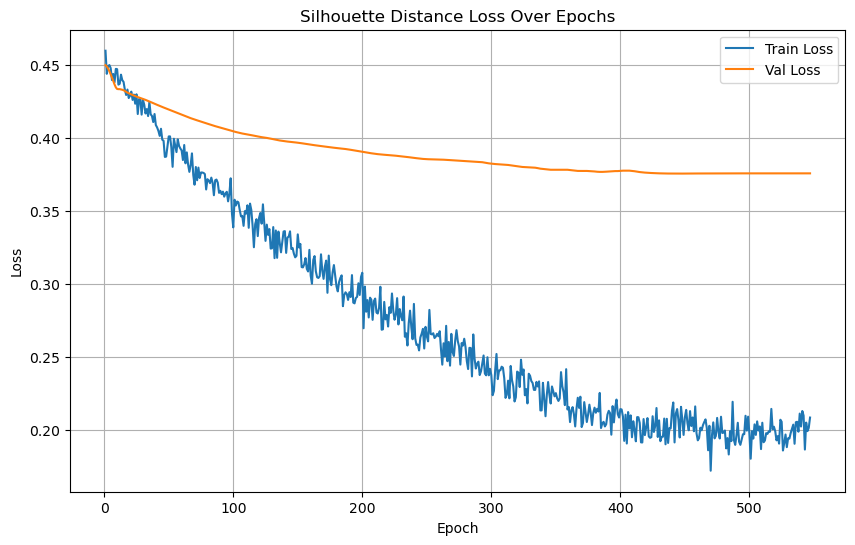

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/667], Loss: 0.2231
Test Batch [20/667], Loss: 0.2980
Test Batch [30/667], Loss: 0.2569


Test Batch [40/667], Loss: 0.4535
Test Batch [50/667], Loss: 0.3483
Test Batch [60/667], Loss: 0.2970
Test Batch [70/667], Loss: 0.2339


Test Batch [80/667], Loss: 0.2187
Test Batch [90/667], Loss: 0.2457
Test Batch [100/667], Loss: 0.1877
Test Batch [110/667], Loss: 0.1920
Test Batch [120/667], Loss: 0.2448


Test Batch [130/667], Loss: 0.2744
Test Batch [140/667], Loss: 0.2019
Test Batch [150/667], Loss: 0.1842
Test Batch [160/667], Loss: 0.2845
Test Batch [170/667], Loss: 0.2787
Test Batch [180/667], Loss: 0.5000


Test Batch [190/667], Loss: 0.2360
Test Batch [200/667], Loss: 0.5000
Test Batch [210/667], Loss: 0.5000
Test Batch [220/667], Loss: 0.5000
Test Batch [230/667], Loss: 0.1776
Test Batch [240/667], Loss: 0.5000
Test Batch [250/667], Loss: 0.5000
Test Batch [260/667], Loss: 0.5000
Test Batch [270/667], Loss: 0.5000
Test Batch [280/667], Loss: 0.5000
Test Batch [290/667], Loss: 0.5000
Test Batch [300/667], Loss: 0.5000


Test Batch [310/667], Loss: 0.2598
Test Batch [320/667], Loss: 0.2022
Test Batch [330/667], Loss: 0.2600
Test Batch [340/667], Loss: 0.1917


Test Batch [350/667], Loss: 0.2061
Test Batch [360/667], Loss: 0.3079
Test Batch [370/667], Loss: 0.1972


Test Batch [380/667], Loss: 0.2805
Test Batch [390/667], Loss: 0.2021
Test Batch [400/667], Loss: 0.1707


Test Batch [410/667], Loss: 0.2644
Test Batch [420/667], Loss: 0.1874
Test Batch [430/667], Loss: 0.2558


Test Batch [440/667], Loss: 0.3641
Test Batch [450/667], Loss: 0.2432
Test Batch [460/667], Loss: 0.4007
Test Batch [470/667], Loss: 0.4214


Test Batch [480/667], Loss: 0.3346
Test Batch [490/667], Loss: 0.2950
Test Batch [500/667], Loss: 0.1666


Test Batch [510/667], Loss: 0.2427
Test Batch [520/667], Loss: 0.3012
Test Batch [530/667], Loss: 0.5000
Test Batch [540/667], Loss: 0.5000


Test Batch [550/667], Loss: 0.3059
Test Batch [560/667], Loss: 0.2593
Test Batch [570/667], Loss: 0.2657


Test Batch [580/667], Loss: 0.1973
Test Batch [590/667], Loss: 0.2995
Test Batch [600/667], Loss: 0.4432
Test Batch [610/667], Loss: 0.3483


Test Batch [620/667], Loss: 0.4037
Test Batch [630/667], Loss: 0.4223
Test Batch [640/667], Loss: 0.2453
Test Batch [650/667], Loss: 0.3833


Test Batch [660/667], Loss: 0.3801

Test Loss: 0.3143


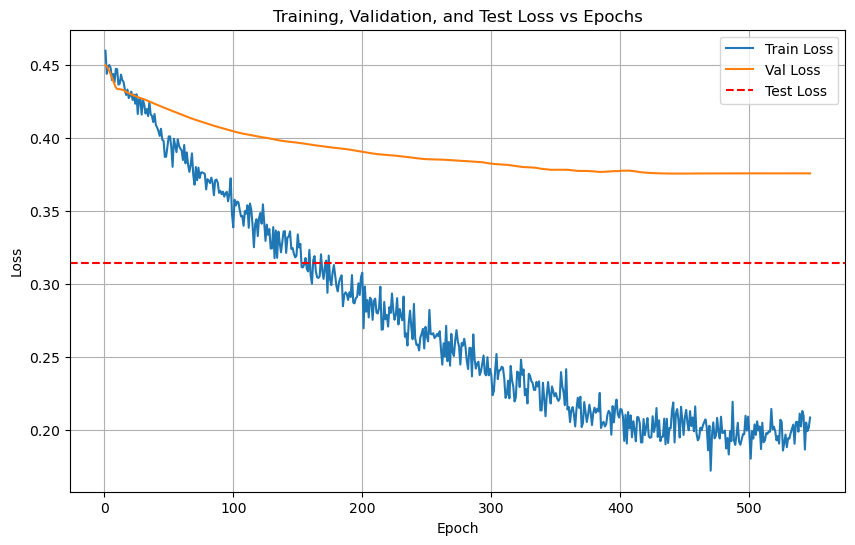

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/667 for test dataset.


  Processed batch 20/667 for test dataset.
  Processed batch 30/667 for test dataset.
  Processed batch 40/667 for test dataset.


  Processed batch 50/667 for test dataset.
  Processed batch 60/667 for test dataset.
  Processed batch 70/667 for test dataset.


  Processed batch 80/667 for test dataset.
  Processed batch 90/667 for test dataset.
  Processed batch 100/667 for test dataset.


  Processed batch 110/667 for test dataset.
  Processed batch 120/667 for test dataset.
  Processed batch 130/667 for test dataset.


  Processed batch 140/667 for test dataset.
  Processed batch 150/667 for test dataset.
  Processed batch 160/667 for test dataset.
  Processed batch 170/667 for test dataset.


  Processed batch 180/667 for test dataset.
  Processed batch 190/667 for test dataset.


  Processed batch 200/667 for test dataset.
  Processed batch 210/667 for test dataset.
  Processed batch 220/667 for test dataset.


  Processed batch 230/667 for test dataset.
  Processed batch 240/667 for test dataset.
  Processed batch 250/667 for test dataset.


  Processed batch 260/667 for test dataset.
  Processed batch 270/667 for test dataset.
  Processed batch 280/667 for test dataset.


  Processed batch 290/667 for test dataset.
  Processed batch 300/667 for test dataset.
  Processed batch 310/667 for test dataset.


  Processed batch 320/667 for test dataset.
  Processed batch 330/667 for test dataset.
  Processed batch 340/667 for test dataset.


  Processed batch 350/667 for test dataset.
  Processed batch 360/667 for test dataset.
  Processed batch 370/667 for test dataset.


  Processed batch 380/667 for test dataset.
  Processed batch 390/667 for test dataset.


  Processed batch 400/667 for test dataset.
  Processed batch 410/667 for test dataset.
  Processed batch 420/667 for test dataset.
  Processed batch 430/667 for test dataset.


  Processed batch 440/667 for test dataset.
  Processed batch 450/667 for test dataset.
  Processed batch 460/667 for test dataset.
  Processed batch 470/667 for test dataset.


  Processed batch 480/667 for test dataset.
  Processed batch 490/667 for test dataset.
  Processed batch 500/667 for test dataset.
  Processed batch 510/667 for test dataset.


  Processed batch 520/667 for test dataset.
  Processed batch 530/667 for test dataset.
  Processed batch 540/667 for test dataset.
  Processed batch 550/667 for test dataset.


  Processed batch 560/667 for test dataset.
  Processed batch 570/667 for test dataset.
  Processed batch 580/667 for test dataset.
  Processed batch 590/667 for test dataset.


  Processed batch 600/667 for test dataset.
  Processed batch 610/667 for test dataset.


  Processed batch 620/667 for test dataset.
  Processed batch 630/667 for test dataset.
  Processed batch 640/667 for test dataset.
  Processed batch 650/667 for test dataset.


  Processed batch 660/667 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.50      0.60      0.55         5
           2       0.60      0.60      0.60         5
           3       1.00      0.60      0.75         5
           4       1.00      0.80      0.89         5
           5       0.40      0.40      0.40         5
           6       1.00      1.00      1.00         5
           7       0.50      0.80      0.62         5
           8       1.00      1.00      1.00         5

    accuracy                           0.73        45
   macro avg       0.78      0.73      0.74        45
weighted avg       0.78      0.73      0.74        45


LOG: Evaluating on the test set...
Test Accuracy: 55.95%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (45, 128)
Train labels shape: (45,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42686, 128)
Test labels shape: (42686,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2135  |  Val Loss: 2.1823
Validation loss improved from inf to 2.1823.
[Epoch 2/1000] Train Loss: 2.2009  |  Val Loss: 2.1734
Validation loss improved from 2.1823 to 2.1734.
[Epoch 3/1000] Train Loss: 2.1884  |  Val Loss: 2.1645
Validation loss improved from 2.1734 to 2.1645.
[Epoch 4/1000] Train Loss: 2.1762  |  Val Loss: 2.1555
Validation loss improved from 2.1645 to 2.1555.
[Epoch 5/1000] Train Loss: 2.1640  |  Val Loss: 2.1466
Validation loss improved from 2.1555 to 2.1466.
[Epoch 6/1000] Train Loss: 2.1519  |  Val Loss: 2.1377
Validation loss improved from 2.1466 to 2.1377.
[Epoch 7/1000] Train Loss: 2.1400  |  Val Loss: 2.1289
Validation loss improved from 2.1377 to 2.1289.
[Epoch 8/1000] Train Loss: 2.1283  |  Val Loss: 2.1203
Validation loss improved from 2.1289 to 2.1203.
[Epoch 9/1000] Train Loss: 2.1168  |  Val Loss: 2.1118
Validation loss improved from 2.1203 to 2.1118.
[Epoch 10/1000] Train Loss: 2.1053  |  Val Loss: 2.1034
Validation loss impr

[Epoch 63/1000] Train Loss: 1.6682  |  Val Loss: 1.7854
Validation loss improved from 1.7902 to 1.7854.
[Epoch 64/1000] Train Loss: 1.6621  |  Val Loss: 1.7806
Validation loss improved from 1.7854 to 1.7806.
[Epoch 65/1000] Train Loss: 1.6559  |  Val Loss: 1.7759
Validation loss improved from 1.7806 to 1.7759.
[Epoch 66/1000] Train Loss: 1.6498  |  Val Loss: 1.7713
Validation loss improved from 1.7759 to 1.7713.
[Epoch 67/1000] Train Loss: 1.6436  |  Val Loss: 1.7667
Validation loss improved from 1.7713 to 1.7667.
[Epoch 68/1000] Train Loss: 1.6375  |  Val Loss: 1.7620
Validation loss improved from 1.7667 to 1.7620.
[Epoch 69/1000] Train Loss: 1.6313  |  Val Loss: 1.7575
Validation loss improved from 1.7620 to 1.7575.
[Epoch 70/1000] Train Loss: 1.6252  |  Val Loss: 1.7529
Validation loss improved from 1.7575 to 1.7529.
[Epoch 71/1000] Train Loss: 1.6191  |  Val Loss: 1.7484
Validation loss improved from 1.7529 to 1.7484.
[Epoch 72/1000] Train Loss: 1.6130  |  Val Loss: 1.7439
Validati

[Epoch 81/1000] Train Loss: 1.5567  |  Val Loss: 1.7026
Validation loss improved from 1.7074 to 1.7026.
[Epoch 82/1000] Train Loss: 1.5502  |  Val Loss: 1.6977
Validation loss improved from 1.7026 to 1.6977.
[Epoch 83/1000] Train Loss: 1.5435  |  Val Loss: 1.6925
Validation loss improved from 1.6977 to 1.6925.
[Epoch 84/1000] Train Loss: 1.5368  |  Val Loss: 1.6872
Validation loss improved from 1.6925 to 1.6872.
[Epoch 85/1000] Train Loss: 1.5298  |  Val Loss: 1.6818
Validation loss improved from 1.6872 to 1.6818.
[Epoch 86/1000] Train Loss: 1.5228  |  Val Loss: 1.6764
Validation loss improved from 1.6818 to 1.6764.
[Epoch 87/1000] Train Loss: 1.5156  |  Val Loss: 1.6710
Validation loss improved from 1.6764 to 1.6710.
[Epoch 88/1000] Train Loss: 1.5085  |  Val Loss: 1.6656
Validation loss improved from 1.6710 to 1.6656.
[Epoch 89/1000] Train Loss: 1.5014  |  Val Loss: 1.6600
Validation loss improved from 1.6656 to 1.6600.
[Epoch 90/1000] Train Loss: 1.4943  |  Val Loss: 1.6545
Validati

[Epoch 137/1000] Train Loss: 1.1919  |  Val Loss: 1.4179
Validation loss improved from 1.4225 to 1.4179.
[Epoch 138/1000] Train Loss: 1.1860  |  Val Loss: 1.4134
Validation loss improved from 1.4179 to 1.4134.
[Epoch 139/1000] Train Loss: 1.1800  |  Val Loss: 1.4089
Validation loss improved from 1.4134 to 1.4089.
[Epoch 140/1000] Train Loss: 1.1741  |  Val Loss: 1.4044
Validation loss improved from 1.4089 to 1.4044.
[Epoch 141/1000] Train Loss: 1.1682  |  Val Loss: 1.3999
Validation loss improved from 1.4044 to 1.3999.
[Epoch 142/1000] Train Loss: 1.1624  |  Val Loss: 1.3954
Validation loss improved from 1.3999 to 1.3954.
[Epoch 143/1000] Train Loss: 1.1565  |  Val Loss: 1.3909
Validation loss improved from 1.3954 to 1.3909.
[Epoch 144/1000] Train Loss: 1.1507  |  Val Loss: 1.3864
Validation loss improved from 1.3909 to 1.3864.
[Epoch 145/1000] Train Loss: 1.1449  |  Val Loss: 1.3819
Validation loss improved from 1.3864 to 1.3819.
[Epoch 146/1000] Train Loss: 1.1391  |  Val Loss: 1.377

[Epoch 160/1000] Train Loss: 1.0608  |  Val Loss: 1.3162
Validation loss improved from 1.3205 to 1.3162.
[Epoch 161/1000] Train Loss: 1.0554  |  Val Loss: 1.3119
Validation loss improved from 1.3162 to 1.3119.
[Epoch 162/1000] Train Loss: 1.0500  |  Val Loss: 1.3076
Validation loss improved from 1.3119 to 1.3076.
[Epoch 163/1000] Train Loss: 1.0446  |  Val Loss: 1.3033
Validation loss improved from 1.3076 to 1.3033.
[Epoch 164/1000] Train Loss: 1.0393  |  Val Loss: 1.2990
Validation loss improved from 1.3033 to 1.2990.
[Epoch 165/1000] Train Loss: 1.0339  |  Val Loss: 1.2947
Validation loss improved from 1.2990 to 1.2947.
[Epoch 166/1000] Train Loss: 1.0286  |  Val Loss: 1.2904
Validation loss improved from 1.2947 to 1.2904.
[Epoch 167/1000] Train Loss: 1.0233  |  Val Loss: 1.2861
Validation loss improved from 1.2904 to 1.2861.
[Epoch 168/1000] Train Loss: 1.0180  |  Val Loss: 1.2818
Validation loss improved from 1.2861 to 1.2818.
[Epoch 169/1000] Train Loss: 1.0127  |  Val Loss: 1.277

[Epoch 218/1000] Train Loss: 0.7602  |  Val Loss: 1.0870
Validation loss improved from 1.0905 to 1.0870.
[Epoch 219/1000] Train Loss: 0.7553  |  Val Loss: 1.0835
Validation loss improved from 1.0870 to 1.0835.
[Epoch 220/1000] Train Loss: 0.7503  |  Val Loss: 1.0801
Validation loss improved from 1.0835 to 1.0801.
[Epoch 221/1000] Train Loss: 0.7454  |  Val Loss: 1.0766
Validation loss improved from 1.0801 to 1.0766.
[Epoch 222/1000] Train Loss: 0.7405  |  Val Loss: 1.0732
Validation loss improved from 1.0766 to 1.0732.
[Epoch 223/1000] Train Loss: 0.7356  |  Val Loss: 1.0698
Validation loss improved from 1.0732 to 1.0698.
[Epoch 224/1000] Train Loss: 0.7308  |  Val Loss: 1.0664
Validation loss improved from 1.0698 to 1.0664.
[Epoch 225/1000] Train Loss: 0.7259  |  Val Loss: 1.0630
Validation loss improved from 1.0664 to 1.0630.
[Epoch 226/1000] Train Loss: 0.7211  |  Val Loss: 1.0597
Validation loss improved from 1.0630 to 1.0597.
[Epoch 227/1000] Train Loss: 0.7162  |  Val Loss: 1.056

[Epoch 237/1000] Train Loss: 0.6684  |  Val Loss: 1.0242
Validation loss improved from 1.0273 to 1.0242.
[Epoch 238/1000] Train Loss: 0.6637  |  Val Loss: 1.0211
Validation loss improved from 1.0242 to 1.0211.
[Epoch 239/1000] Train Loss: 0.6590  |  Val Loss: 1.0180
Validation loss improved from 1.0211 to 1.0180.
[Epoch 240/1000] Train Loss: 0.6543  |  Val Loss: 1.0149
Validation loss improved from 1.0180 to 1.0149.
[Epoch 241/1000] Train Loss: 0.6496  |  Val Loss: 1.0119
Validation loss improved from 1.0149 to 1.0119.
[Epoch 242/1000] Train Loss: 0.6449  |  Val Loss: 1.0088
Validation loss improved from 1.0119 to 1.0088.
[Epoch 243/1000] Train Loss: 0.6402  |  Val Loss: 1.0058
Validation loss improved from 1.0088 to 1.0058.
[Epoch 244/1000] Train Loss: 0.6355  |  Val Loss: 1.0028
Validation loss improved from 1.0058 to 1.0028.
[Epoch 245/1000] Train Loss: 0.6308  |  Val Loss: 0.9998
Validation loss improved from 1.0028 to 0.9998.
[Epoch 246/1000] Train Loss: 0.6262  |  Val Loss: 0.996

[Epoch 298/1000] Train Loss: 0.4053  |  Val Loss: 0.8623
Validation loss improved from 0.8644 to 0.8623.
[Epoch 299/1000] Train Loss: 0.4015  |  Val Loss: 0.8603
Validation loss improved from 0.8623 to 0.8603.
[Epoch 300/1000] Train Loss: 0.3977  |  Val Loss: 0.8583
Validation loss improved from 0.8603 to 0.8583.
[Epoch 301/1000] Train Loss: 0.3940  |  Val Loss: 0.8563
Validation loss improved from 0.8583 to 0.8563.
[Epoch 302/1000] Train Loss: 0.3902  |  Val Loss: 0.8543
Validation loss improved from 0.8563 to 0.8543.
[Epoch 303/1000] Train Loss: 0.3865  |  Val Loss: 0.8524
Validation loss improved from 0.8543 to 0.8524.
[Epoch 304/1000] Train Loss: 0.3828  |  Val Loss: 0.8504
Validation loss improved from 0.8524 to 0.8504.
[Epoch 305/1000] Train Loss: 0.3791  |  Val Loss: 0.8486
Validation loss improved from 0.8504 to 0.8486.
[Epoch 306/1000] Train Loss: 0.3754  |  Val Loss: 0.8467
Validation loss improved from 0.8486 to 0.8467.
[Epoch 307/1000] Train Loss: 0.3718  |  Val Loss: 0.845

[Epoch 316/1000] Train Loss: 0.3401  |  Val Loss: 0.8302
Validation loss improved from 0.8317 to 0.8302.
[Epoch 317/1000] Train Loss: 0.3368  |  Val Loss: 0.8287
Validation loss improved from 0.8302 to 0.8287.
[Epoch 318/1000] Train Loss: 0.3334  |  Val Loss: 0.8272
Validation loss improved from 0.8287 to 0.8272.
[Epoch 319/1000] Train Loss: 0.3301  |  Val Loss: 0.8257
Validation loss improved from 0.8272 to 0.8257.
[Epoch 320/1000] Train Loss: 0.3268  |  Val Loss: 0.8243
Validation loss improved from 0.8257 to 0.8243.
[Epoch 321/1000] Train Loss: 0.3235  |  Val Loss: 0.8229
Validation loss improved from 0.8243 to 0.8229.
[Epoch 322/1000] Train Loss: 0.3203  |  Val Loss: 0.8215
Validation loss improved from 0.8229 to 0.8215.
[Epoch 323/1000] Train Loss: 0.3171  |  Val Loss: 0.8202
Validation loss improved from 0.8215 to 0.8202.
[Epoch 324/1000] Train Loss: 0.3139  |  Val Loss: 0.8188
Validation loss improved from 0.8202 to 0.8188.
[Epoch 325/1000] Train Loss: 0.3107  |  Val Loss: 0.817

[Epoch 380/1000] Train Loss: 0.1781  |  Val Loss: 0.7766
Validation loss improved from 0.7769 to 0.7766.
[Epoch 381/1000] Train Loss: 0.1763  |  Val Loss: 0.7763
Validation loss improved from 0.7766 to 0.7763.
[Epoch 382/1000] Train Loss: 0.1746  |  Val Loss: 0.7760
Validation loss improved from 0.7763 to 0.7760.
[Epoch 383/1000] Train Loss: 0.1729  |  Val Loss: 0.7757
Validation loss improved from 0.7760 to 0.7757.
[Epoch 384/1000] Train Loss: 0.1712  |  Val Loss: 0.7754
Validation loss improved from 0.7757 to 0.7754.
[Epoch 385/1000] Train Loss: 0.1696  |  Val Loss: 0.7752
Validation loss improved from 0.7754 to 0.7752.
[Epoch 386/1000] Train Loss: 0.1680  |  Val Loss: 0.7749
Validation loss improved from 0.7752 to 0.7749.
[Epoch 387/1000] Train Loss: 0.1663  |  Val Loss: 0.7747
Validation loss improved from 0.7749 to 0.7747.
[Epoch 388/1000] Train Loss: 0.1647  |  Val Loss: 0.7745
Validation loss improved from 0.7747 to 0.7745.
[Epoch 389/1000] Train Loss: 0.1632  |  Val Loss: 0.774

[Epoch 403/1000] Train Loss: 0.1429  |  Val Loss: 0.7726
Validation loss improved from 0.7727 to 0.7726.
[Epoch 404/1000] Train Loss: 0.1416  |  Val Loss: 0.7725
Validation loss improved from 0.7726 to 0.7725.
[Epoch 405/1000] Train Loss: 0.1403  |  Val Loss: 0.7725
Validation loss improved from 0.7725 to 0.7725.
[Epoch 406/1000] Train Loss: 0.1390  |  Val Loss: 0.7725
Validation loss improved from 0.7725 to 0.7725.
[Epoch 407/1000] Train Loss: 0.1377  |  Val Loss: 0.7724
Validation loss improved from 0.7725 to 0.7724.
[Epoch 408/1000] Train Loss: 0.1364  |  Val Loss: 0.7724
Validation loss improved from 0.7724 to 0.7724.
[Epoch 409/1000] Train Loss: 0.1352  |  Val Loss: 0.7724
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 410/1000] Train Loss: 0.1339  |  Val Loss: 0.7725
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 411/1000] Train Loss: 0.1327  |  Val Loss: 0.7725
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 412/1000] Train Loss: 0.1315  

[Epoch 459/1000] Train Loss: 0.0864  |  Val Loss: 0.7845
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 460/1000] Train Loss: 0.0857  |  Val Loss: 0.7849
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 461/1000] Train Loss: 0.0850  |  Val Loss: 0.7854
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 462/1000] Train Loss: 0.0843  |  Val Loss: 0.7858
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 463/1000] Train Loss: 0.0836  |  Val Loss: 0.7862
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 464/1000] Train Loss: 0.0829  |  Val Loss: 0.7866
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 465/1000] Train Loss: 0.0822  |  Val Loss: 0.7870
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 466/1000] Train Loss: 0.0815  |  Val Loss: 0.7874
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 467/1000] Train Loss: 0.0808  |  Val Loss: 0.7879
!! Validation loss did NOT improve !! Patience:

[Epoch 480/1000] Train Loss: 0.0729  |  Val Loss: 0.7935
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 481/1000] Train Loss: 0.0723  |  Val Loss: 0.7939
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 482/1000] Train Loss: 0.0717  |  Val Loss: 0.7944
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 483/1000] Train Loss: 0.0712  |  Val Loss: 0.7949
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 484/1000] Train Loss: 0.0706  |  Val Loss: 0.7954
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 485/1000] Train Loss: 0.0701  |  Val Loss: 0.7959
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 486/1000] Train Loss: 0.0695  |  Val Loss: 0.7964
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 487/1000] Train Loss: 0.0690  |  Val Loss: 0.7969
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 488/1000] Train Loss: 0.0685  |  Val Loss: 0.7973
!! Validation loss did NOT improve !! Patience:

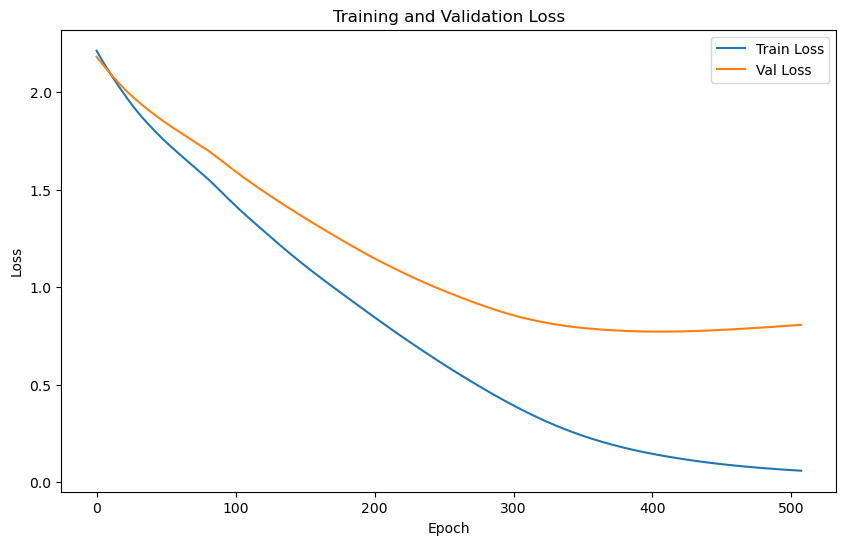

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.2878 | Test Accuracy: 58.06%


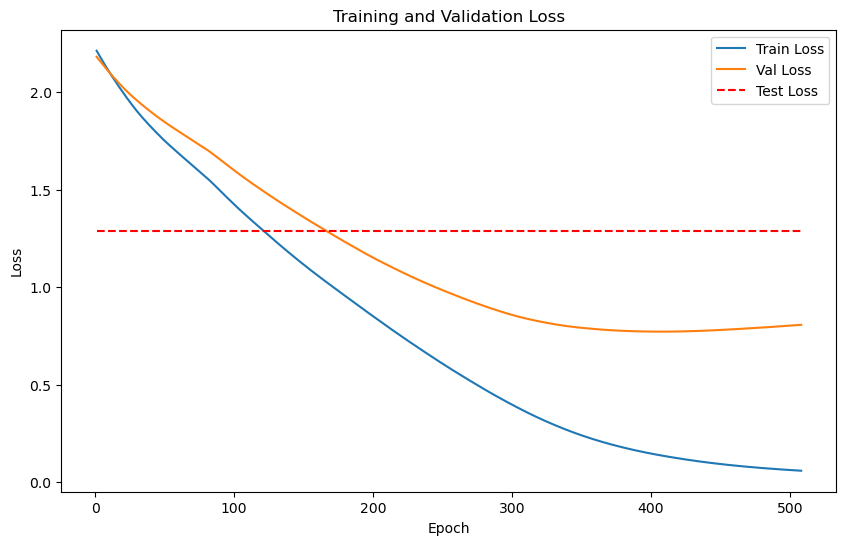

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


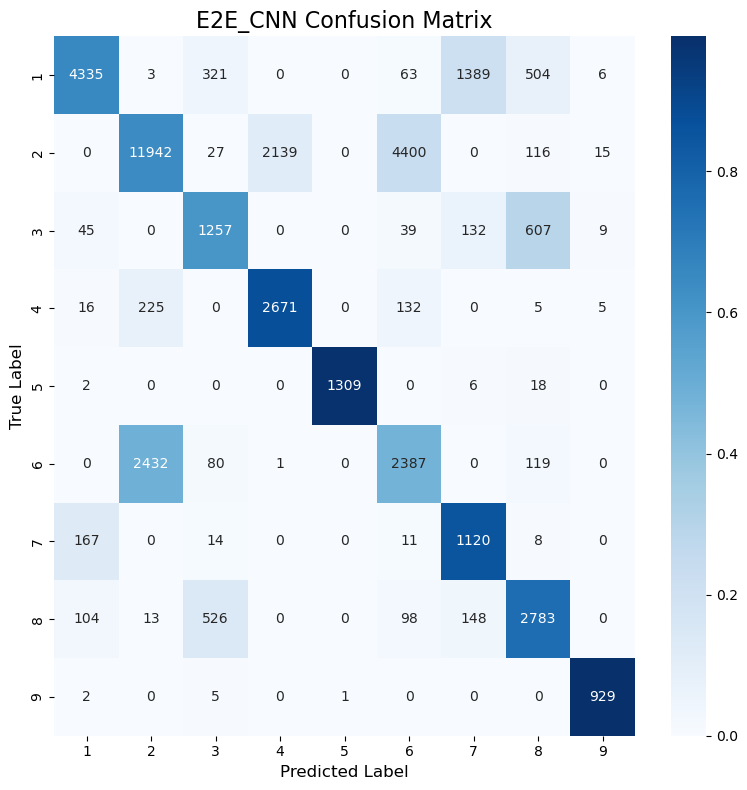

Classification Accuracy: 67.31%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


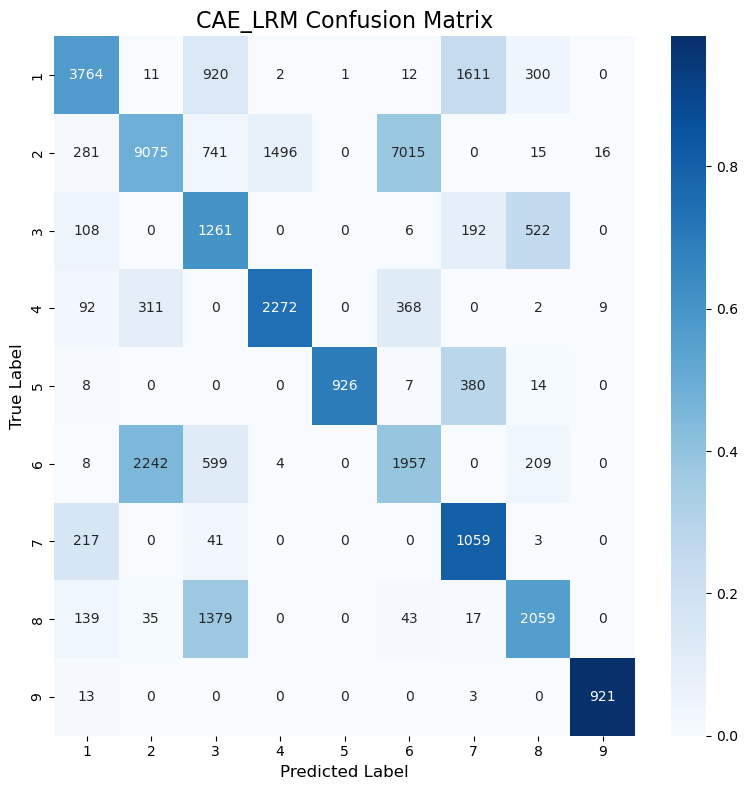

Classification Accuracy: 54.57%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


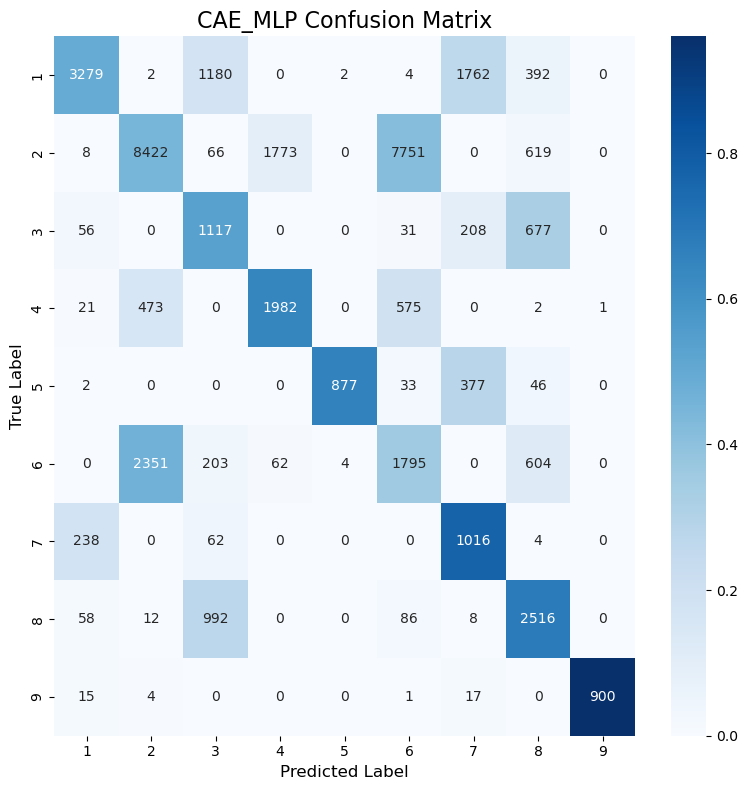

Classification Accuracy: 51.31%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


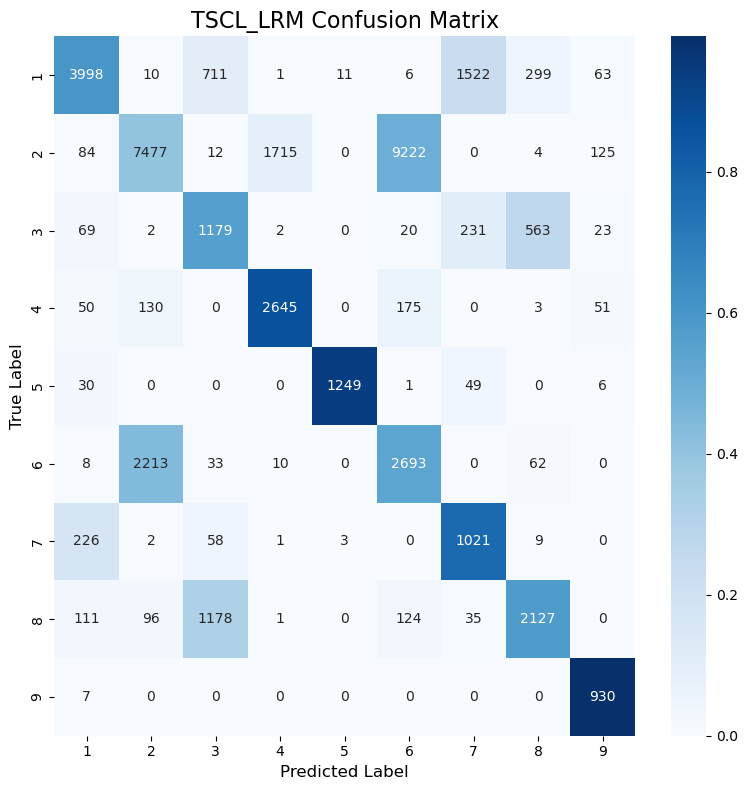

Classification Accuracy: 54.63%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


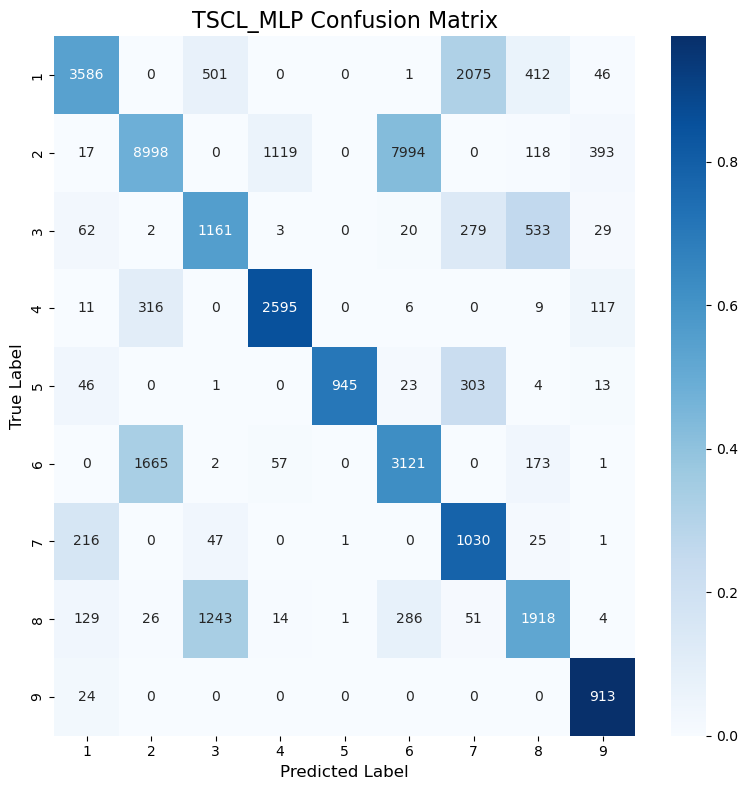

Classification Accuracy: 56.85%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


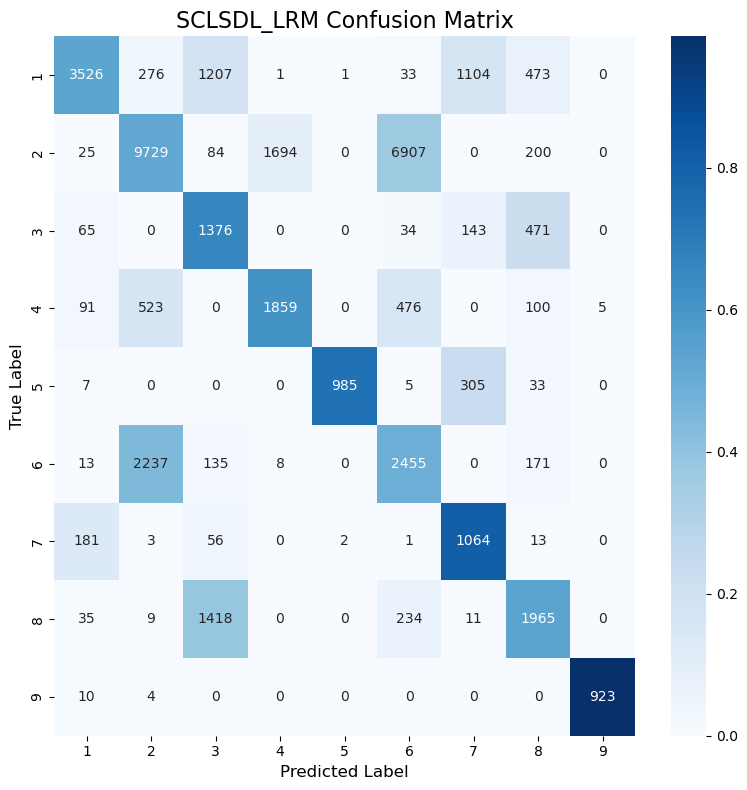

Classification Accuracy: 55.95%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


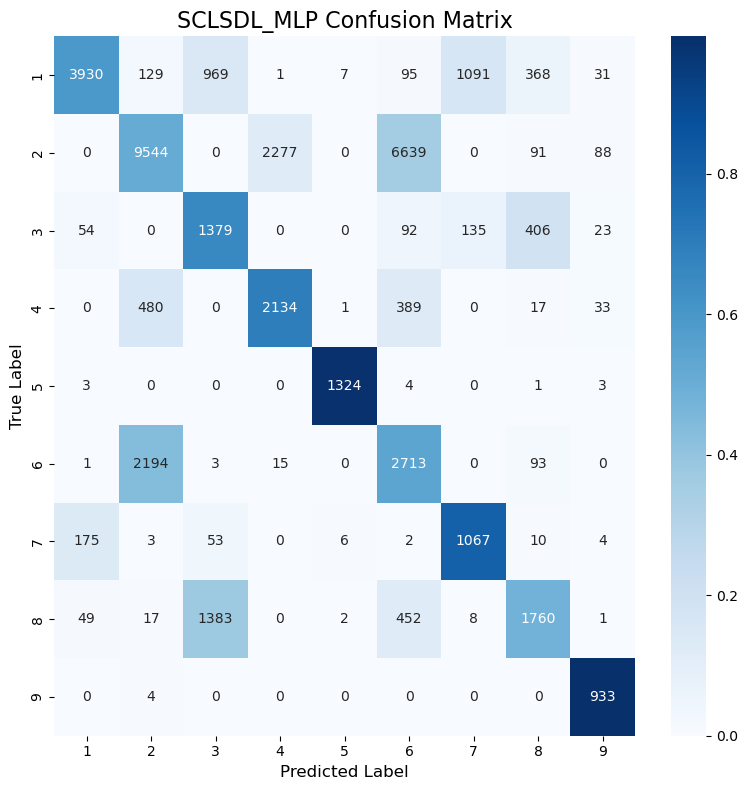

Classification Accuracy: 58.06%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          67.31
1    LRM (CAE)          54.57
2    MLP (CAE)          51.31
3     TSCL LRM          54.63
4     TSCL MLP          56.85
5  SCL_SDL LRM          55.95
6  SCL_SDL MLP          58.06

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          67.31
6  SCL_SDL MLP          58.06
4     TSCL MLP          56.85
5  SCL_SDL LRM          55.95
3     TSCL LRM          54.63
1    LRM (CAE)          54.57
2    MLP (CAE)          51.31
